In [187]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import zipfile

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier

from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [158]:
cwd = Path.cwd() 
data_dir = cwd / 'Kaggle_data' / 'ts-course-data'
comp_dir = cwd / 'Kaggle_data' / 'store-sales-time-series-forecasting'

# Простые временные ряды

In [1]:
# Setup notebook
sns.set_theme()
sns.set(style="whitegrid", rc={"figure.figsize": (10, 5)})

In [4]:
book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col = 'Date',
    parse_dates = ['Date']).drop('Paperback', axis = 1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns = ['Hardcover', 'Time', 'Lag_1']) # Зачем ?

ar = pd.read_csv(data_dir / 'ar.csv') # Пока не понятно, что это

Выгрузка данных из архивированного train.zip.csv

In [5]:
with zipfile.ZipFile(comp_dir / 'train.csv.zip', 'r') as rip_ref:
    rip_ref.extract('train.csv', path = 'temporary_folder')
train_file_path = Path('temporary_folder', 'train.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv(
    train_file_path,
    dtype = dtype,
    parse_dates = ['date'])
store_sales_temp = store_sales

Преобразуем даты в периодические по дням. Номер магазина, семейство товаров переводим в индексы

In [6]:
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby(['date'], observed=True).mean()['sales']

Text(0.5, 1.0, 'Time plot of Hardcover Sales')

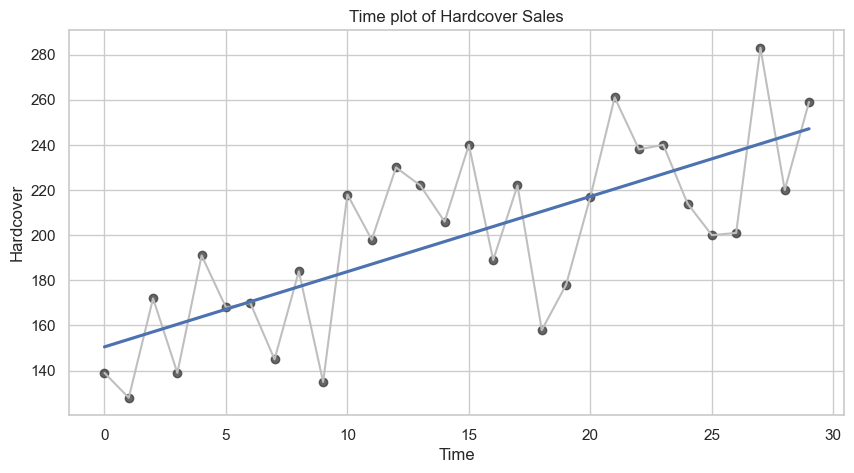

In [7]:
fig, ax = plt.subplots()
ax = plt.plot('Time', 'Hardcover', data = book_sales, color = '0.75')
ax = sns.regplot(x = 'Time', y = 'Hardcover', data = book_sales, ci = False, scatter_kws=dict(color='0.25'))
ax.set_title('Time plot of Hardcover Sales')

Text(0.5, 1.0, 'Series 2')

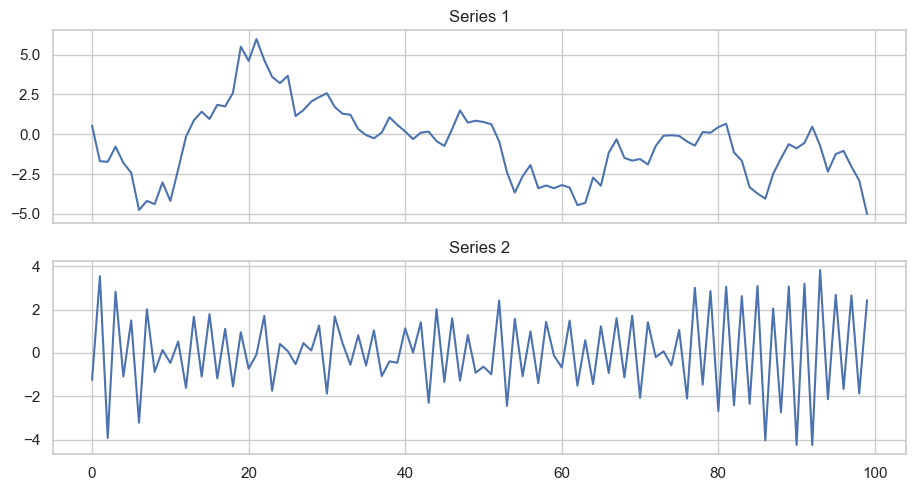

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2')

Прогнозирование одного из временных рядов. Временного ряда средхих цен

In [9]:
df = average_sales.to_frame()
df['time'] = np.arange(len(df.index))

X = df.loc[:, ['time']]
y = df.loc[:, 'sales']

model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index = X.index)
y_pred

date
2013-01-01    194.232790
2013-01-02    194.427137
2013-01-03    194.621484
2013-01-04    194.815831
2013-01-05    195.010178
                 ...    
2017-08-11    520.541320
2017-08-12    520.735667
2017-08-13    520.930014
2017-08-14    521.124361
2017-08-15    521.318708
Freq: D, Length: 1684, dtype: float64

Text(0.5, 1.0, 'Time plot of sales')

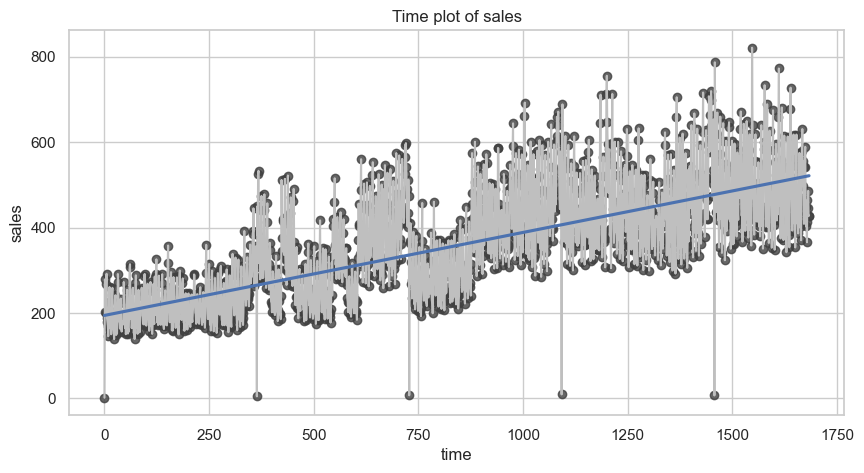

In [10]:
fig, ax = plt.subplots()
ax = plt.plot('time', 'sales', data = df, color = '0.75')
ax = sns.regplot(x= 'time', y= 'sales', data = df, ci = False, scatter_kws=dict(color='0.25'))
ax.set_title('Time plot of sales')

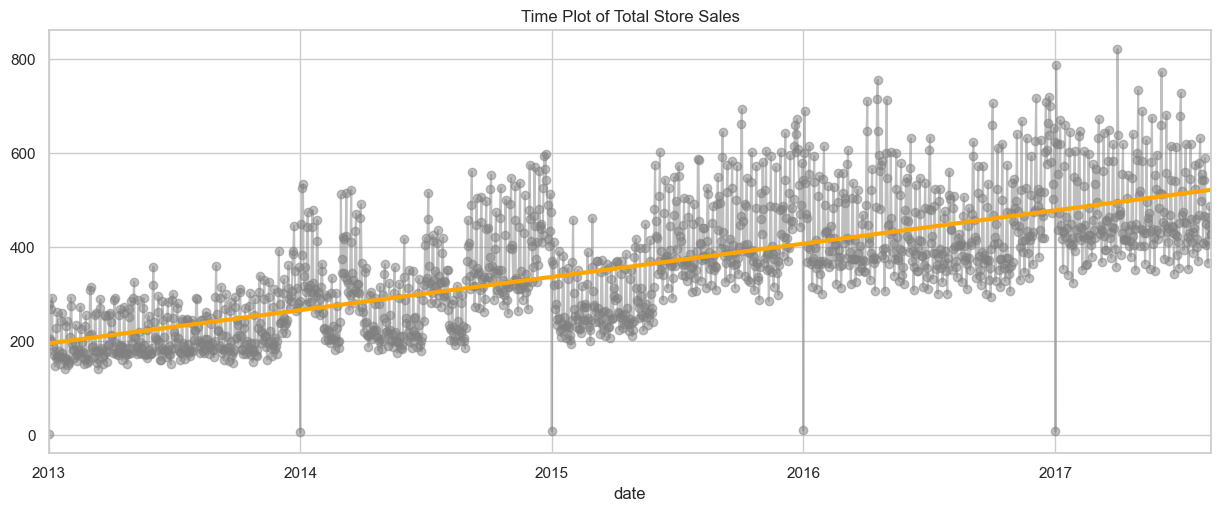

In [11]:
fig, ax = plt.subplots(figsize=(15, 5.5))
ax = y.plot(alpha = 0.5, marker = 'o', linestyle='-', color = 'grey')
ax = y_pred.plot(ax=ax, linewidth=3, color = 'orange')
ax.set_title('Time Plot of Total Store Sales');

Добавим Lag features (сдвинутые во времени цены на 1 день)

In [12]:
df = average_sales.to_frame()
df['lag_1'] = df['sales'].shift(1)

X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']
y, X = y.align(X, join = 'inner')

model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index = X.index)
y_pred

date
2013-01-02     85.301628
2013-01-03    297.268219
2013-01-04    239.451309
2013-01-05    236.444519
2013-01-06    289.219421
                 ...    
2017-08-11    363.958893
2017-08-12    439.106384
2017-08-13    424.615509
2017-08-14    455.969025
2017-08-15    410.998566
Freq: D, Length: 1683, dtype: float32

[None,
 Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'lag_1'),
 Text(0.5, 1.0, 'Lag Plot of Average Sales')]

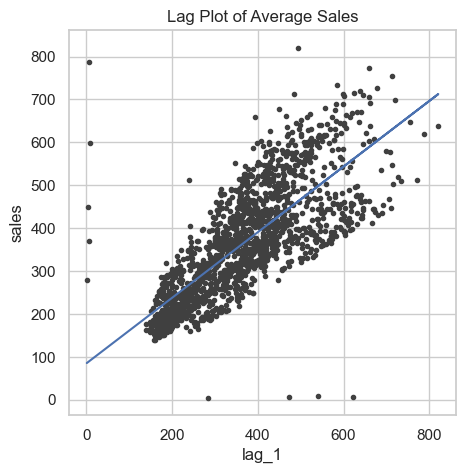

In [13]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color = '0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales')

# Тренды

Трендовый компонент временного ряда представляет собой устойчивое, долгосрочное изменение среднего значения ряда. Тренд - это наиболее медленно изменяющаяся часть ряда, представляющая наибольшую по значимости временную шкалу

In [14]:
from warnings import simplefilter
simplefilter('ignore')
plt.style.use("ggplot")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color = '0.75',
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates = ['Day'])
tunnel = tunnel.set_index('Day').to_period()

График скользящего среднего

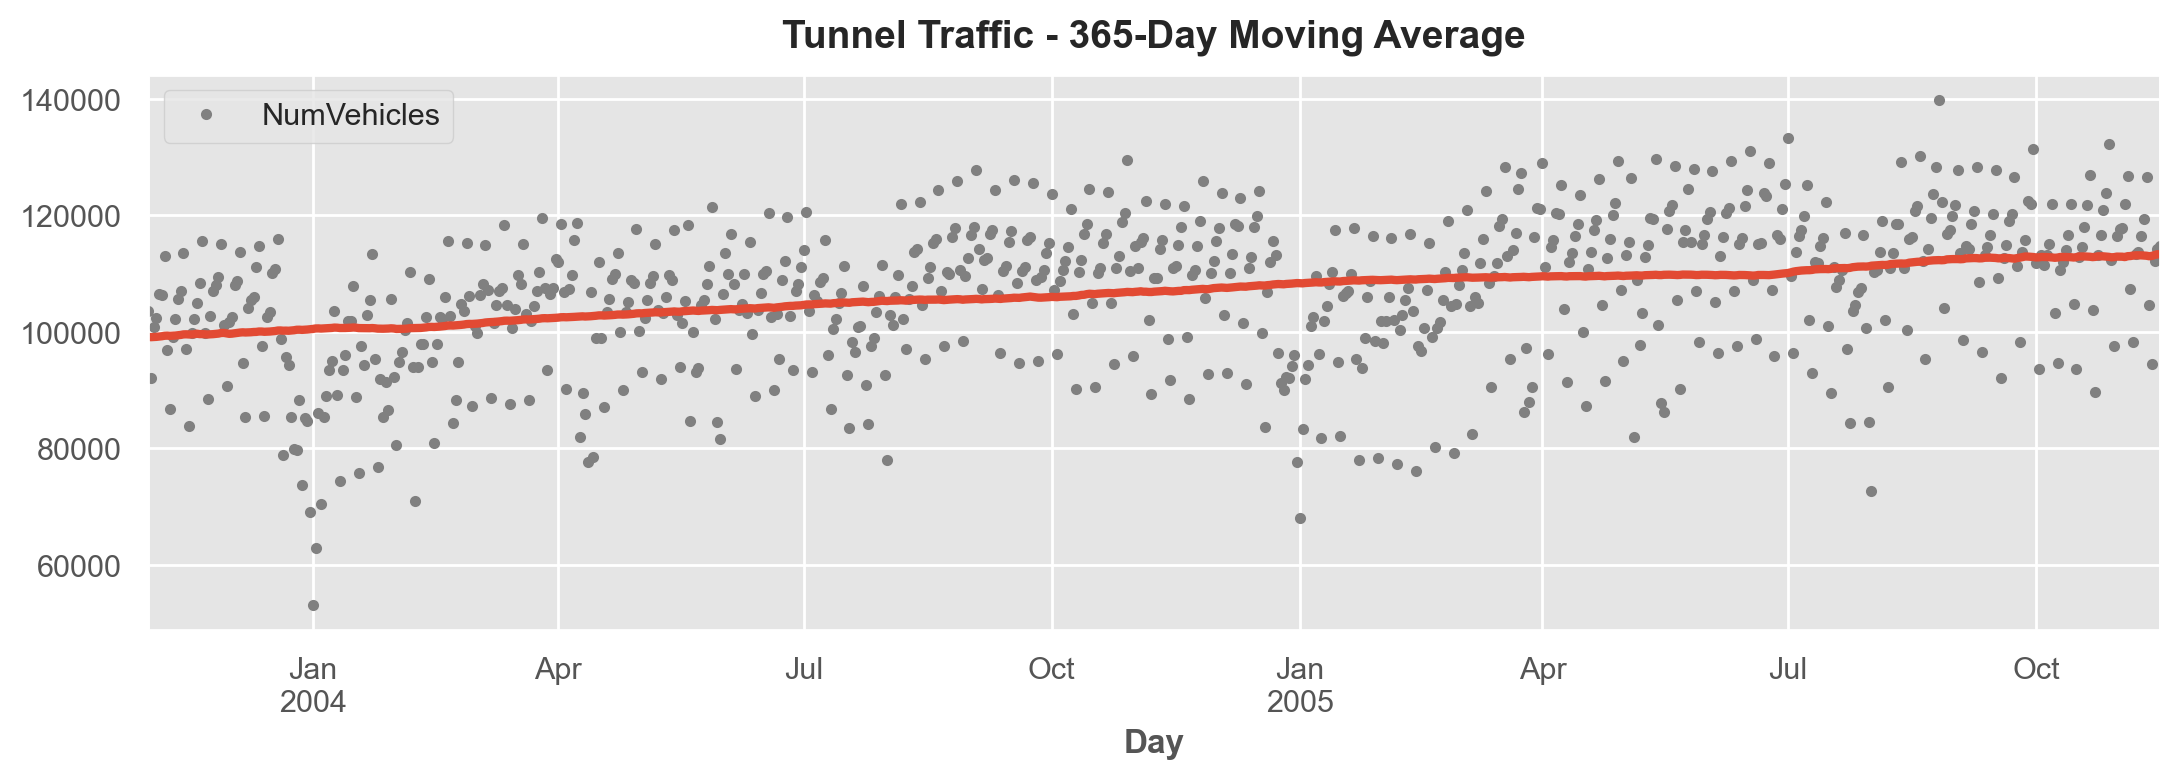

In [15]:
moving_average = tunnel.rolling(
    window = 365, 
    min_periods = 183,
    center = True).mean()
ax = tunnel.plot(style = '.', color = '0.5')
moving_average.plot(ax = ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

Простроение рядов

In [16]:
dp = DeterministicProcess(
    index = tunnel.index,
    constant = True,
    order = 1,
    drop = True)

X = dp.in_sample()

y = tunnel['NumVehicles']
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Freq: D, Length: 747, dtype: float64

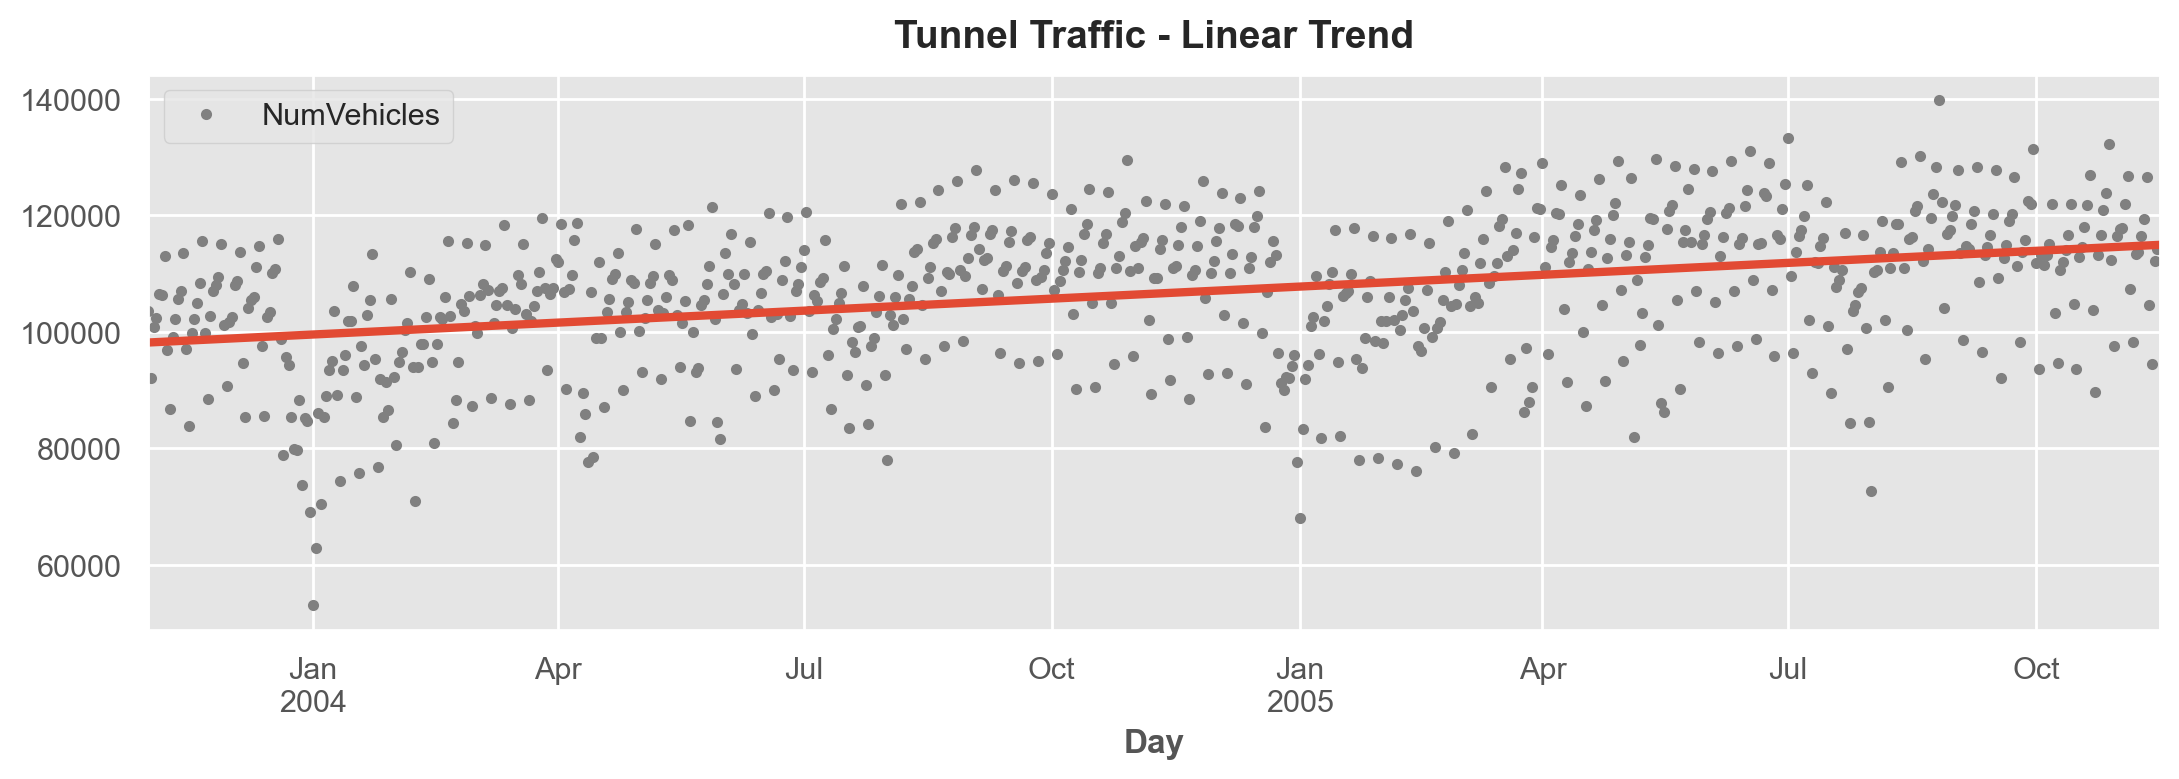

In [17]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [18]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

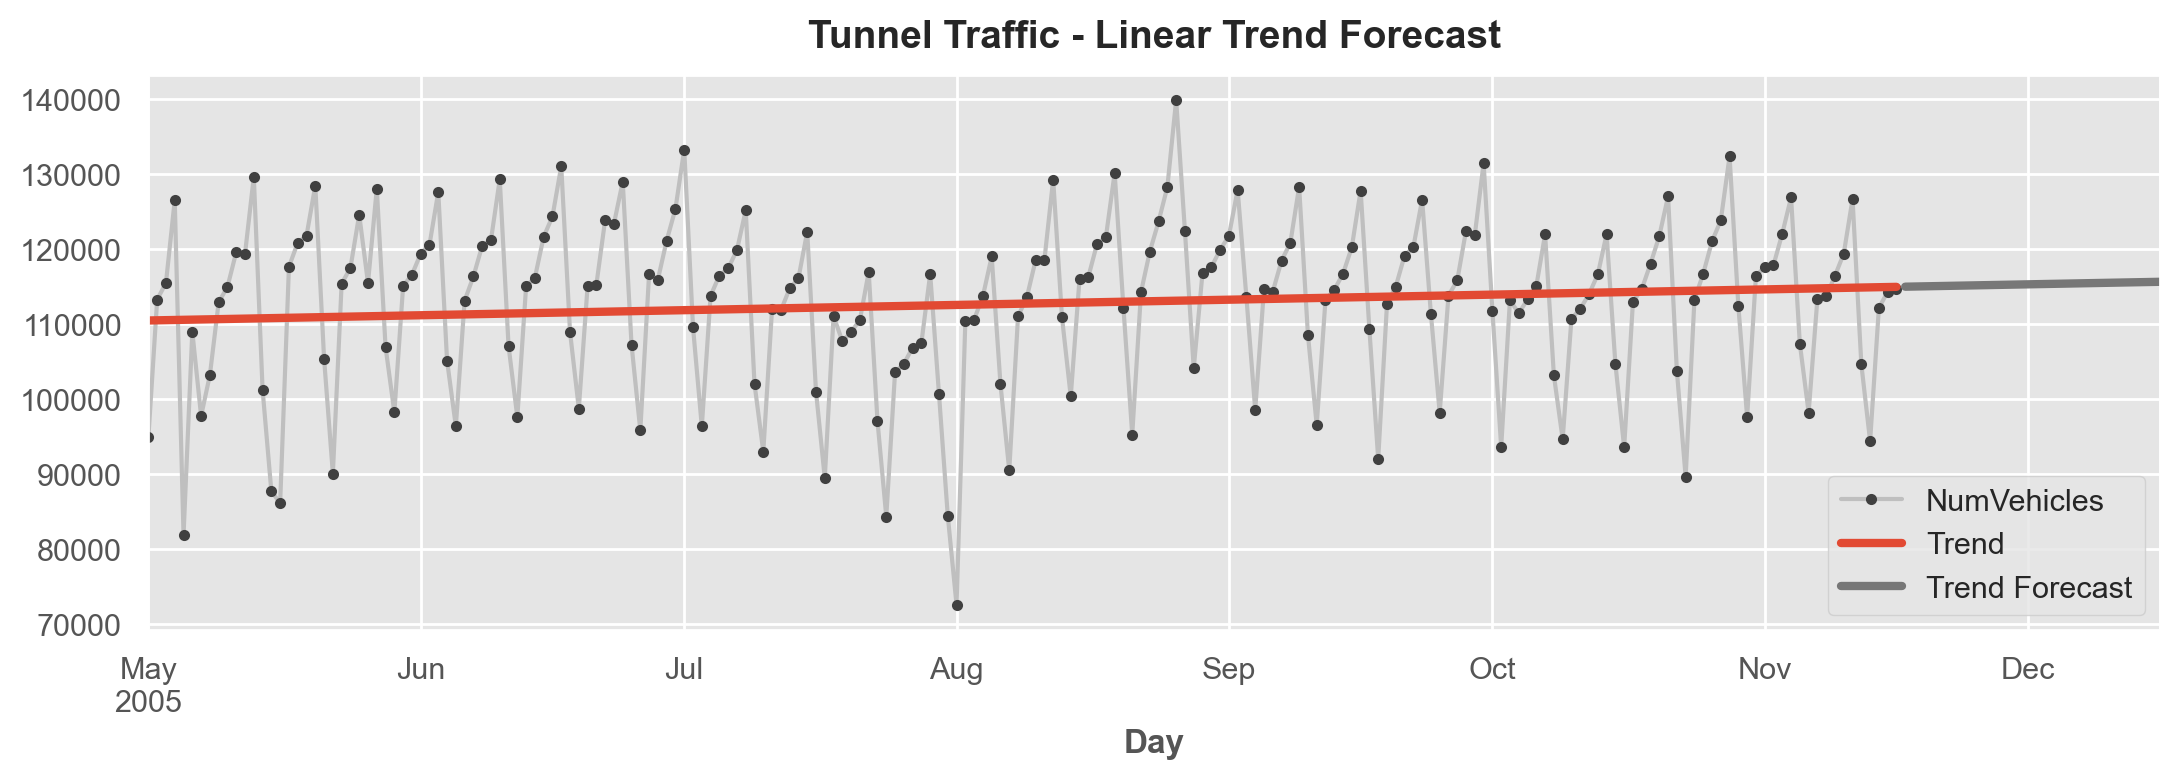

In [19]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

Задания

In [20]:
for file in data_dir.iterdir():
    print(file.name)

.ipynb_checkpoints
ar.csv
avocados.csv
book_sales.csv
co2.csv
elecdemand.csv
flu-trends.csv
reserve.csv
trig.csv
tunnel.csv
us-retail-sales.csv


In [21]:
retail_sales = pd.read_csv(
    data_dir / 'us-retail-sales.csv',
    parse_dates = ['Month'],
    index_col = 'Month').to_period('M')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']
# store_sales
# average_sales

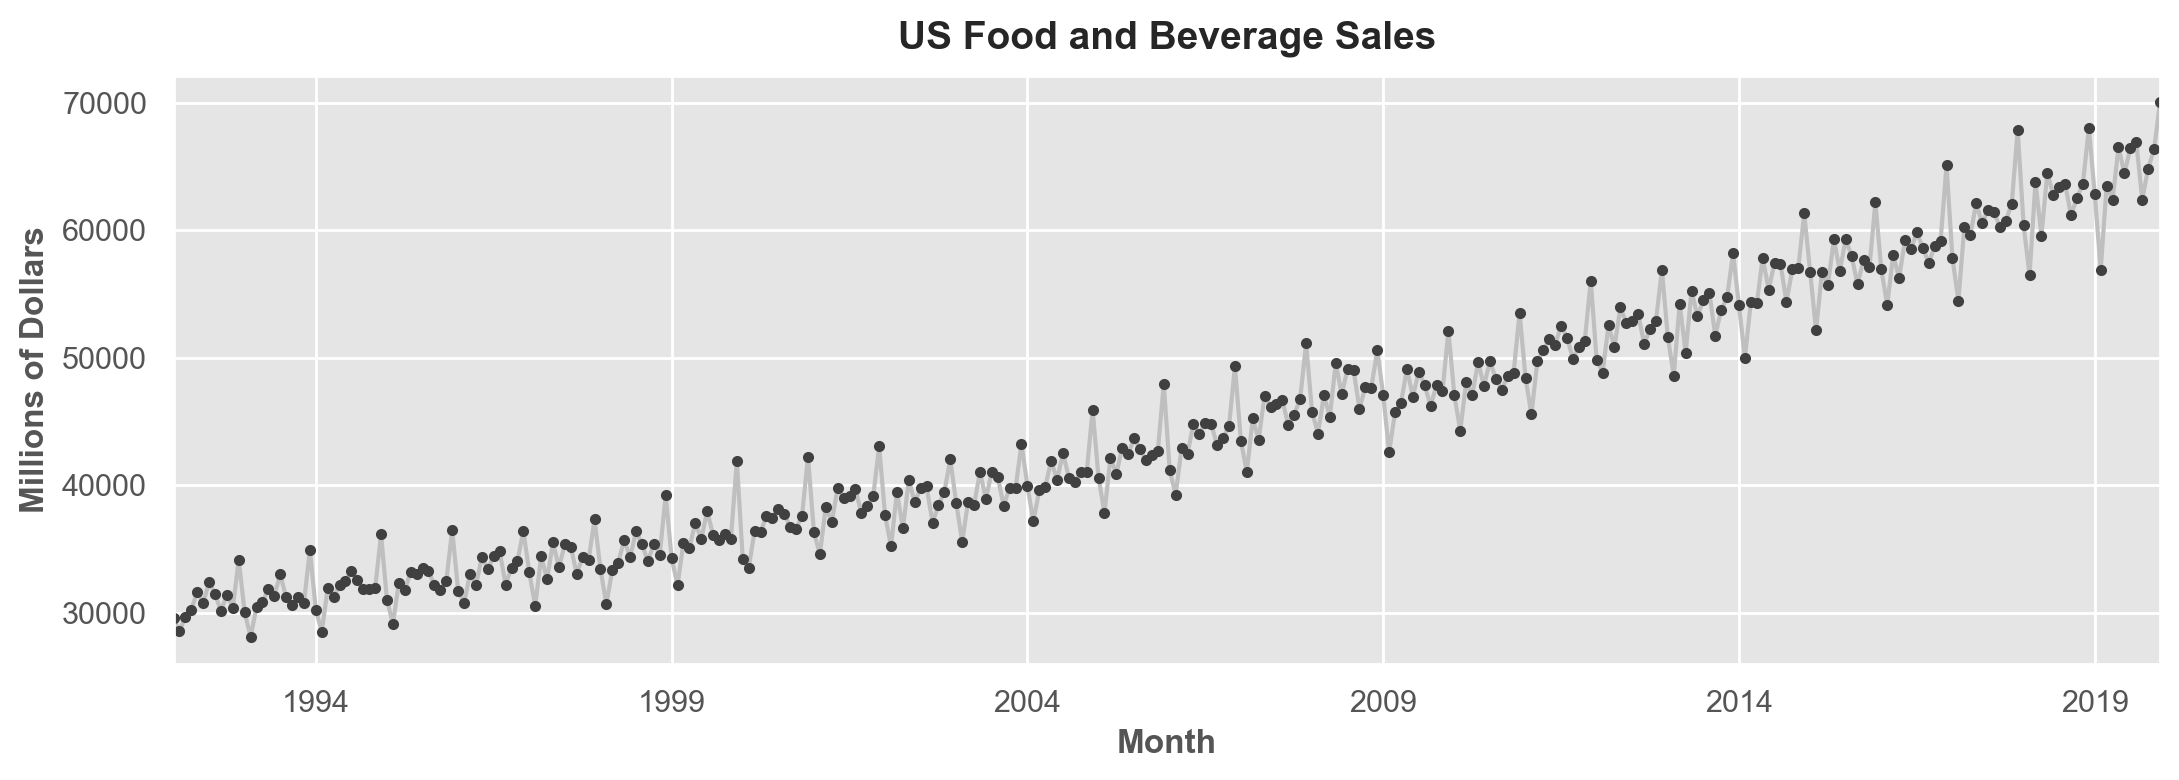

In [22]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

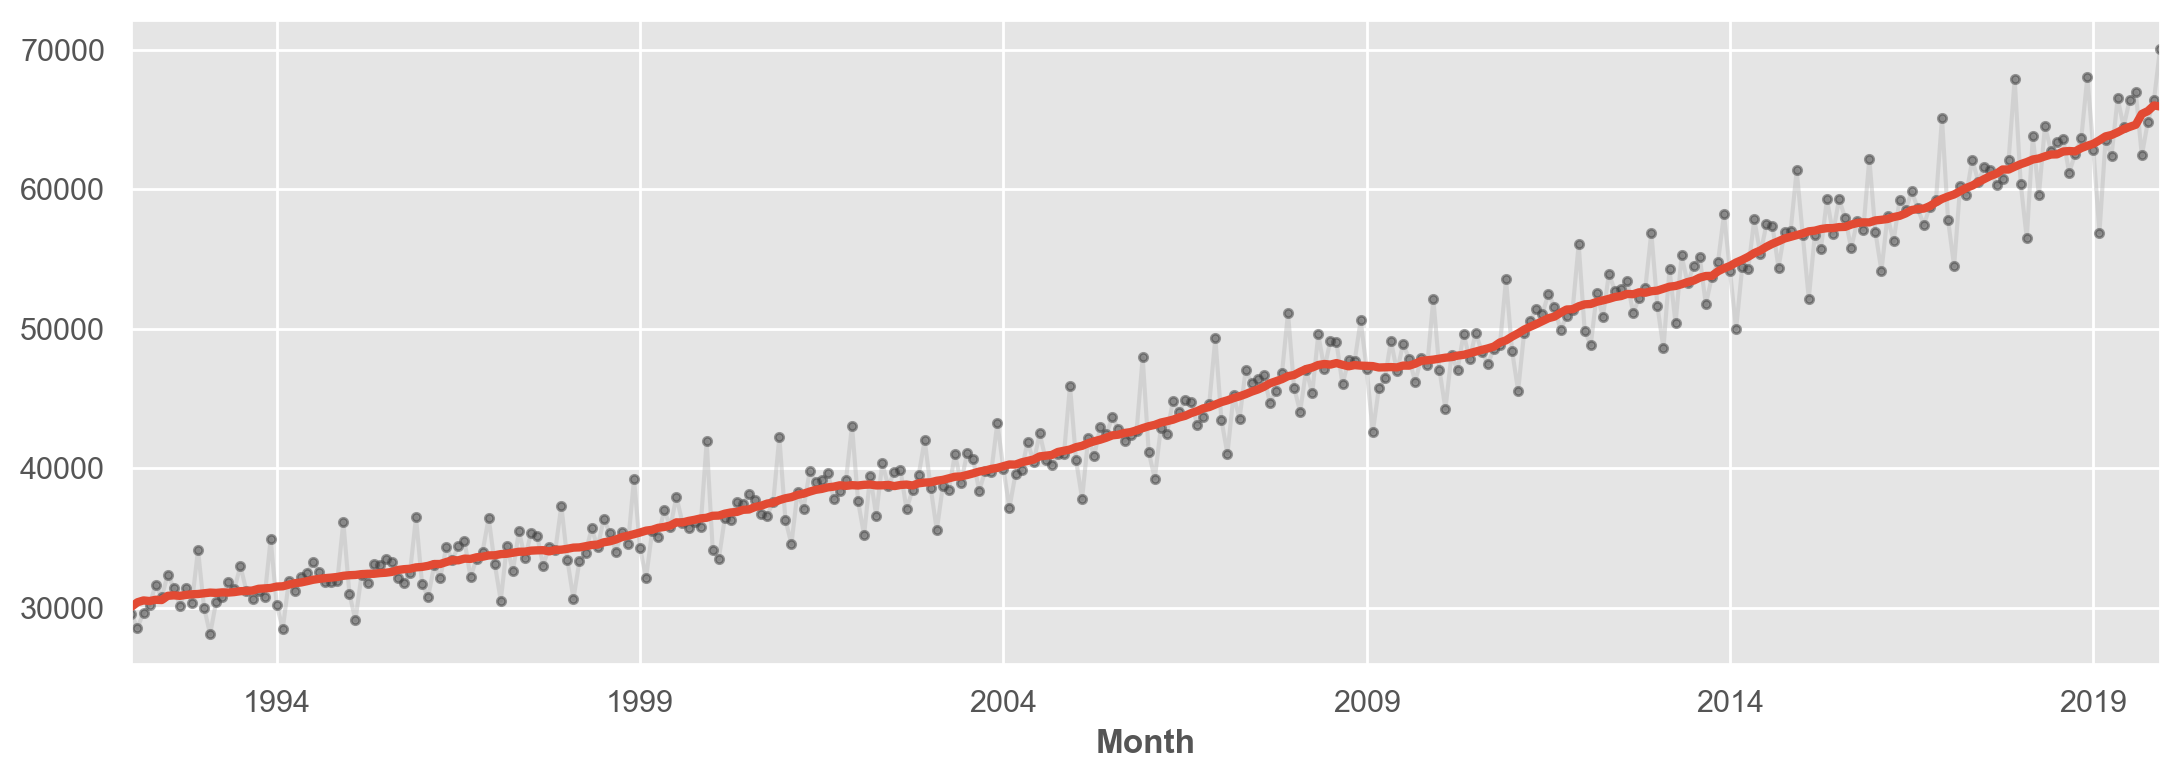

In [23]:
trand = food_sales.rolling(
    window = 12,
    center = True,
    min_periods = 6).mean()
ax = food_sales.plot(**plot_params, alpha = 0.5)
ax = trand.plot(ax = ax, linewidth = 3)

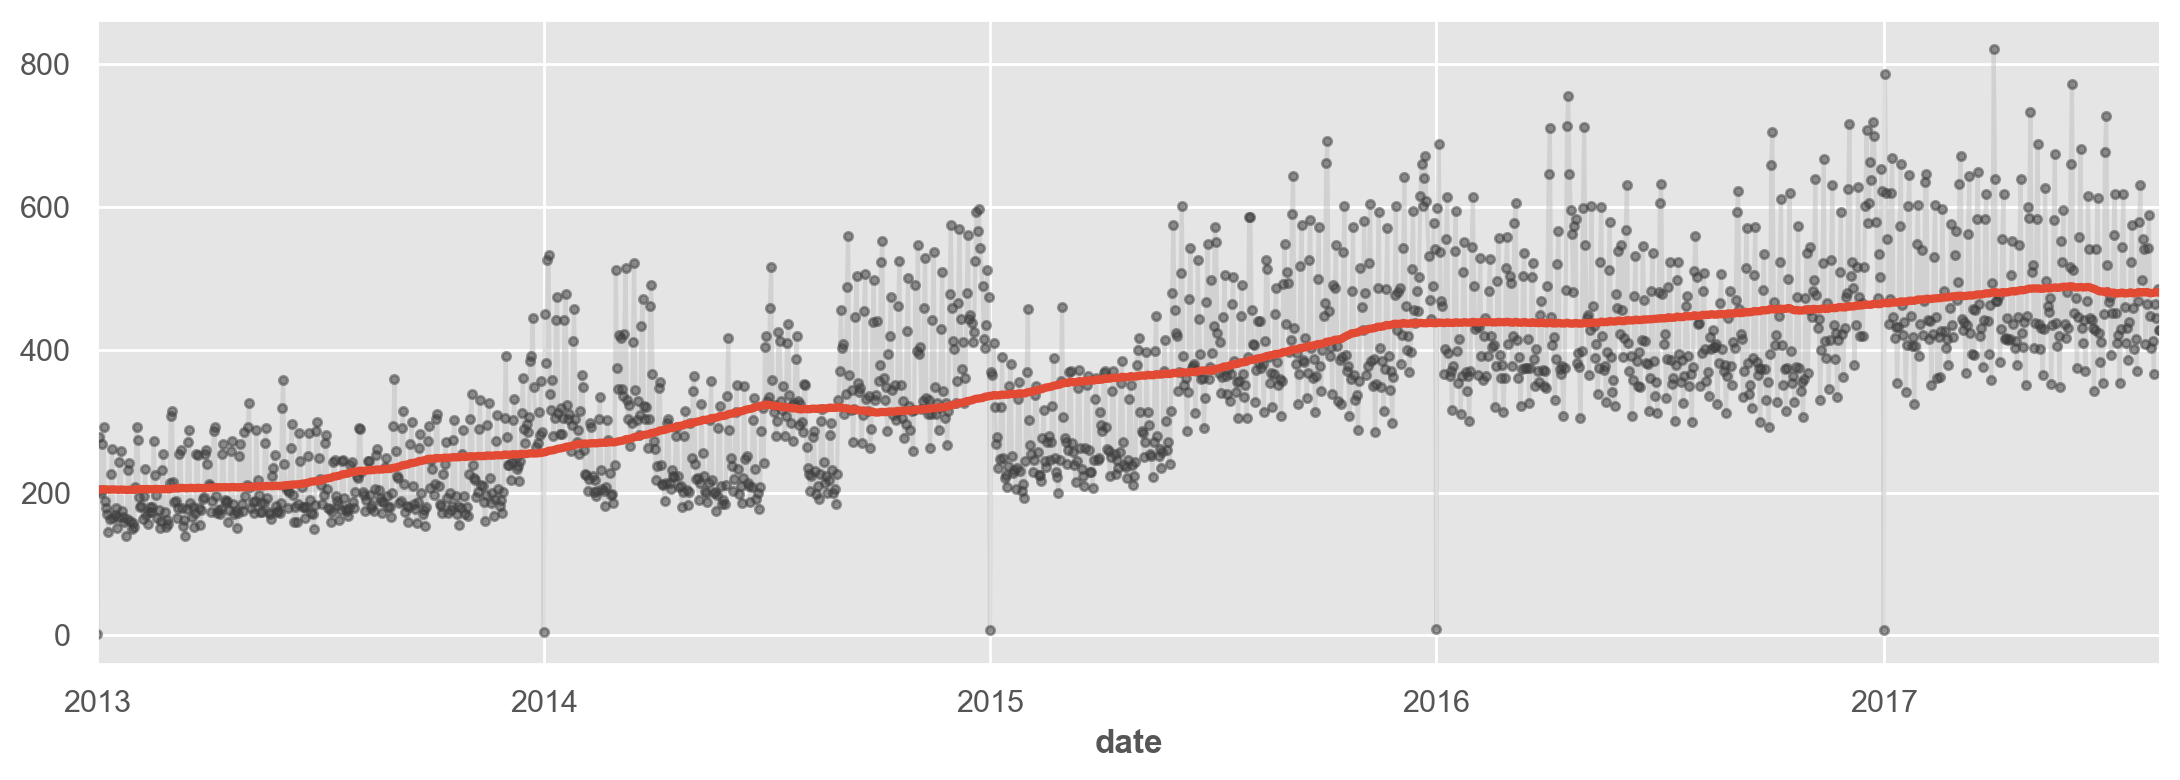

In [24]:
trand = average_sales.rolling(
    window = 365, 
    min_periods = 183, 
    center = True).mean()
ax = average_sales.plot(**plot_params, alpha = 0.5)
ax = trand.plot(ax = ax, linewidth = 3)

Create trand features 

In [25]:
y = average_sales.copy()

dp = DeterministicProcess(
    index = average_sales.index,
    order = 3)

X = dp.in_sample()
X_fore = dp.out_of_sample(90)

In [26]:
model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index = X.index)
y_fore = pd.Series(model.predict(X_fore), index = X_fore.index)

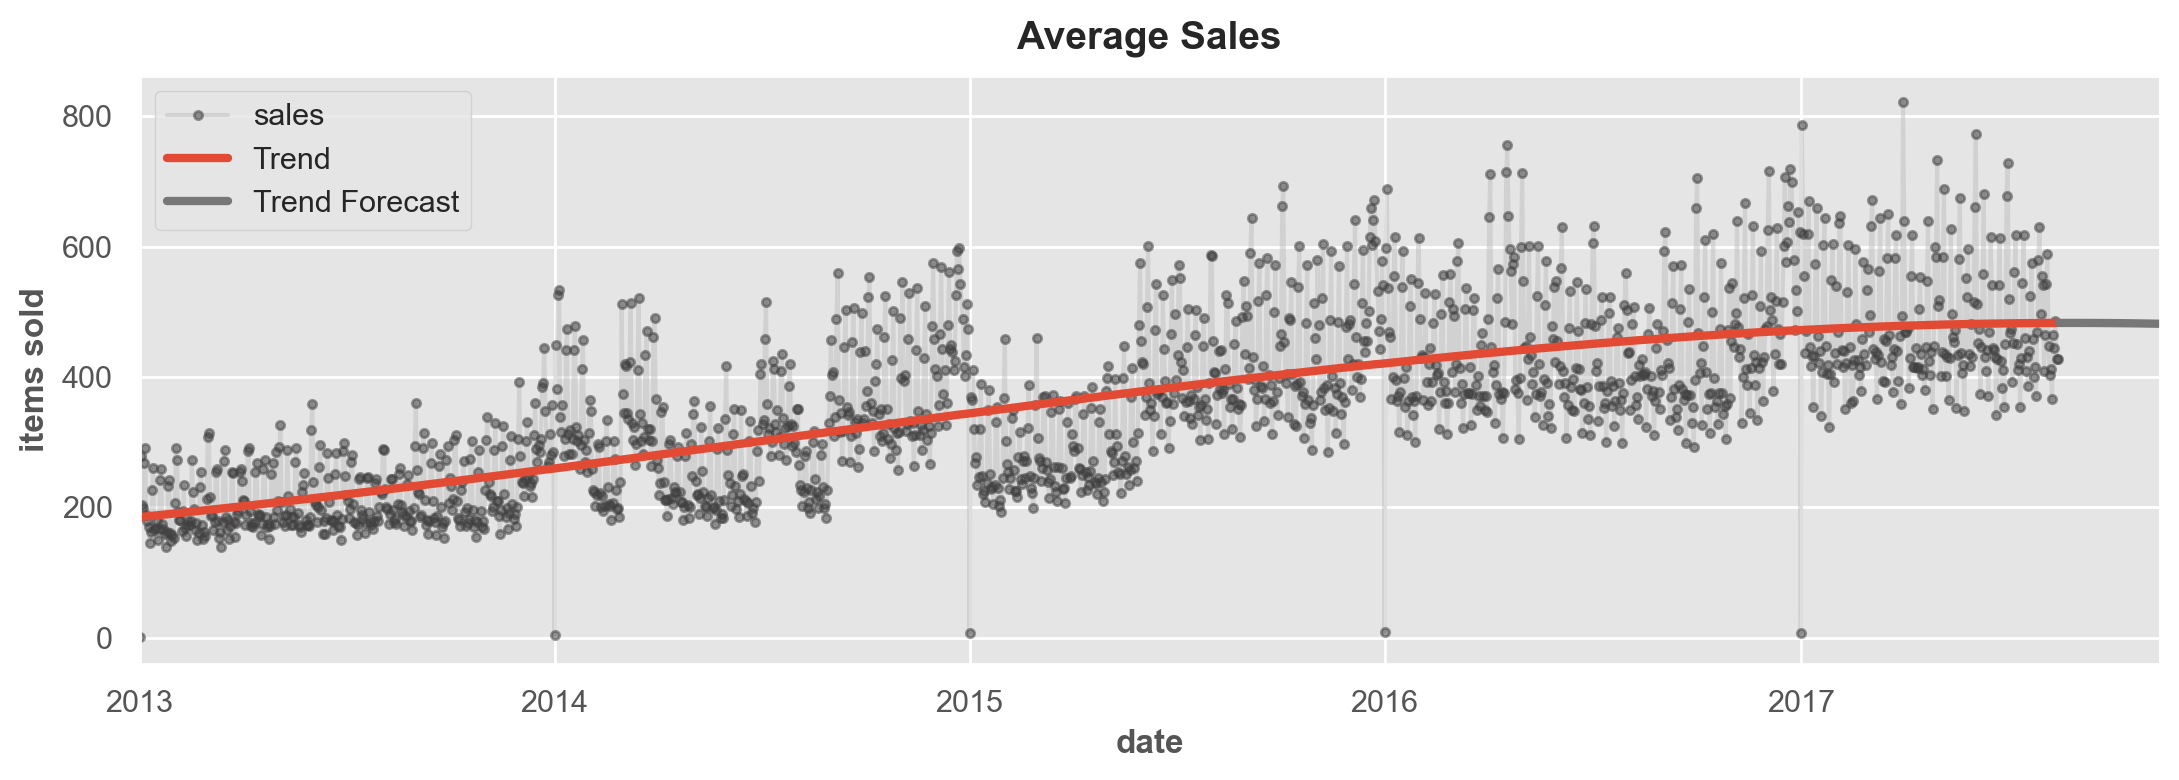

In [27]:
ax = y.plot(**plot_params, alpha = 0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax = ax, linewidth = 3, label="Trend", color='C0')
ax = y_fore.plot(ax = ax, linewidth = 3, label="Trend Forecast", color ='C3')
ax.legend();

# Сезонность

Временной ряд демонстрирует сезонность всякий раз, когда происходит регулярное изменение среднего значения ряда. Сезонные изменения обычно происходят в соответствии с часами и календарем - обычно они повторяются в течение дня, недели или года. Сезонность часто обусловлена циклами природы, протекающими в течение нескольких дней и лет, или условностями социального поведения, связанными с датами и временем

Виды функций, моделирующие сезонность.

Первый вид, **индикаторы**, лучше всего подходит для сезона с небольшим количеством наблюдений, например, еженедельного сезона ежедневных наблюдений. Второй вид, **функции Фурье**, лучше всего подходит для сезона с большим количеством наблюдений, например, ежегодного сезона ежедневных наблюдений.

**График сезонности**

Сезонный график показывает сегменты временного ряда, построенные по отношению к некоторому общему периоду, причем этот период является "сезоном", который вы хотите наблюдать

**Сезонные индикаторы** - это бинарные характеристики, которые представляют сезонные различия в уровне временного ряда. Сезонные индикаторы - это то, что вы получаете, если рассматриваете сезонный период как категориальный признак

In [28]:
simplefilter("ignore")
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,  
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    return ax

**Функции Фурье** лучше подходят для длительных сезонов, когда многие наблюдения показывают, что индикаторы были бы непрактичными. Вместо того, чтобы создавать функцию для каждой даты, функции Фурье пытаются отобразить общую форму сезонной кривой с помощью всего нескольких функций.
Идея состоит в том, чтобы включить в наши обучающие данные периодические кривые, имеющие те же частоты, что и сезон, который мы пытаемся смоделировать

Как итог, после обучения, получаем **какое то колличество пар** синусов и косинусов с коэффициентами регрессии. В сумме эти кривые будут приближать сезонность исходного временного ряда. Почему это работает? Скорее всего, все завязано на преобразовании Фурье ( на разложение исходного, сложного сигнала на простые составляющие (синус и косинус разной частоты и с разными коэффициентами)

Сколько пар Фурье мы должны включить в наш набор функций? Мы можем ответить на этот вопрос с помощью **периодограммы**. Периодограмма показывает силу частот во временном ряду

In [29]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Что такое сила частот? Не особо понятно. Из другой литературы прочитал, что Периодограмма - функция которая возвращает квадраты коэффициентов ряда Фурье в зависимости от частоты, которые че то там показывают. (Влияние конкретных частот на ряд). Это очень утрированно и может быть даже не правильно ._.

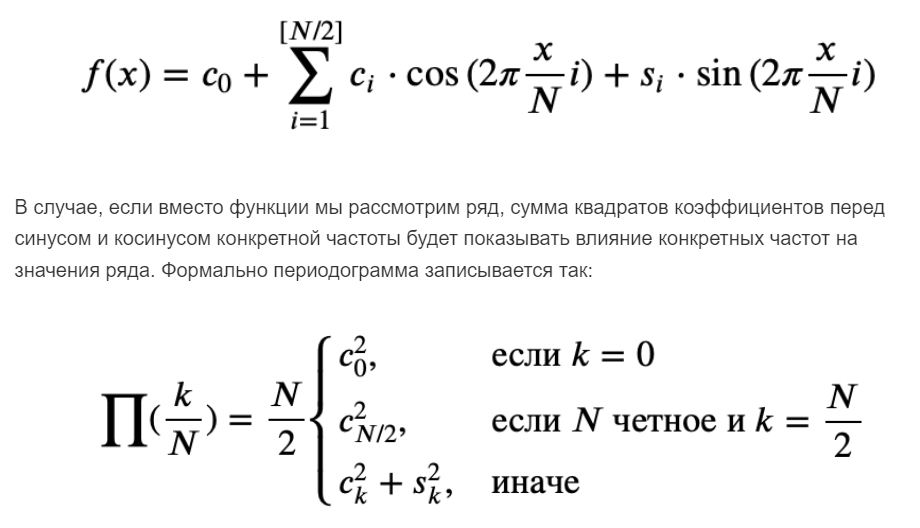

Или так

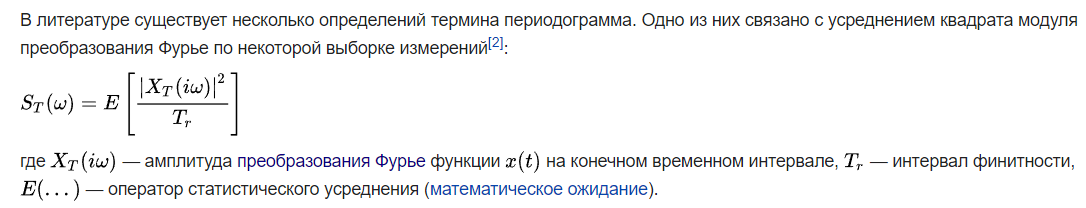

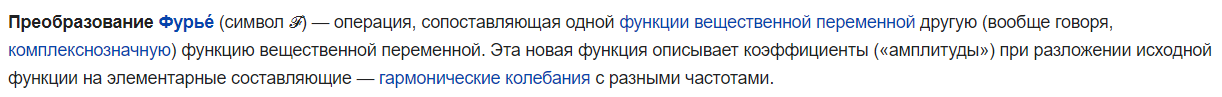

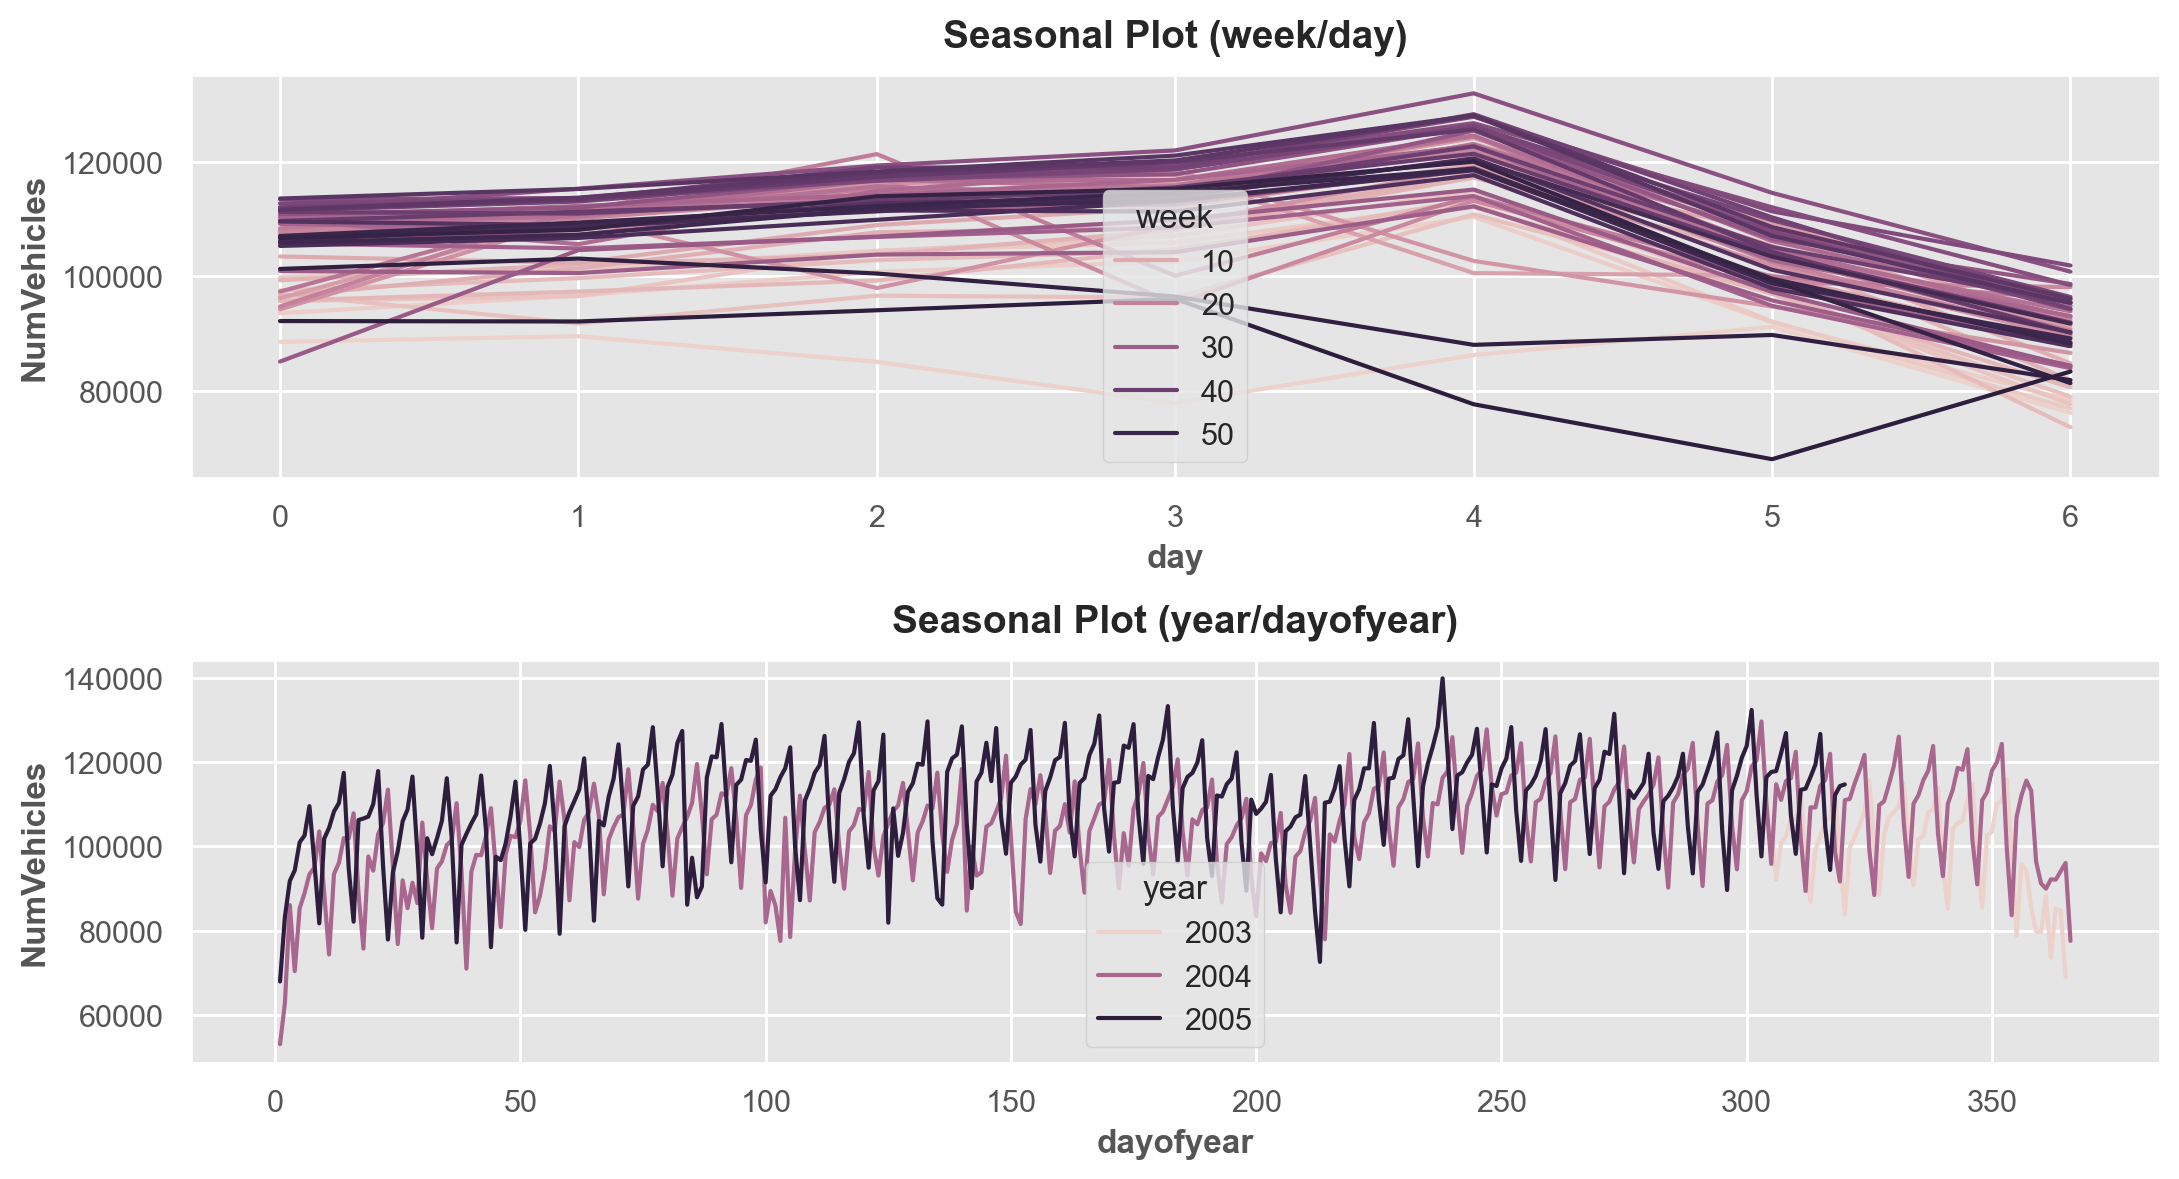

In [30]:
#tunnel
X = tunnel.copy()
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

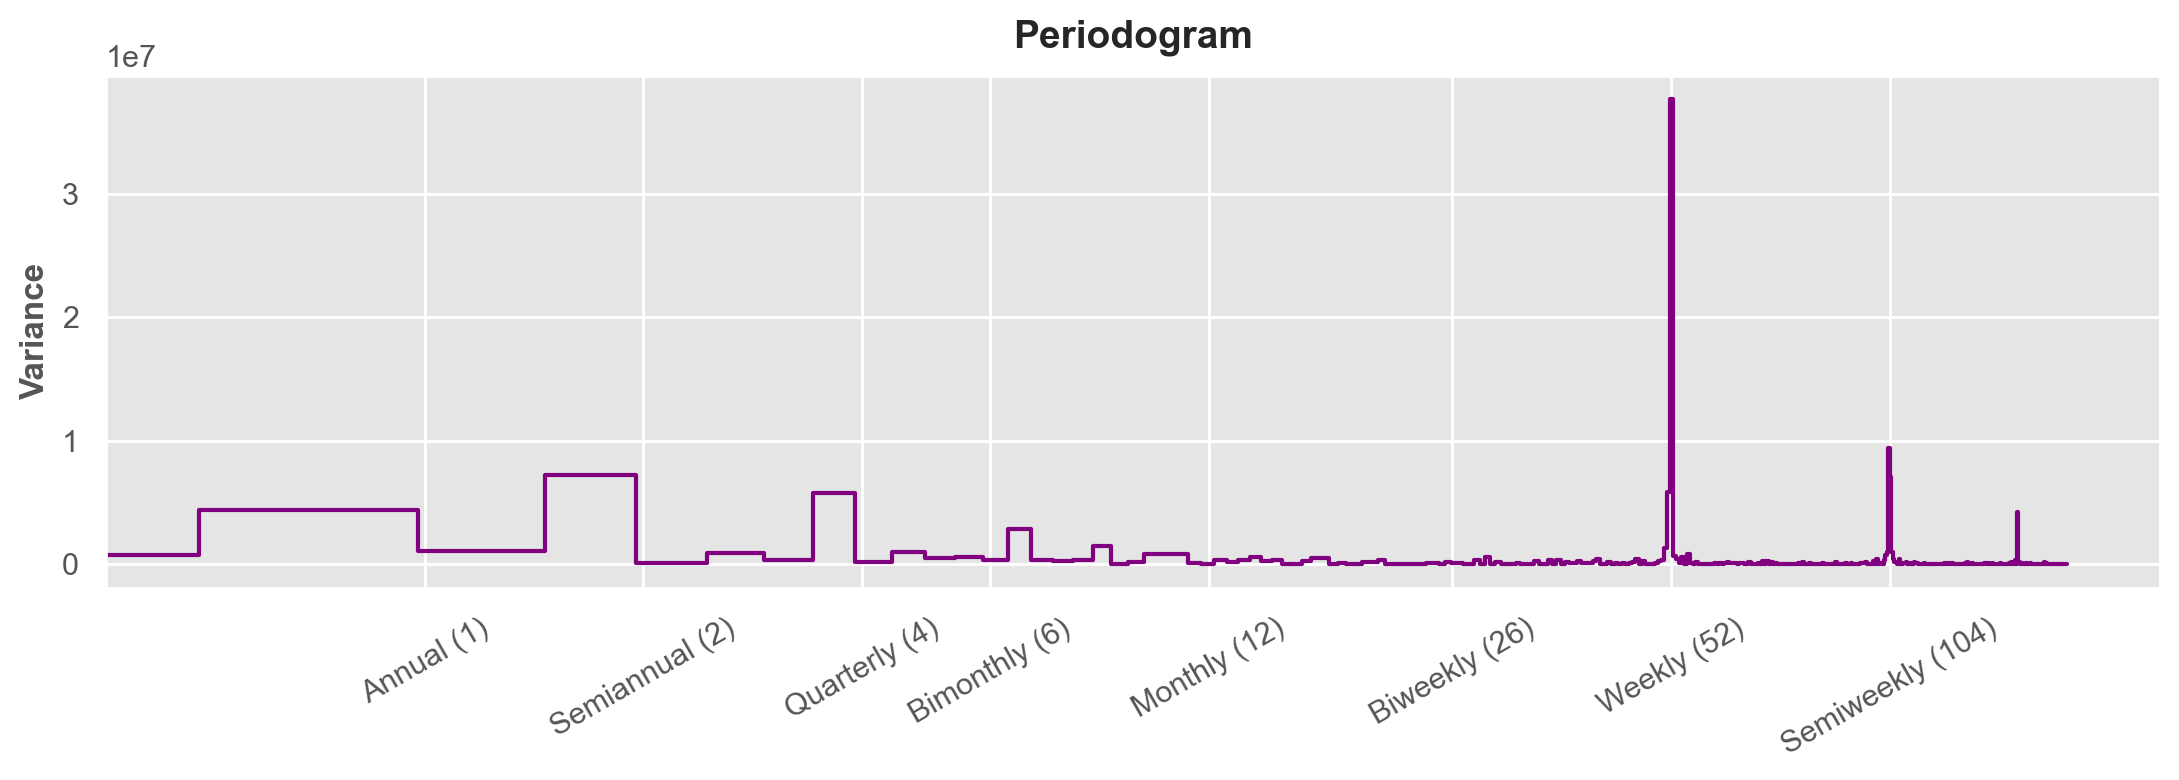

In [31]:
plot_periodogram(tunnel.NumVehicles);

In [32]:


fourier = CalendarFourier(freq = 'A', order = 10) # Создаем функции фурье. Синусы и косинусы разных частот

dp = DeterministicProcess(
    index = tunnel.index,
    constant = True,
    order = 1,
    seasonal = True,  # Создаются сезонные индикаторы с помощью One-Hot-Encoding
    additional_terms = [fourier],
    drop = True)

X = dp.in_sample()

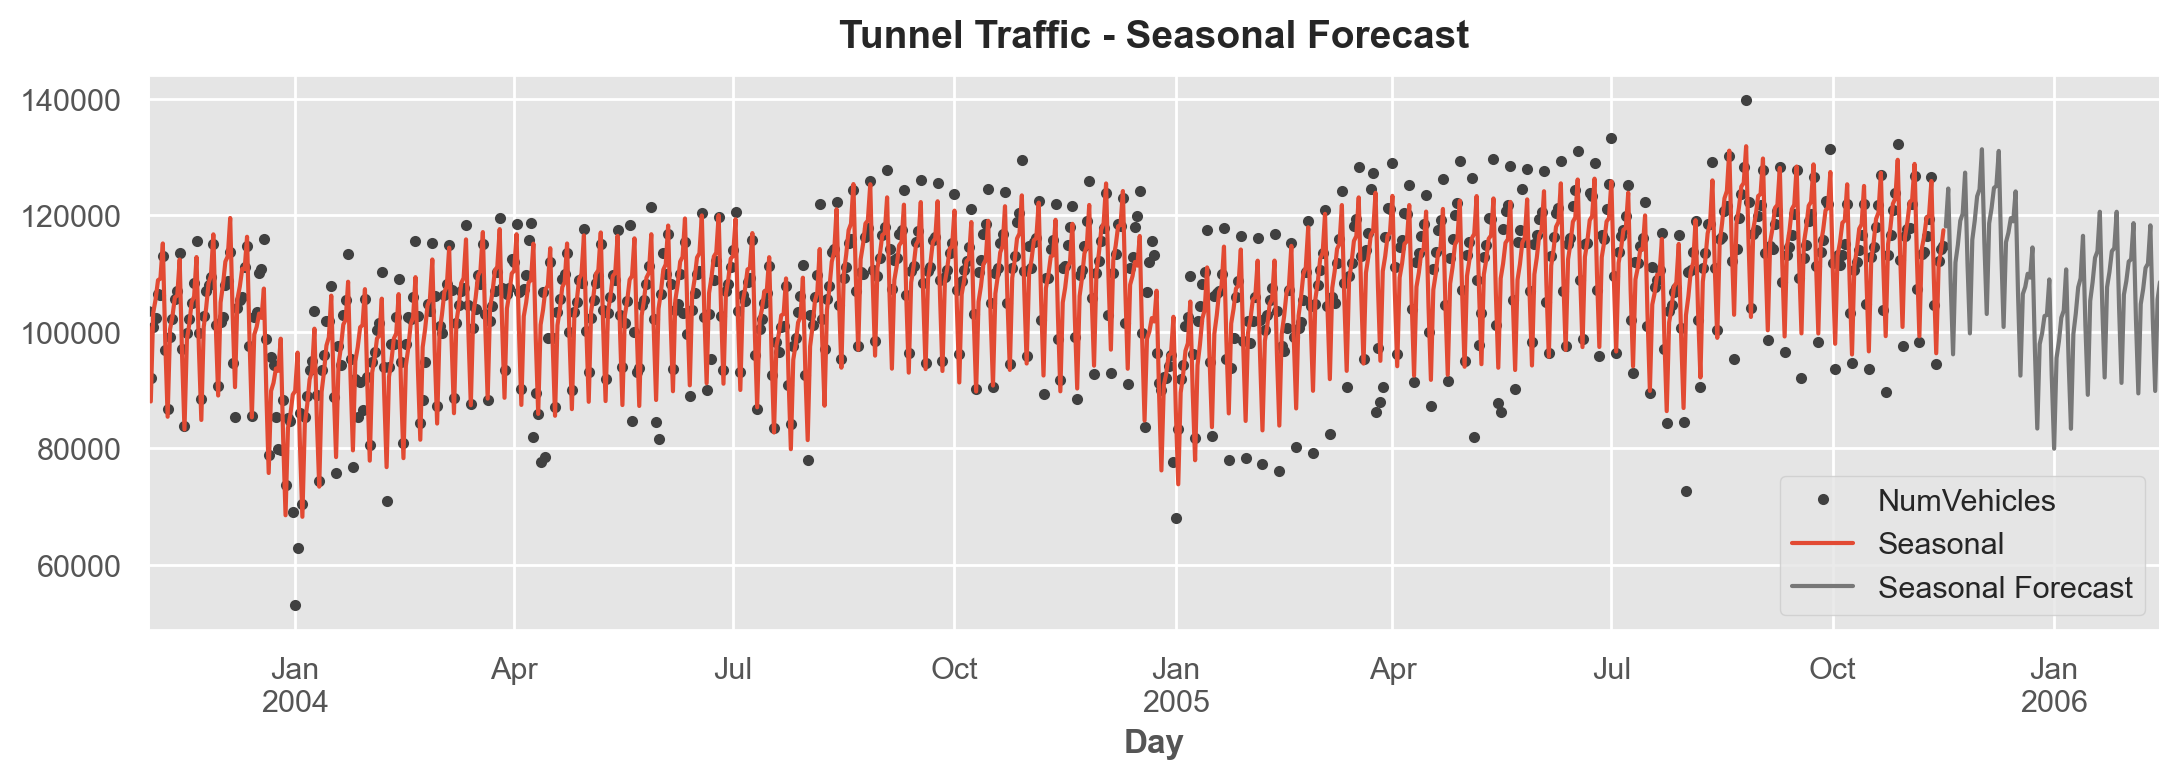

In [33]:
y = tunnel["NumVehicles"]
model = LinearRegression(fit_intercept = False)
_ = model.fit(X,y)
y_pred = pd.Series(model.predict(X), index= X.index)
X_fore = dp.out_of_sample(steps = 90)
y_fore = pd.Series(model.predict(X_fore), index= X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

Задания

In [34]:
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')



store_sales = pd.read_csv(
    train_file_path,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

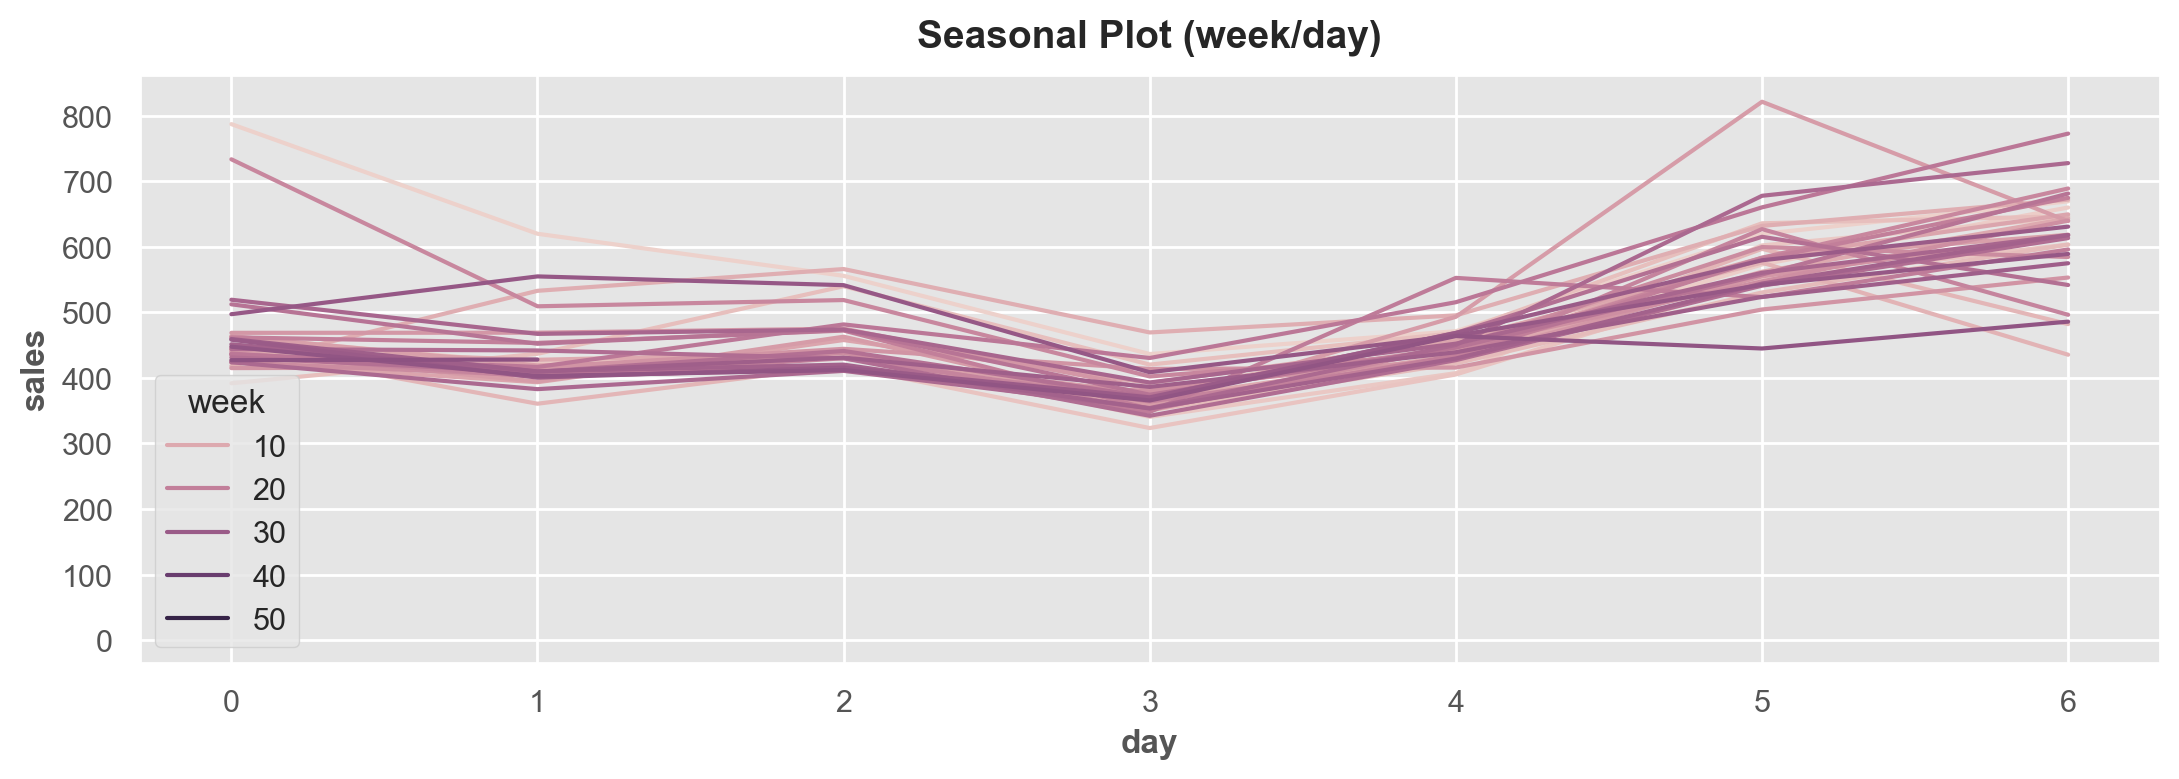

In [35]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

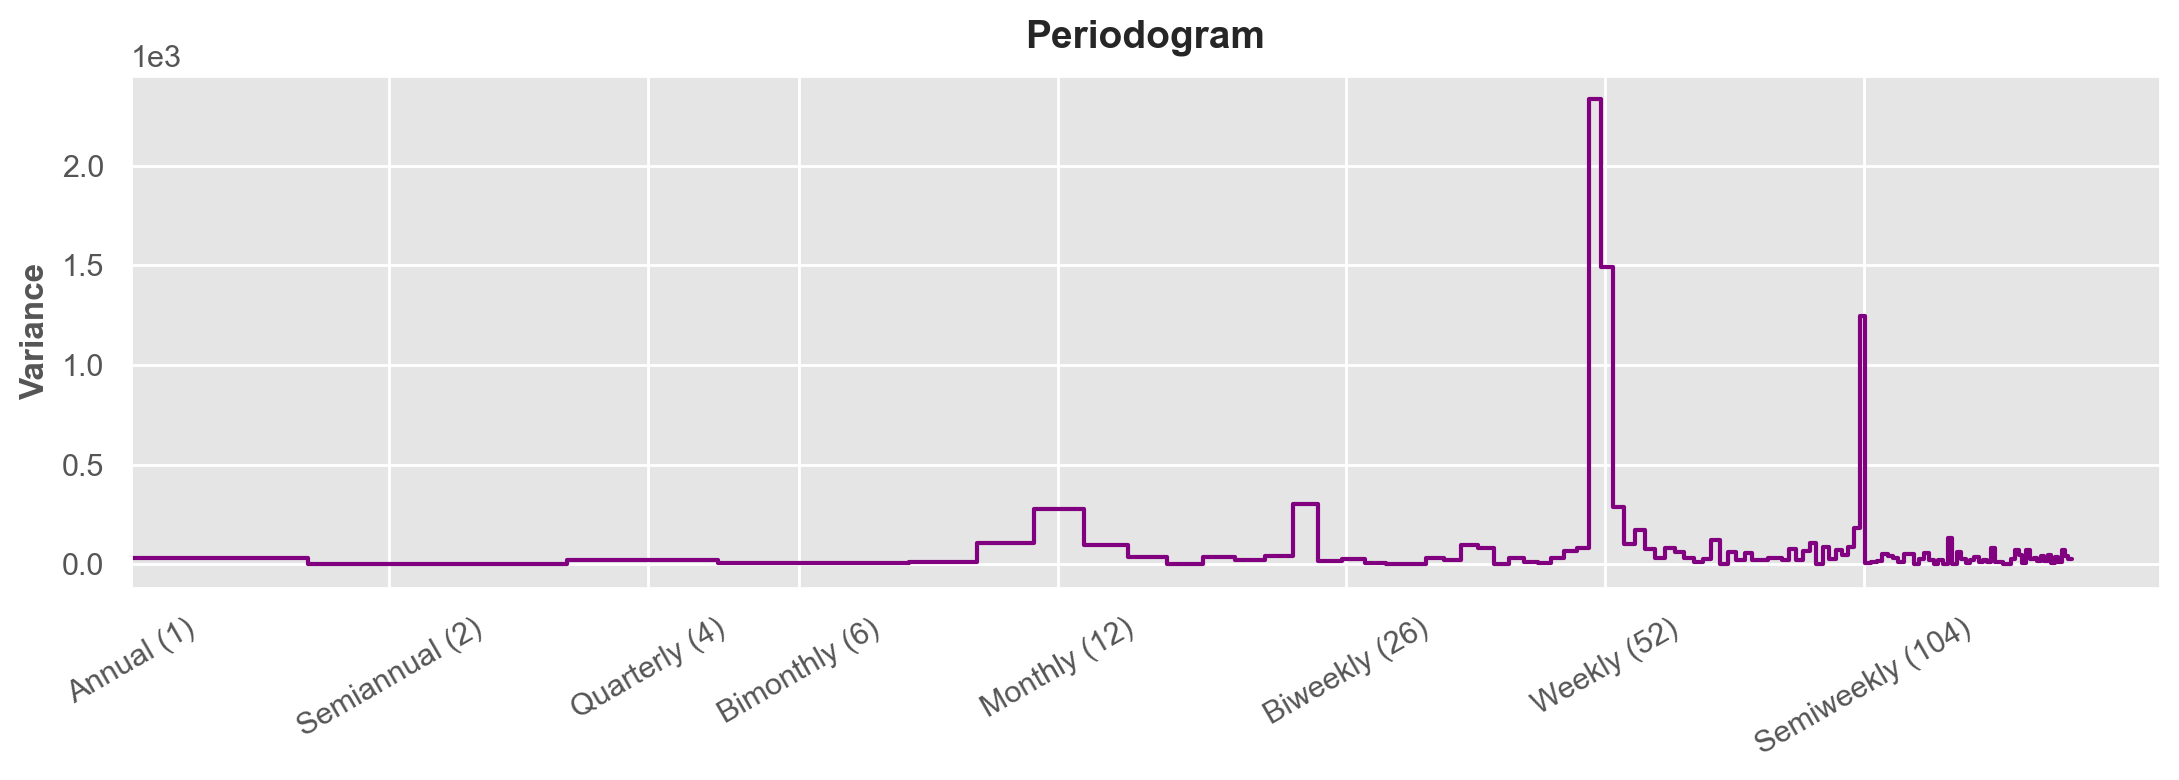

In [36]:
plot_periodogram(average_sales);

In [37]:
y = average_sales.copy()

fourier = CalendarFourier('M', order = 4)

dp = DeterministicProcess(
    index = y.index,
    constant = True,
    seasonal = True, # Create indicators (One-hot-encoding for day of week)
    order = 1,
    additional_terms = [fourier],
    drop = True)

X = dp.in_sample()

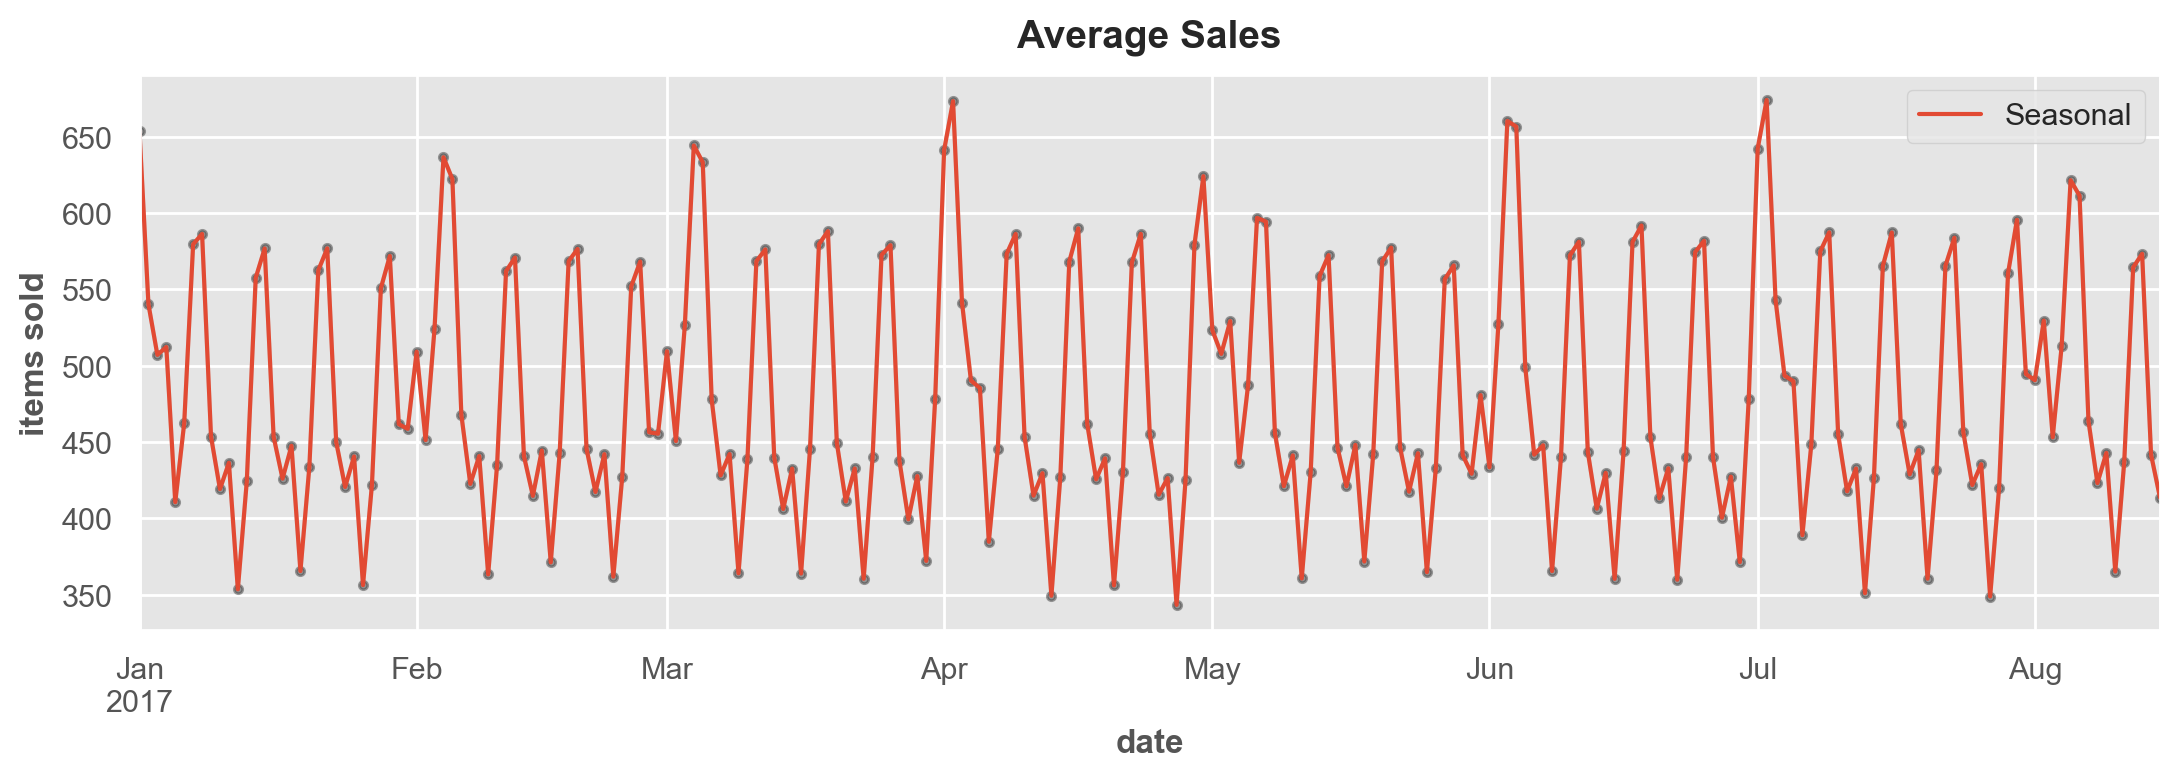

In [38]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y_pred.plot(**plot_params, alpha = 0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Удаление сезонности

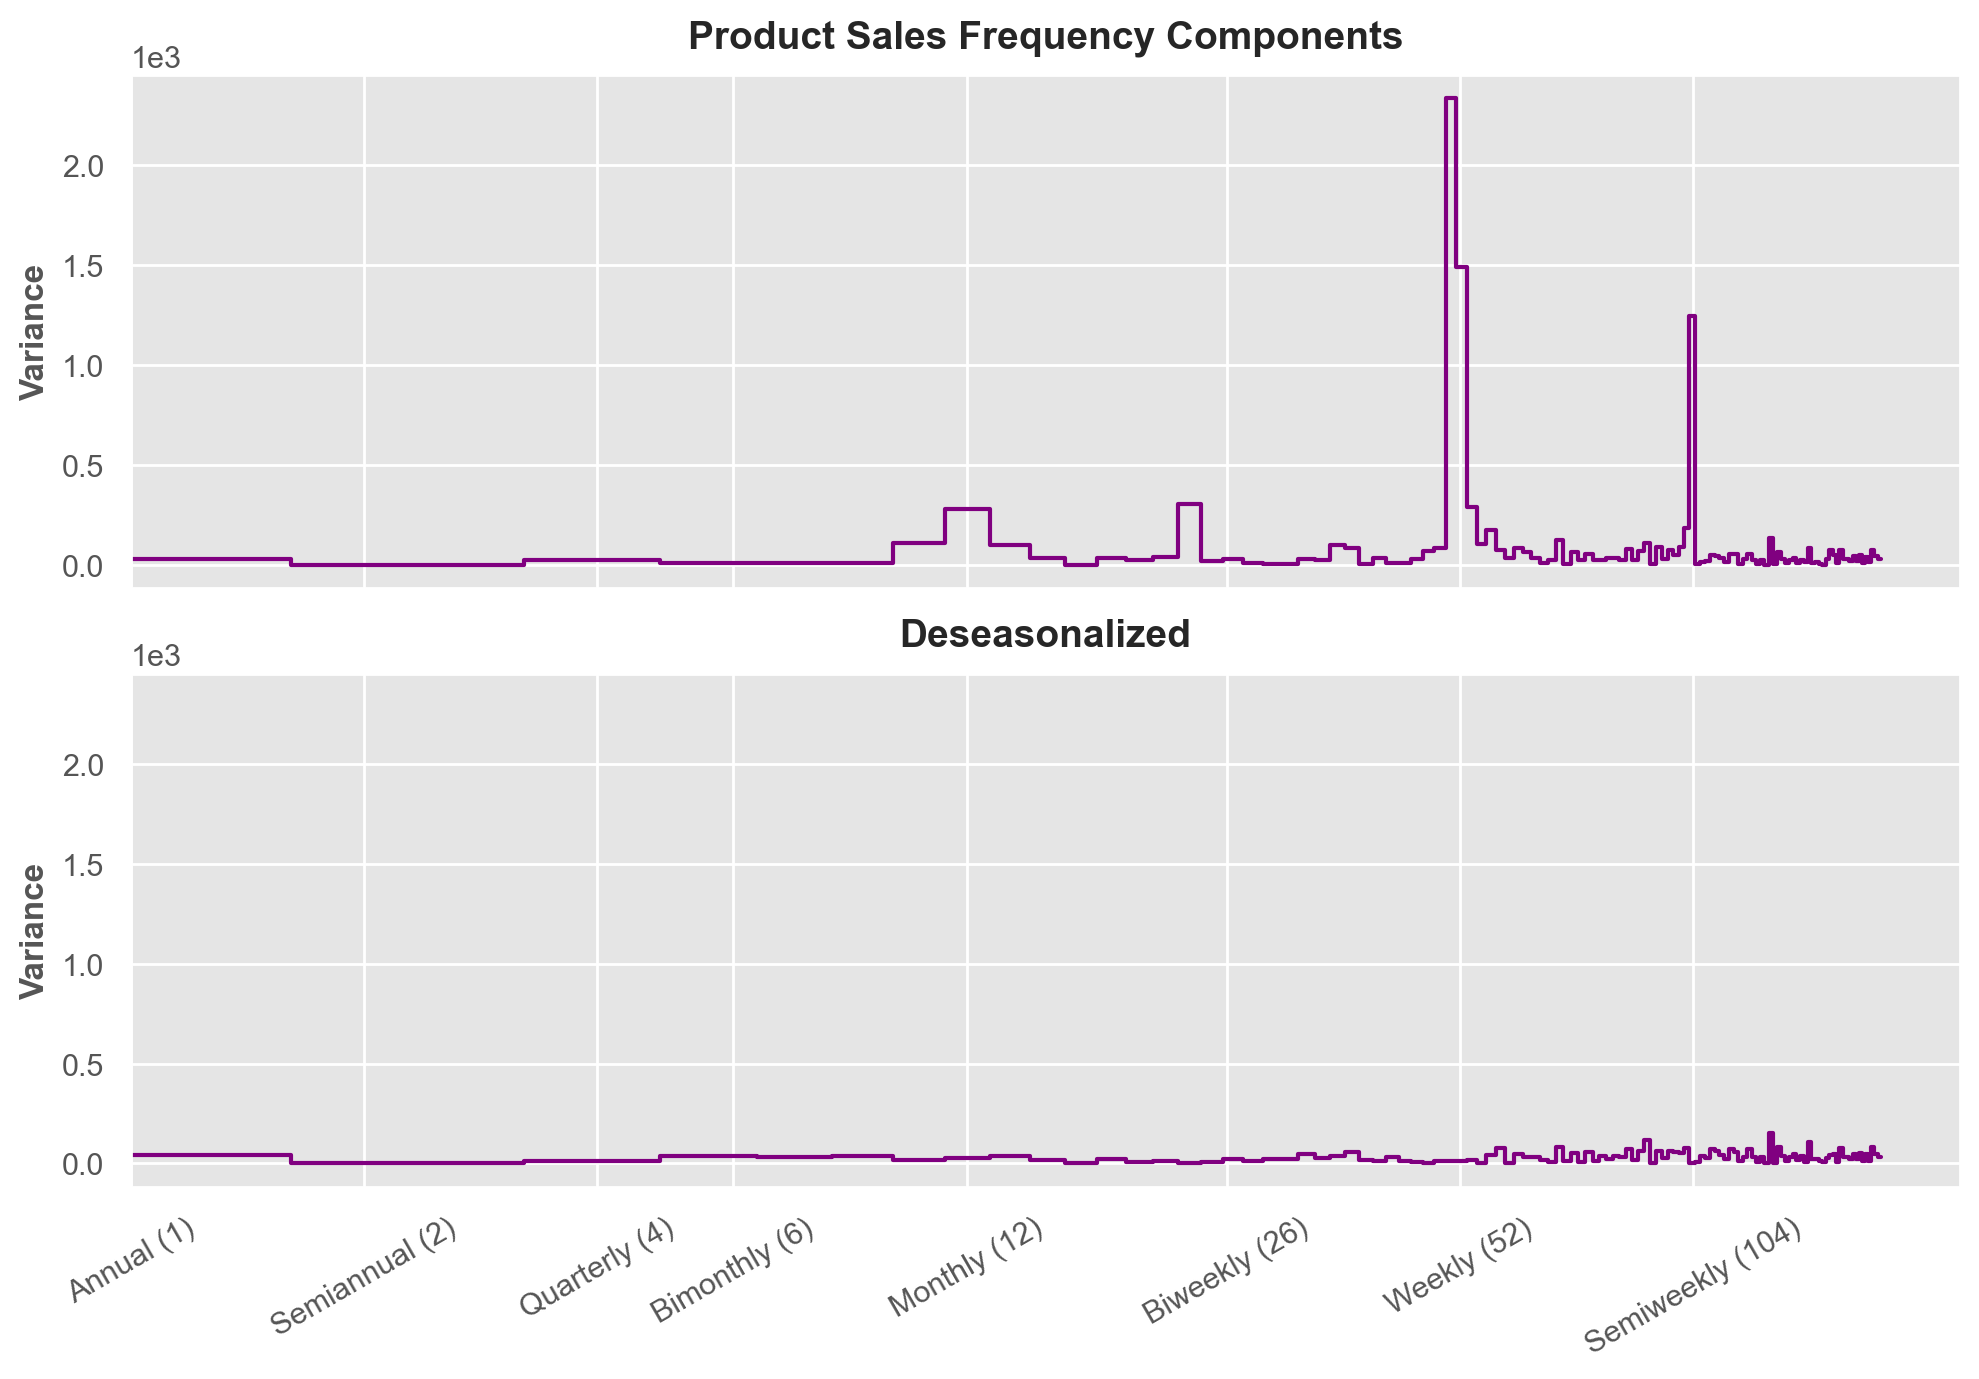

In [39]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

The Store Sales dataset includes a table of Ecuadorian holidays.

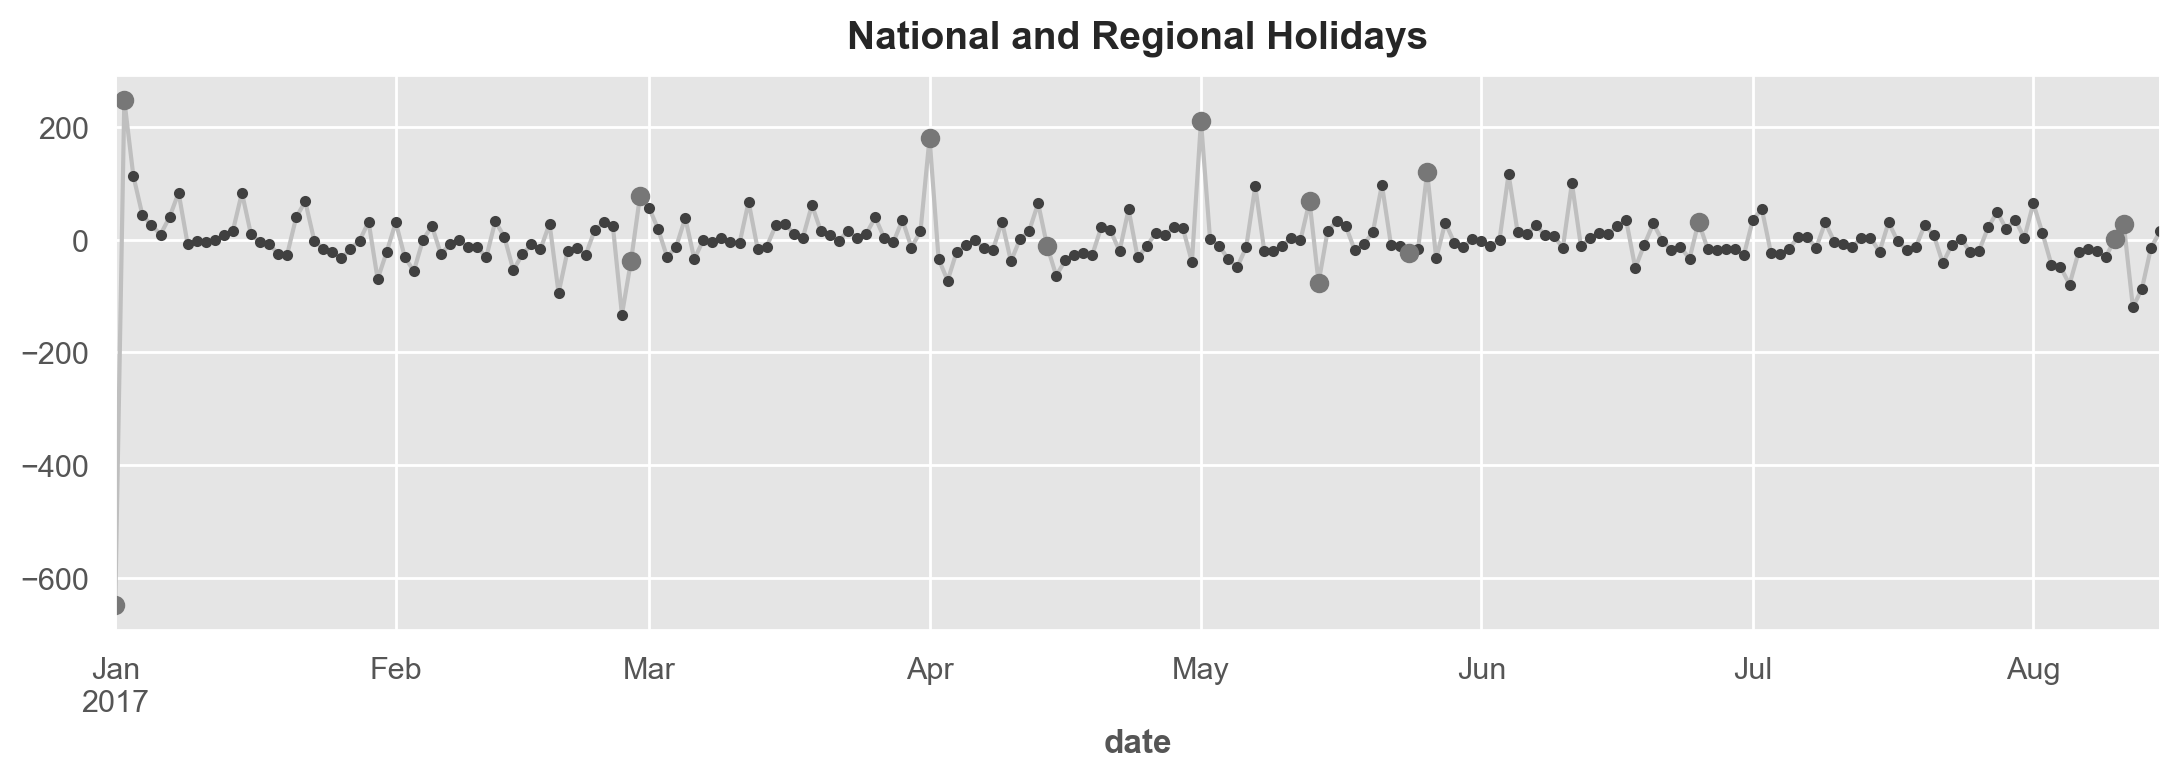

In [40]:
holidays = (
    holidays_events.query('locale in ["National", "Regional"]')
    .loc['2017':'2017-08-15', ['description']]
    .assign(description = lambda x: x.description.cat.remove_unused_categories()))

ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [41]:
X_holidays = pd.get_dummies(holidays).astype(int)
X2 = X.join(X_holidays, on = 'date').fillna(0.0)

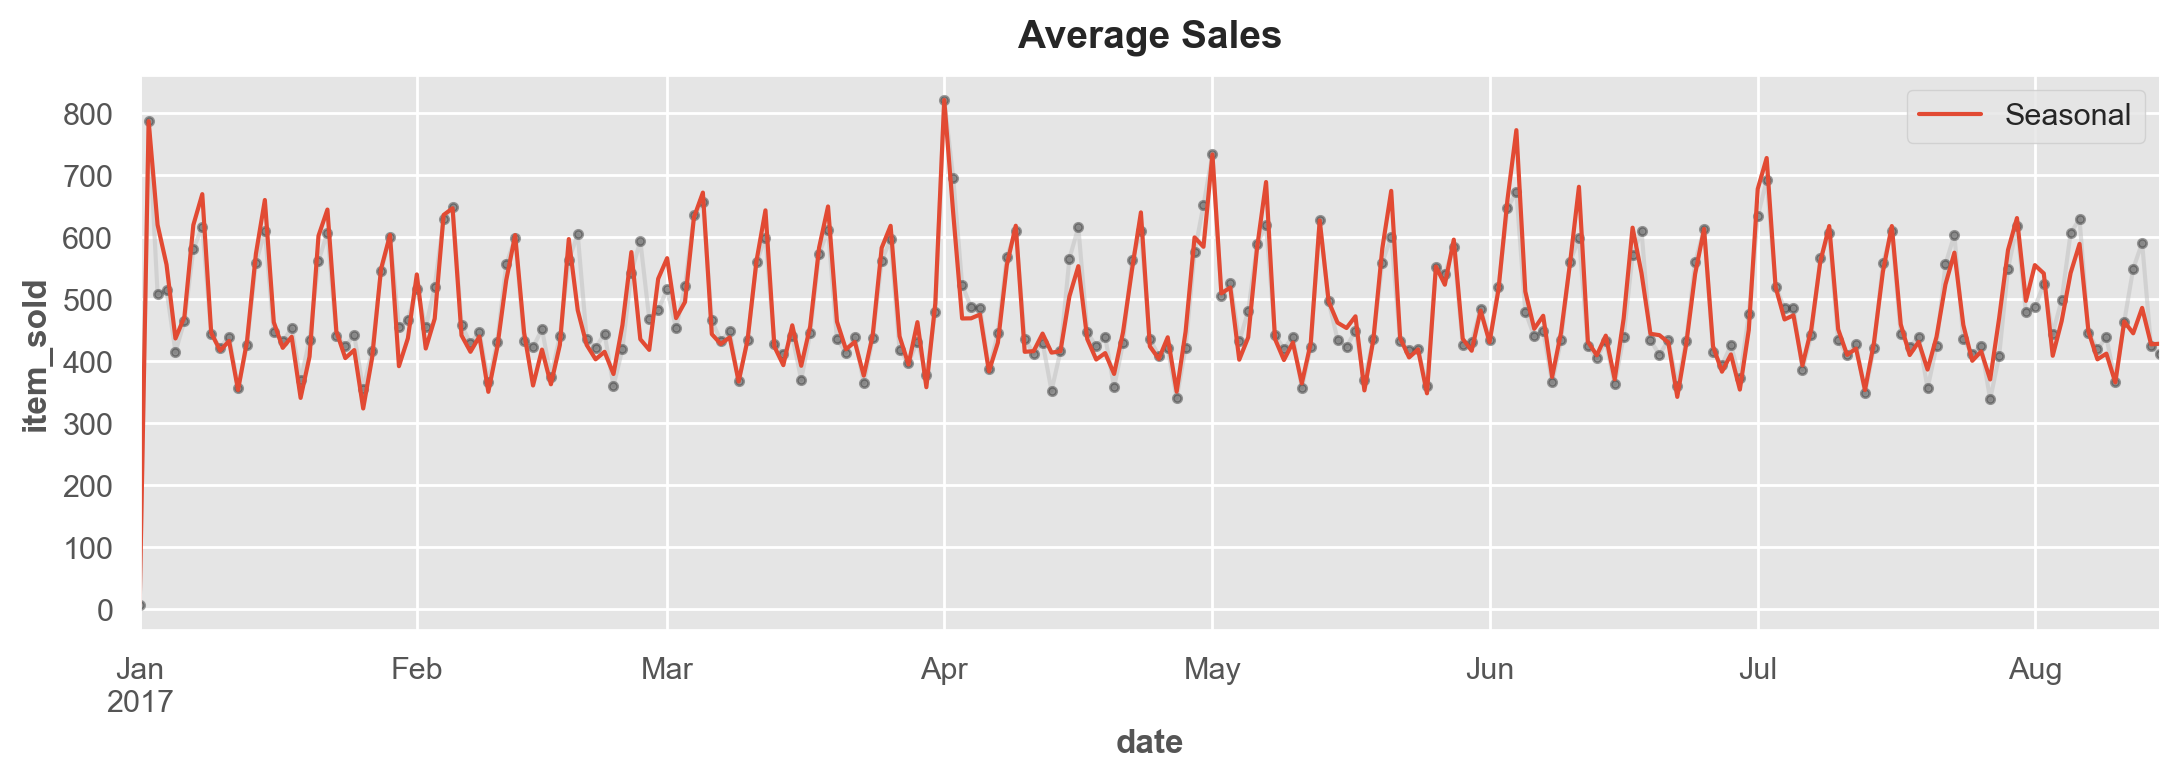

In [42]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(model.predict(X2), index = X.index)
ax = y_pred.plot(**plot_params, alpha = 0.5, title = 'Average Sales', ylabel = 'item_sold')
ax = y.plot(ax= ax, label = 'Seasonal')
ax.legend();

# Submit to Kaggle

In [43]:
y = store_sales.unstack(['store_nbr', 'family']).loc['2017']
fourier = CalendarFourier(freq ='M', order = 4)
dp = DeterministicProcess(
    index = y.index,
    constant = True,
    seasonal = True,
    order = 1,
    additional_terms = [fourier],
    drop = True)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1) # ??
model = LinearRegression(fit_intercept = False).fit(X,y)
y_preds = pd.DataFrame(model.predict(X), index = y.index, columns = y.columns)

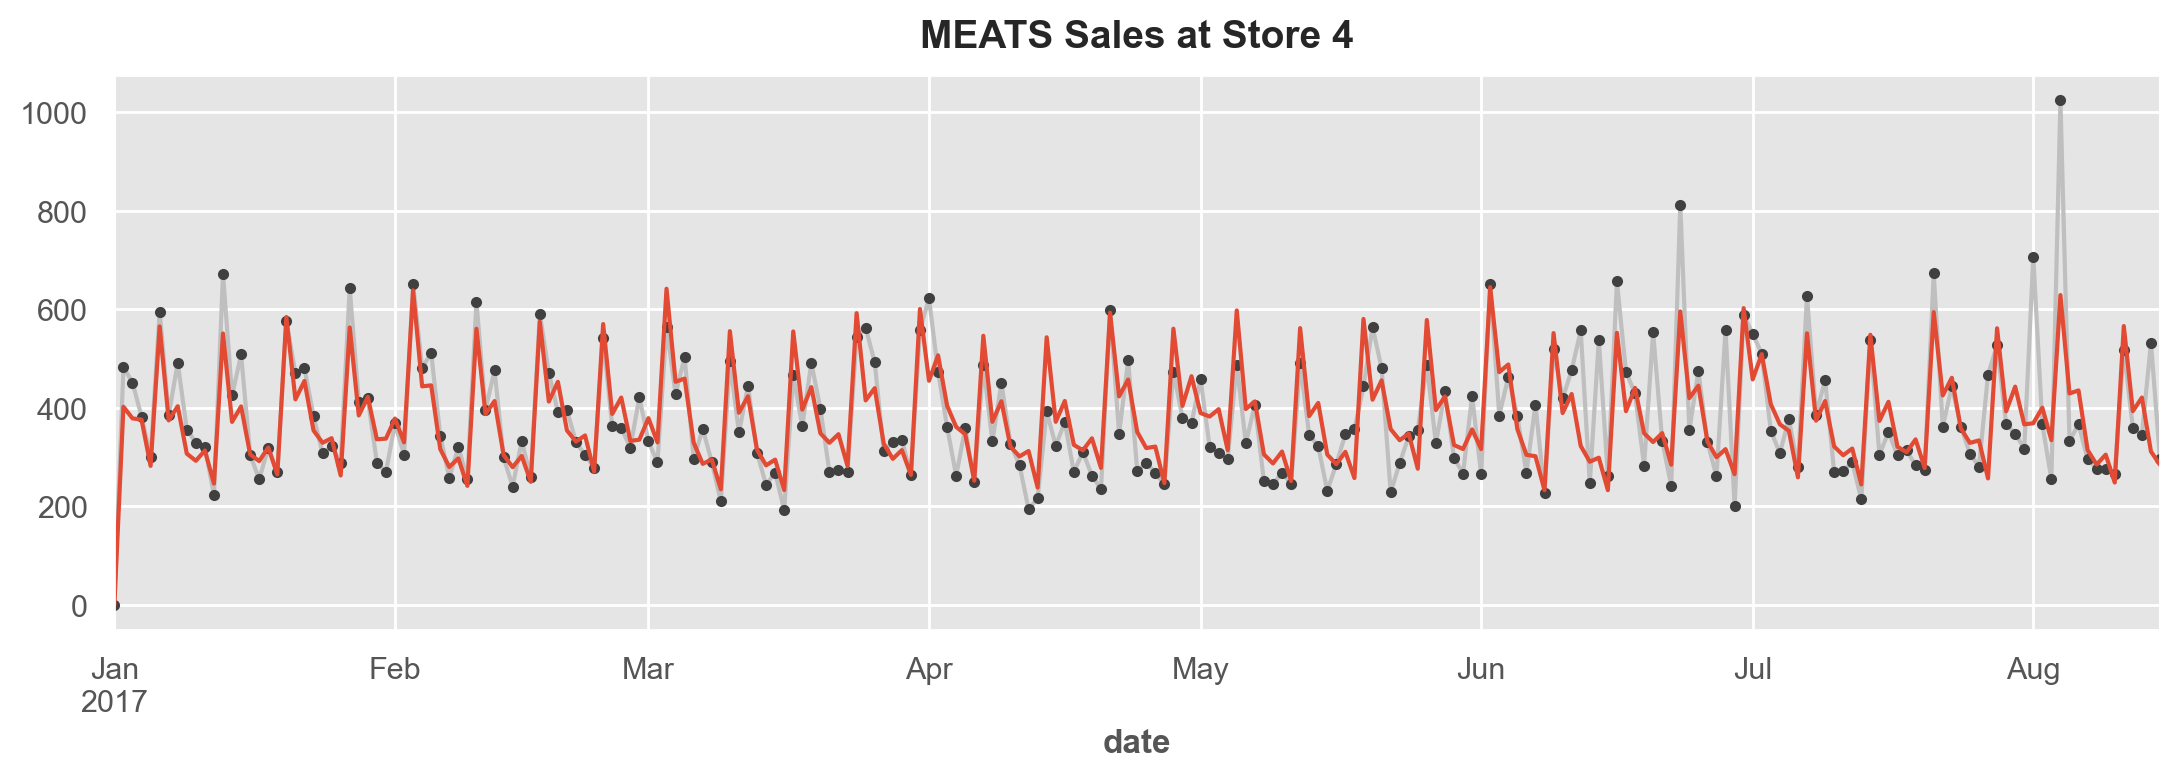

In [44]:
# for family in store_sales.index.get_level_values('family').unique():
#     print(family)
    
STORE_NBR = '4'
FAMILY = 'MEATS'
ax = y.loc(axis = 1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_preds.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [45]:
for file in comp_dir.iterdir():
    print(file.name)

.ipynb_checkpoints
holidays_events.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv.zip
transactions.csv.zip


In [46]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [47]:
X_test = dp.out_of_sample(steps = 16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)
y_submit = pd.DataFrame(model.predict(X_test), index = X_test.index, columns = y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id)
y_submit

sales       id
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                     4.274030  3000888
                     BABY CARE                      0.000000  3000889
                     BEAUTY                         3.495530  3000890
                     BEVERAGES                   2414.541711  3000891
                     BOOKS                          0.438314  3000892
...                                                      ...      ...
2017-08-31 9         POULTRY                      372.417153  3029395
                     PREPARED FOODS               107.843530  3029396
                     PRODUCE                     1273.316507  3029397
                     SCHOOL AND OFFICE SUPPLIES    44.945937  3029398
                     SEAFOOD                       18.946715  3029399

[28512 rows x 2 columns]

In [48]:
y_submit.to_csv('Store_sales_submission.csv', index = False)

# Временные ряды как признаки

Теперь хотям изучать зависимость от последовательности, а не от времени

Проявление последовательной зависимости - **циклы**. **Циклы** - это закономерности роста и затухания во временном ряду, связанные с тем, как значение в ряду в определенный момент времени зависит от значений в предыдущие моменты времени, но не обязательно от самого временного шага.

**Цикличность и Сезонность**. 

Цикличность не зависит от времен года. Имеется зависимость от того, что происходило в недавнем прошлом, в не зависимоти от даты

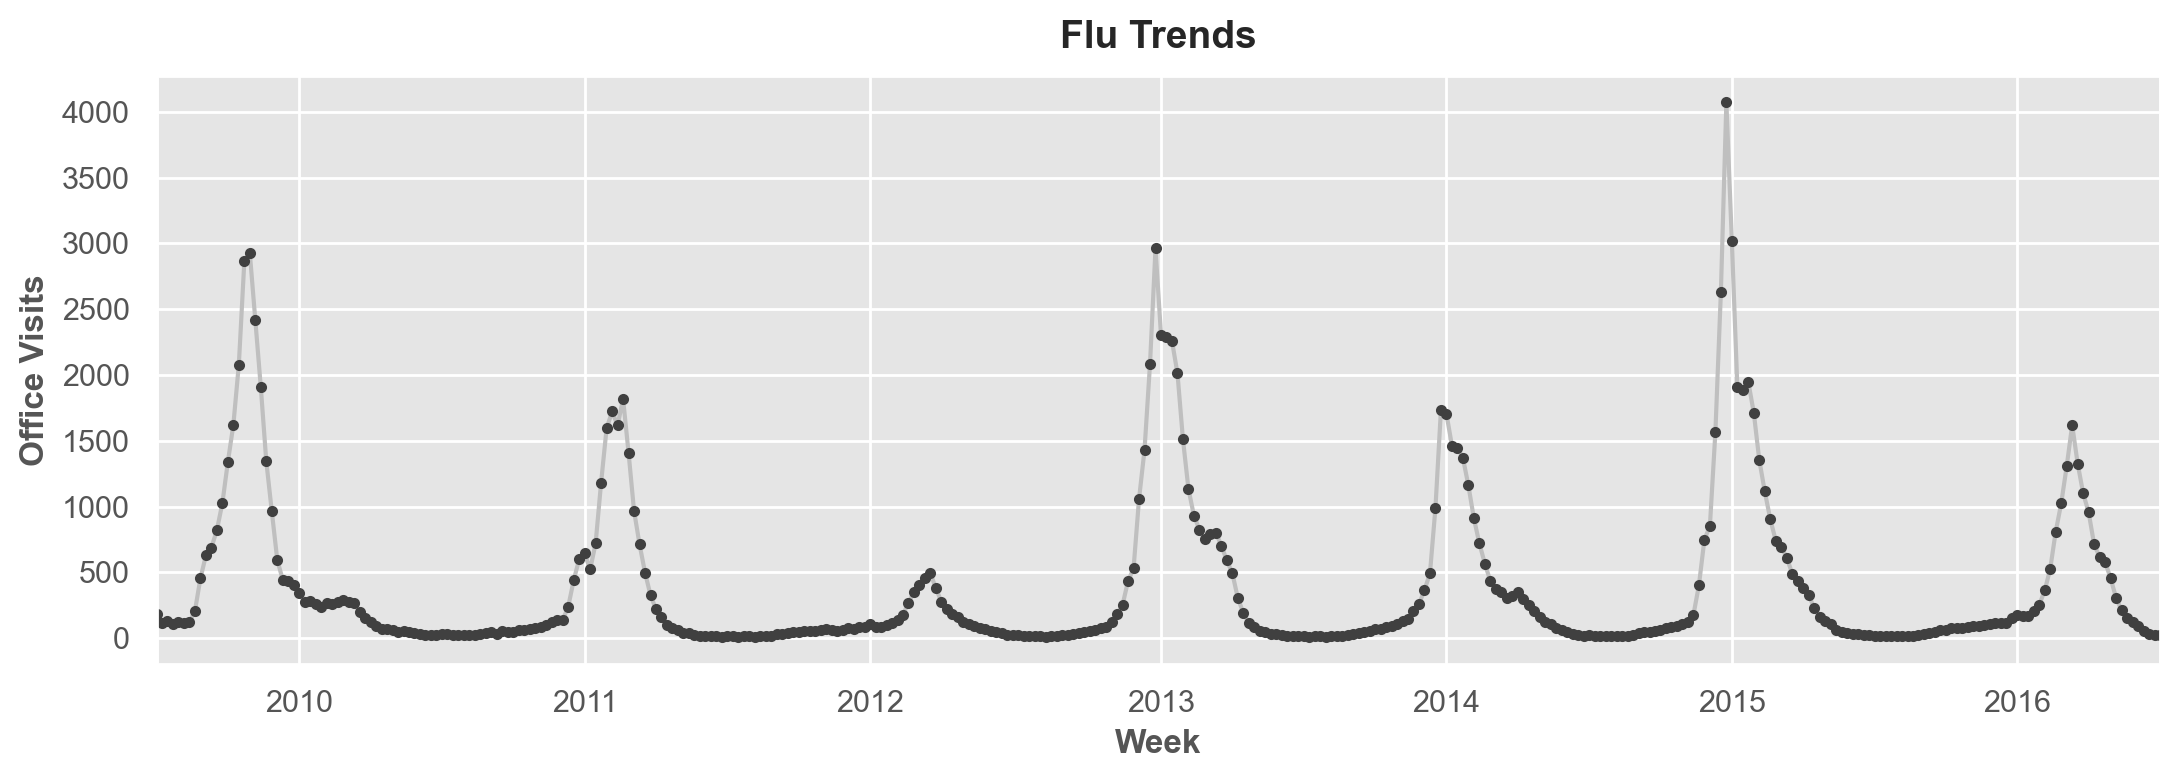

In [49]:
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")    

Функции построения графиков запаздывания

In [51]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [52]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

Чтобы исследовать возможную зависимость рядов, нужно создать "запаздывающие" копии рядов. Разбиение временного ряда на части означает сдвиг значений на один или несколько временных шагов вперед.

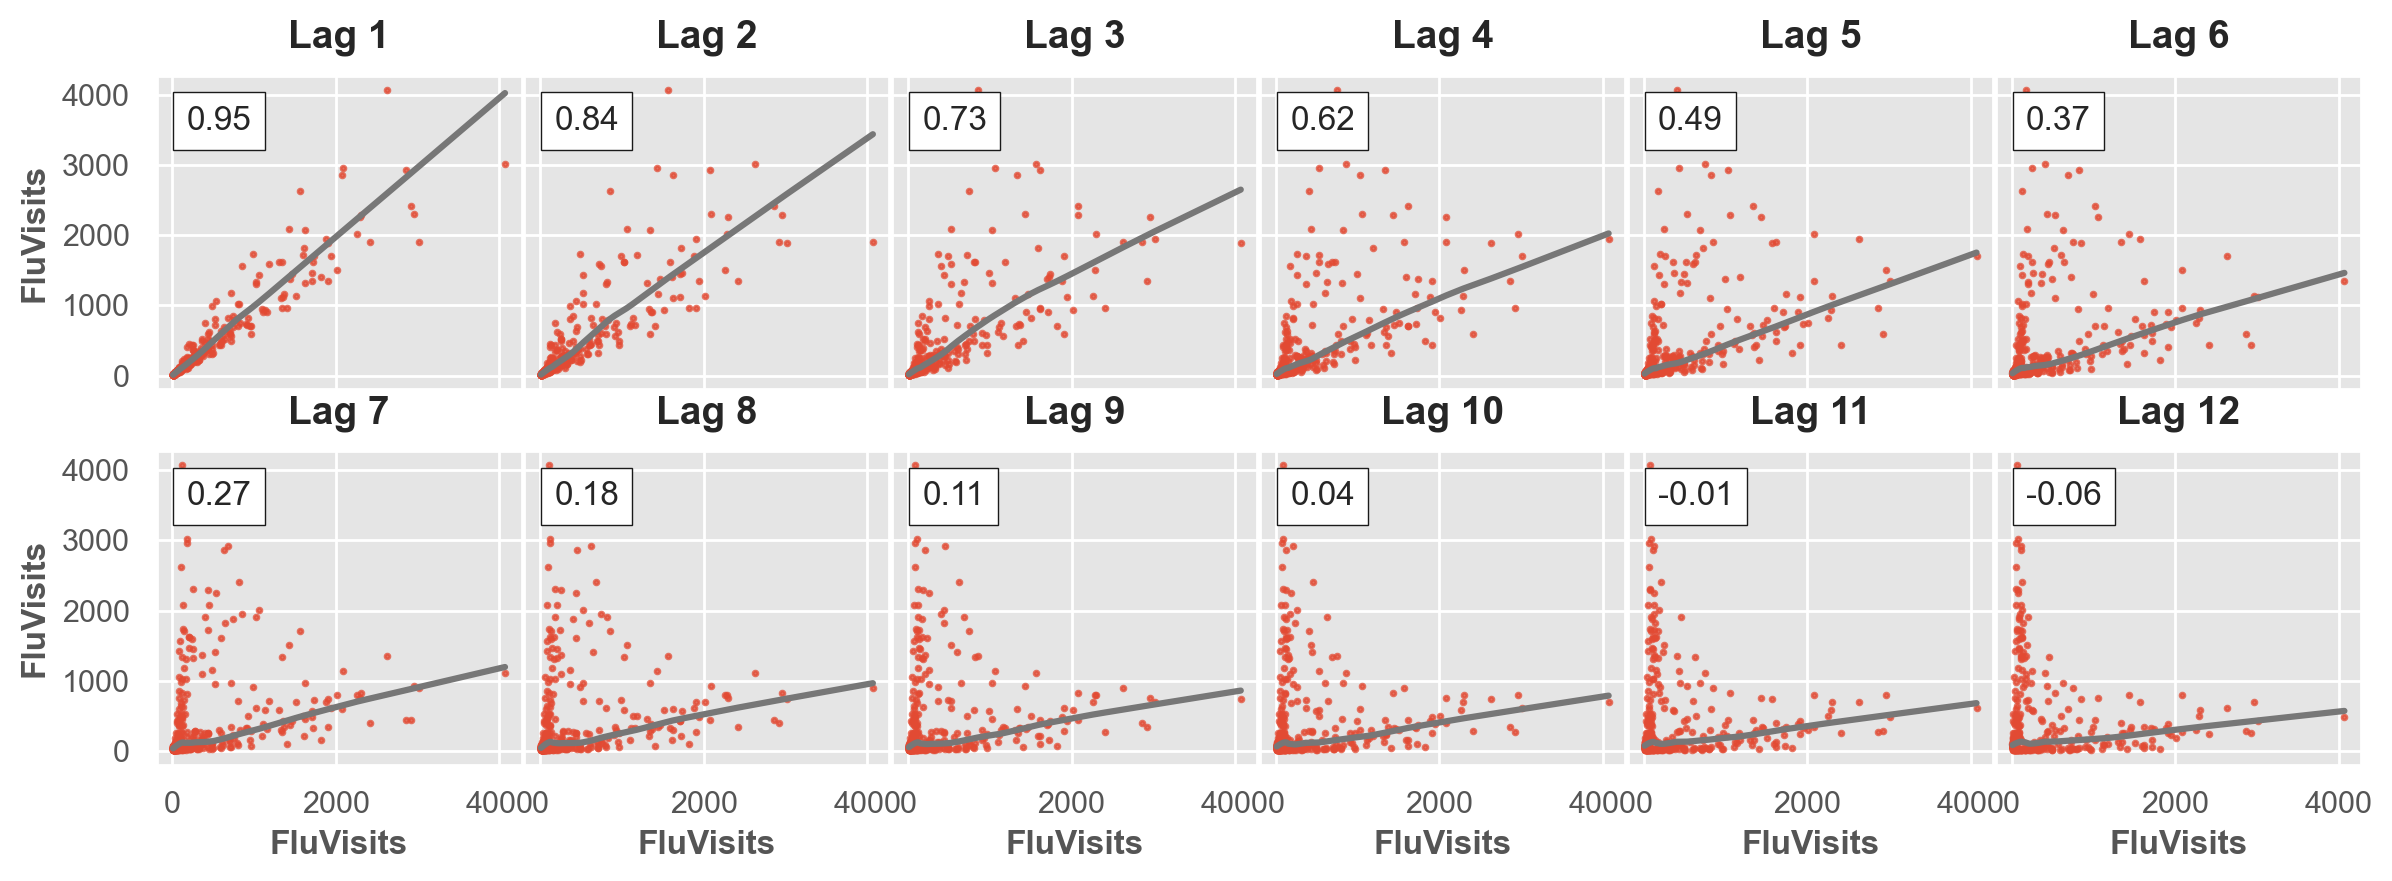

In [53]:
_ = plot_lags(flu_trends.FluVisits, lags = 12, nrows = 2)

При выборе задержек для использования в качестве характеристик, как правило, нецелесообразно включать каждую задержку с большой автокорреляцией. Например, в случае безработицы в США автокорреляция на лаге 2 может быть полностью результатом "искаженной" информации из лага 1 - это просто корреляция, перенесенная с предыдущего шага.

Частичная автокорреляция показывает вам корреляцию большого значения, учитывающую все предыдущие задержки, - так сказать, степень "новой" корреляции, которую вносит задержка

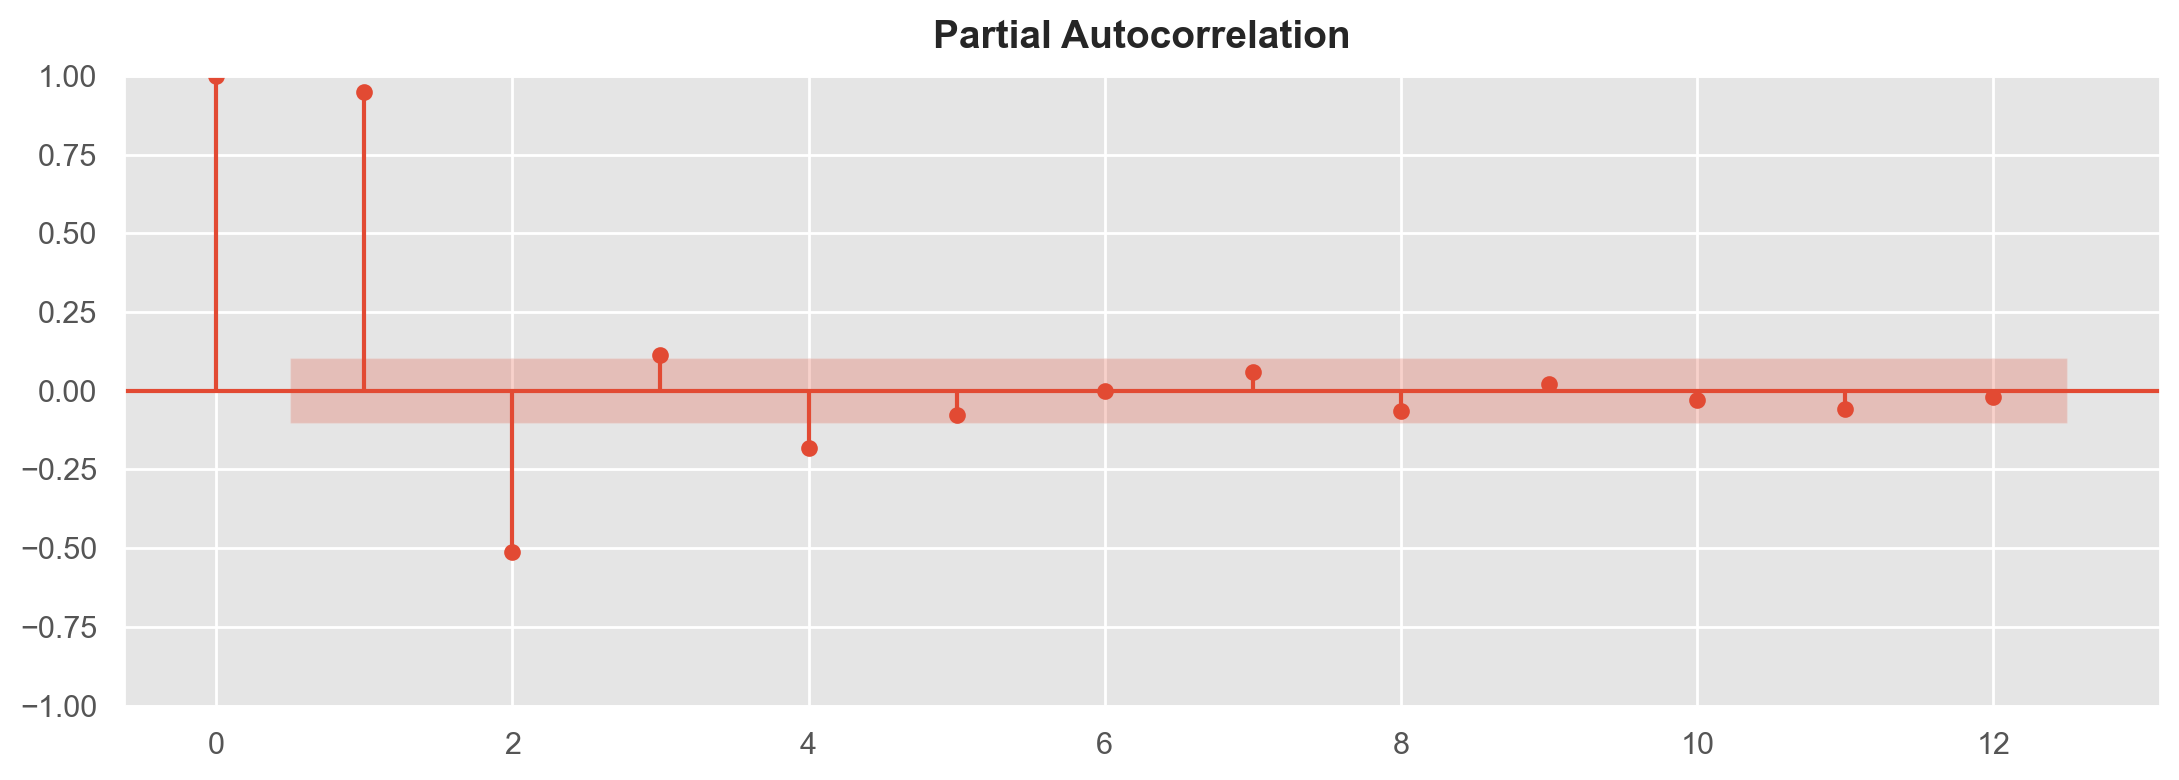

In [54]:
_= plot_pacf(flu_trends.FluVisits, lags=12);

In [55]:
def make_lags(ts, lags):
    return pd.concat(
        {f'y_lag_{i}': ts.shift(i) for i in range(1, lags + 1)}, axis = 1)
X = make_lags(flu_trends.FluVisits, lags = 4)
X = X.fillna(0.0)

In [56]:
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 60, shuffle = False)
model = LinearRegression().fit(X_train,y_train)
y_pred = pd.Series(model.predict(X_train), index = y_train.index)
y_fore = pd.Series(model.predict(X_test), index = y_test.index)

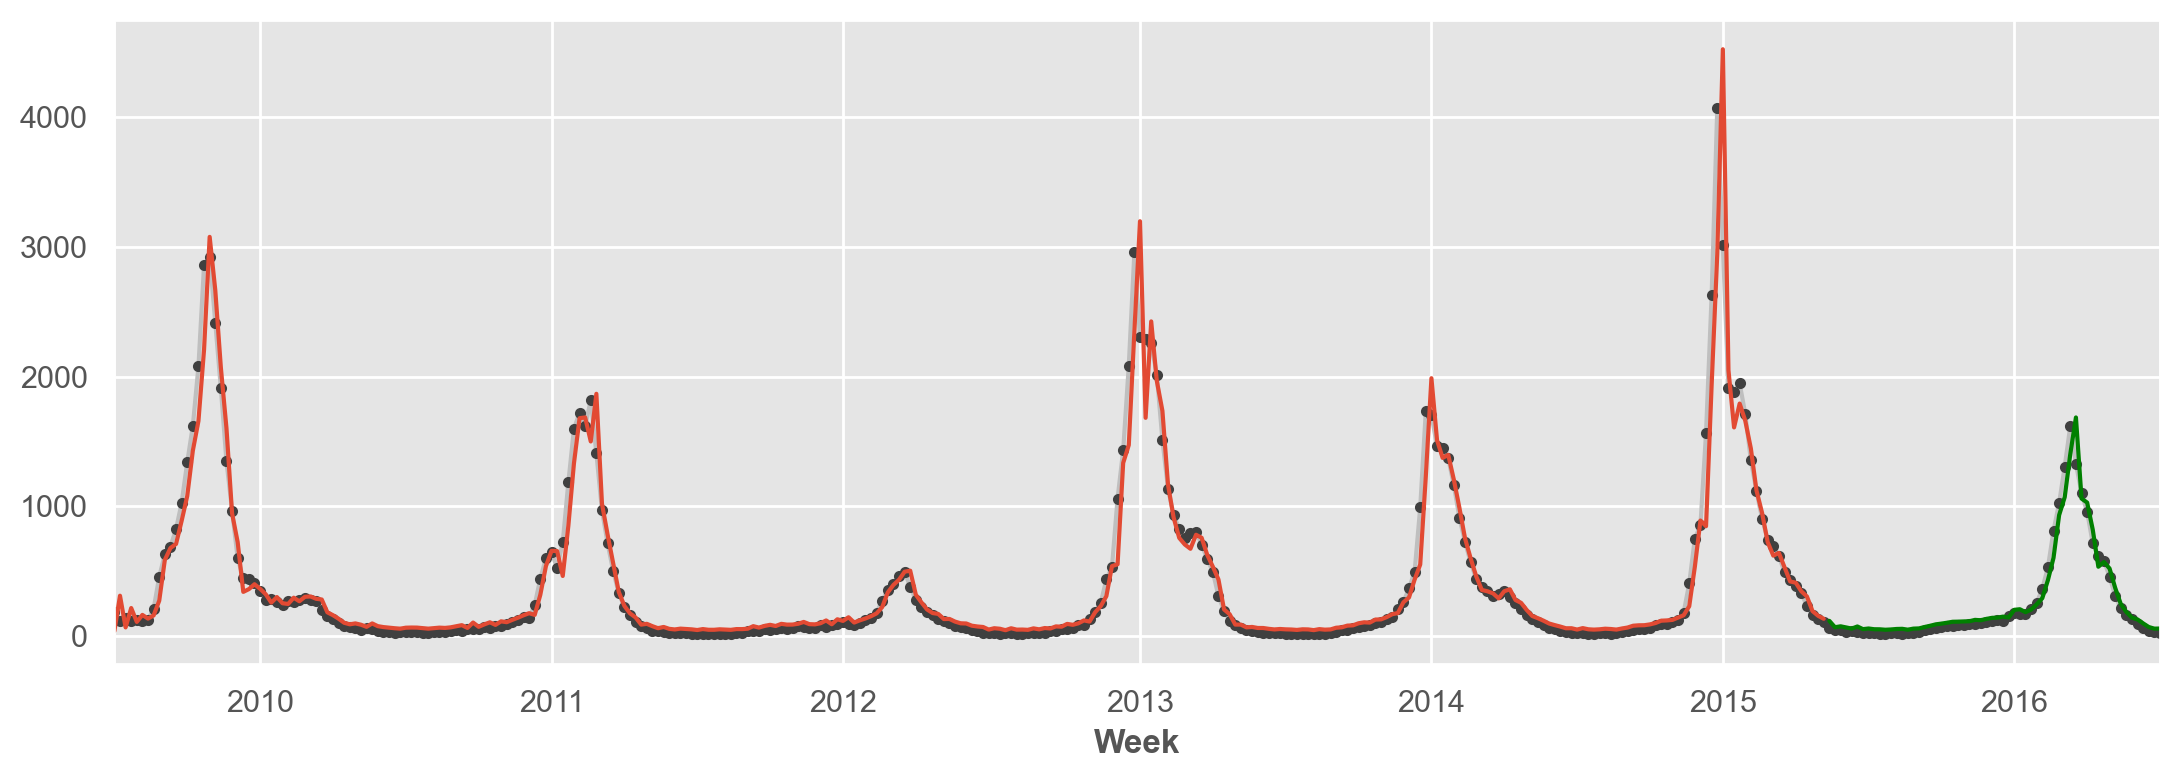

In [57]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color = 'green')

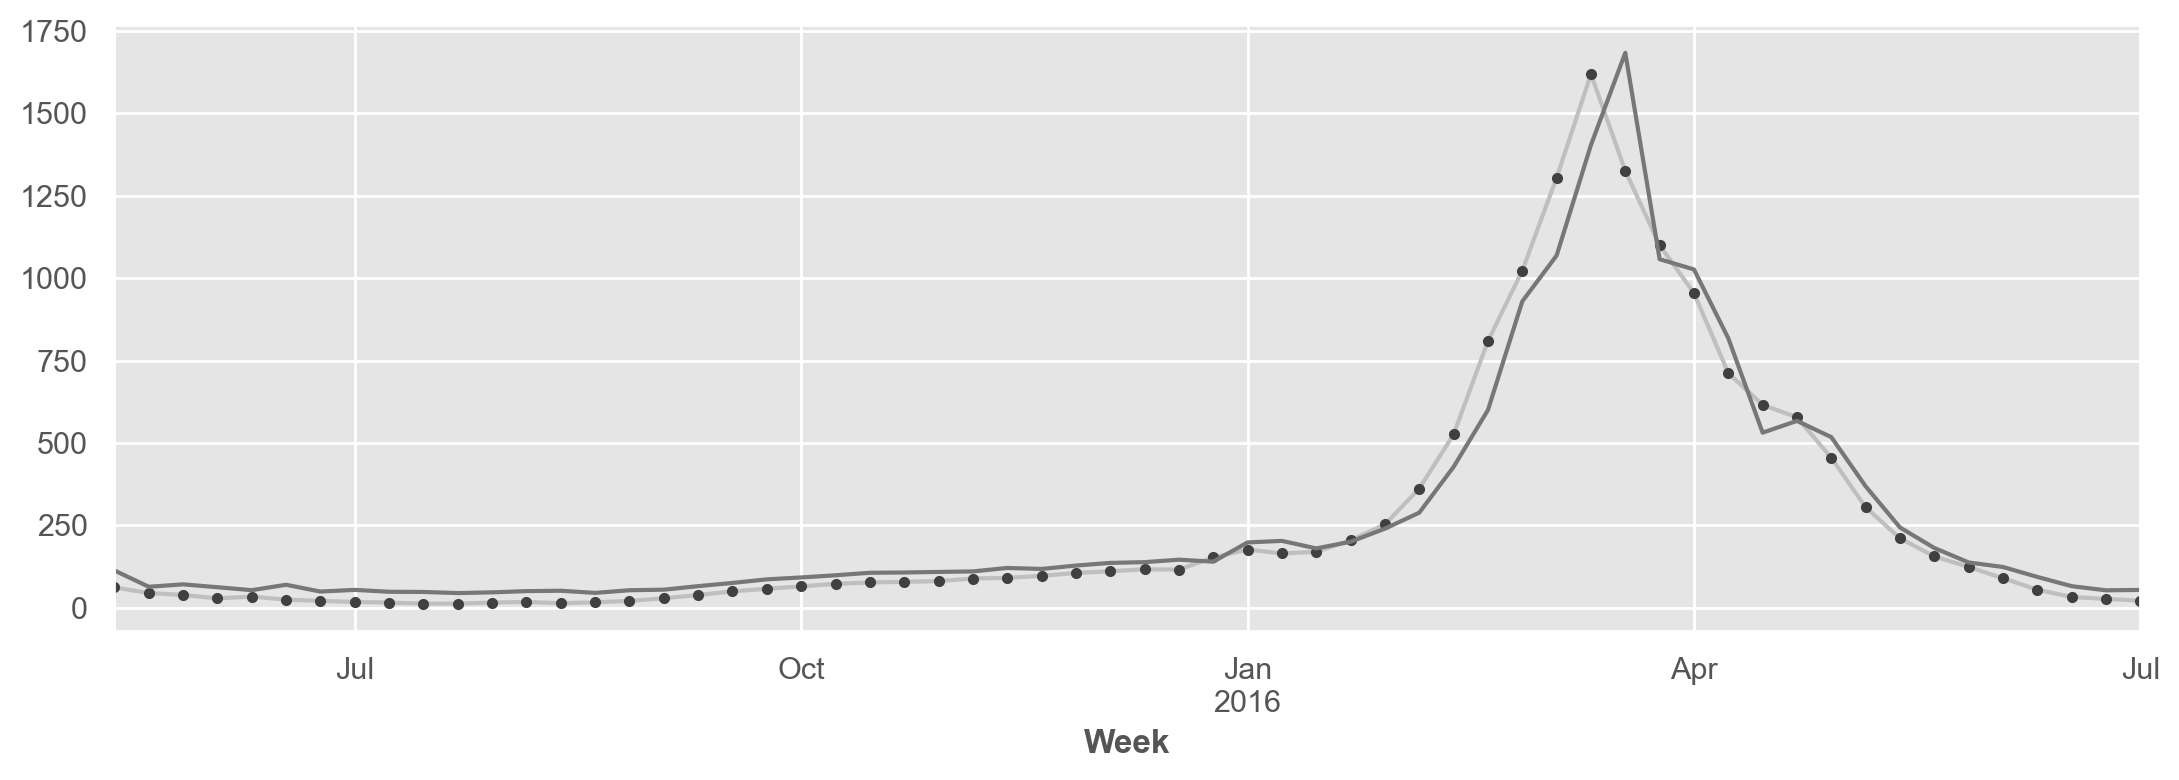

In [58]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Чтобы улучшить прогноз, мы могли бы попытаться найти опережающие индикаторы, временные ряды, которые могли бы обеспечить "раннее предупреждение" об изменениях в заболеваемости гриппом

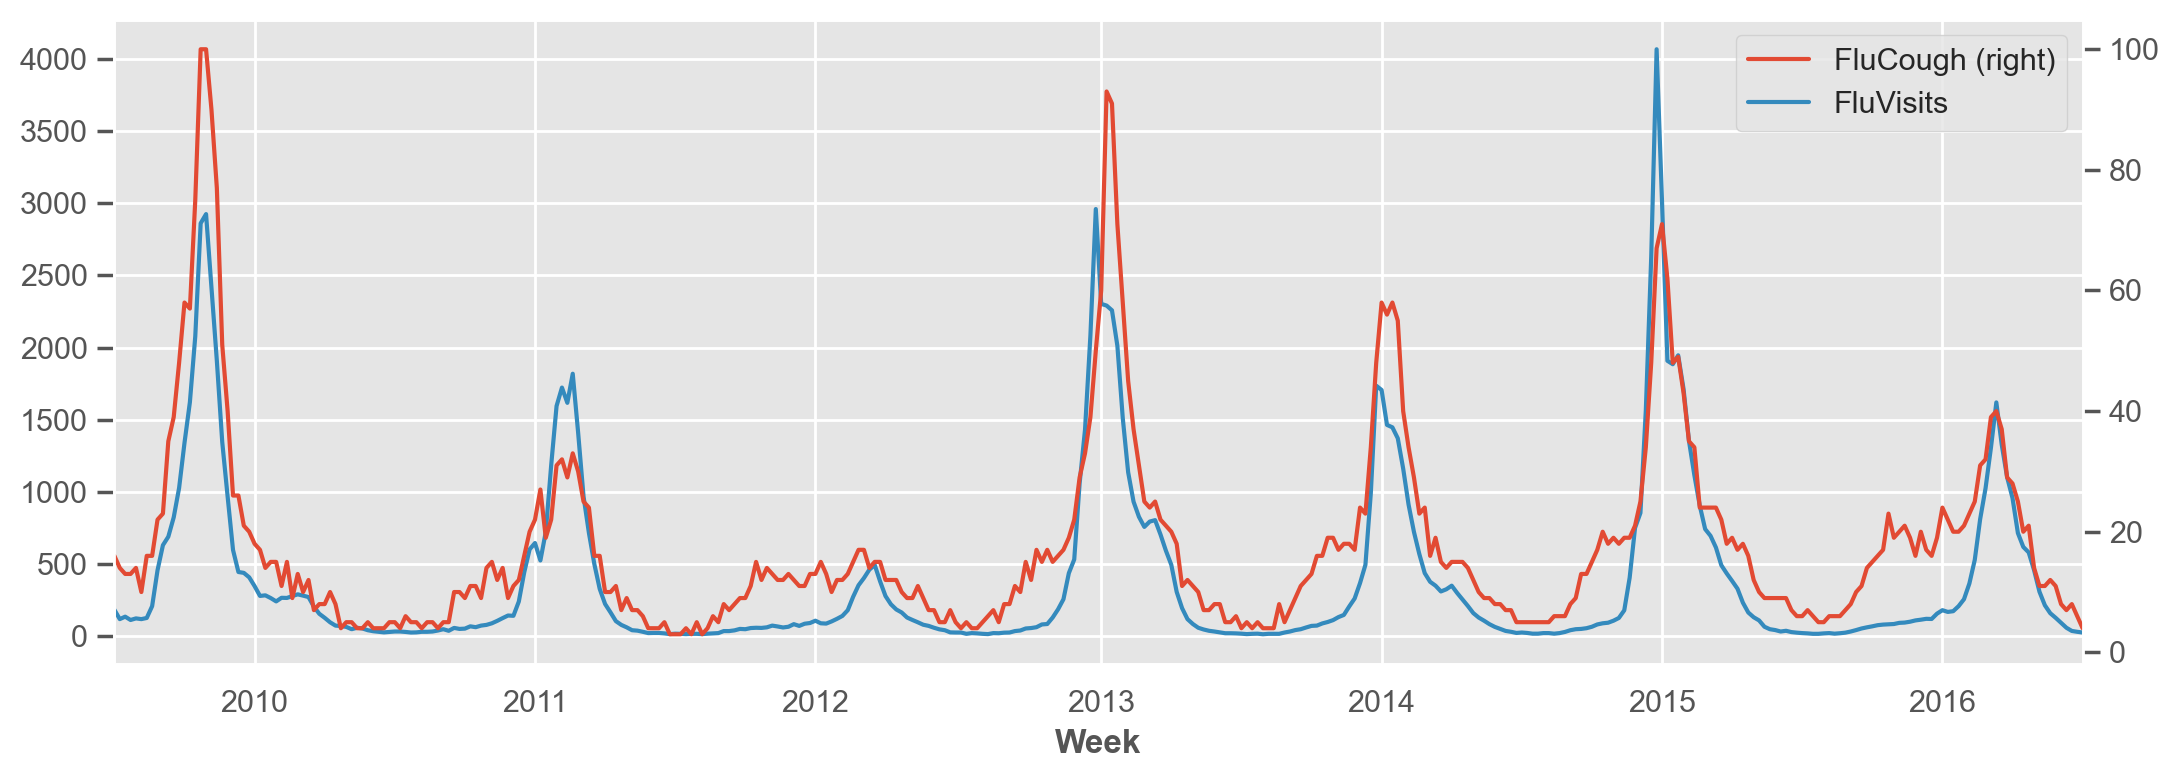

In [59]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

In [60]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

In [61]:
X0 = make_lags(flu_trends[search_terms], lags = 3)

In [62]:
X0.columns = [' '.join(col).strip() for col in X0.columns.values]
X1 = make_lags(flu_trends['FluVisits'], lags = 4)
X = pd.concat([X0, X1], axis = 1).fillna(0.0)
X.columns = [col.replace(' ','') for col in X.columns.values]

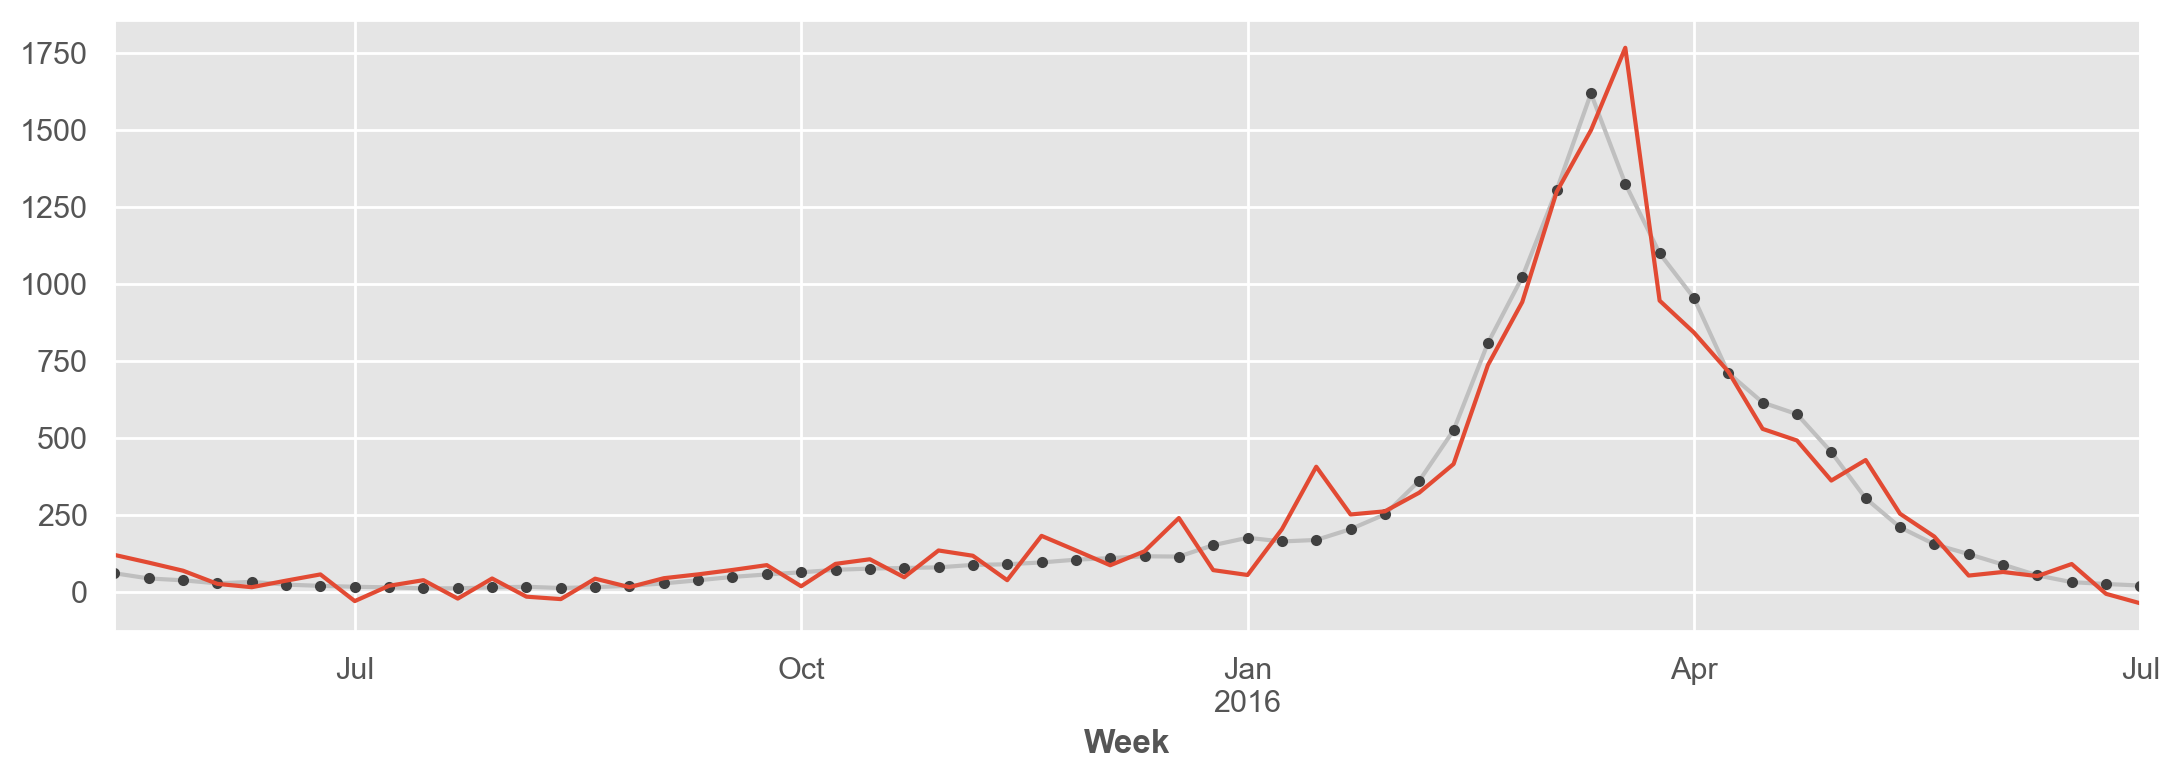

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 60, shuffle = False)
model = LinearRegression().fit(X_train, y_train)
y_preds = pd.Series(model.predict(X_train), index= y_train.index)
y_fore = pd.Series(model.predict(X_test), index = y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax =ax)

Задания

In [84]:
from sklearn.metrics import mean_squared_log_error
import os
with zipfile.ZipFile(comp_dir / 'train.csv.zip', 'r') as rip_ref:
    rip_ref.extract('train.csv', path = comp_dir)
train_file_path = Path(comp_dir, 'train.csv')

store_sales = pd.read_csv(
    comp_dir / train_file_path,
    usecols = ['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates = ['date'],
    infer_datetime_format = True)

train_file_path.unlink()

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
family_sales = (
    store_sales.groupby(['family', 'date']).mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]   # За 2017 год. Почему прошлые года не рассматриваем?
)

Тренд и сезонность создают последовательную зависимость, которая отображается на коррелограммах и графиках с запаздыванием. Чтобы выделить чисто циклическое поведение, мы начнем с разбивки рядов по сезонам

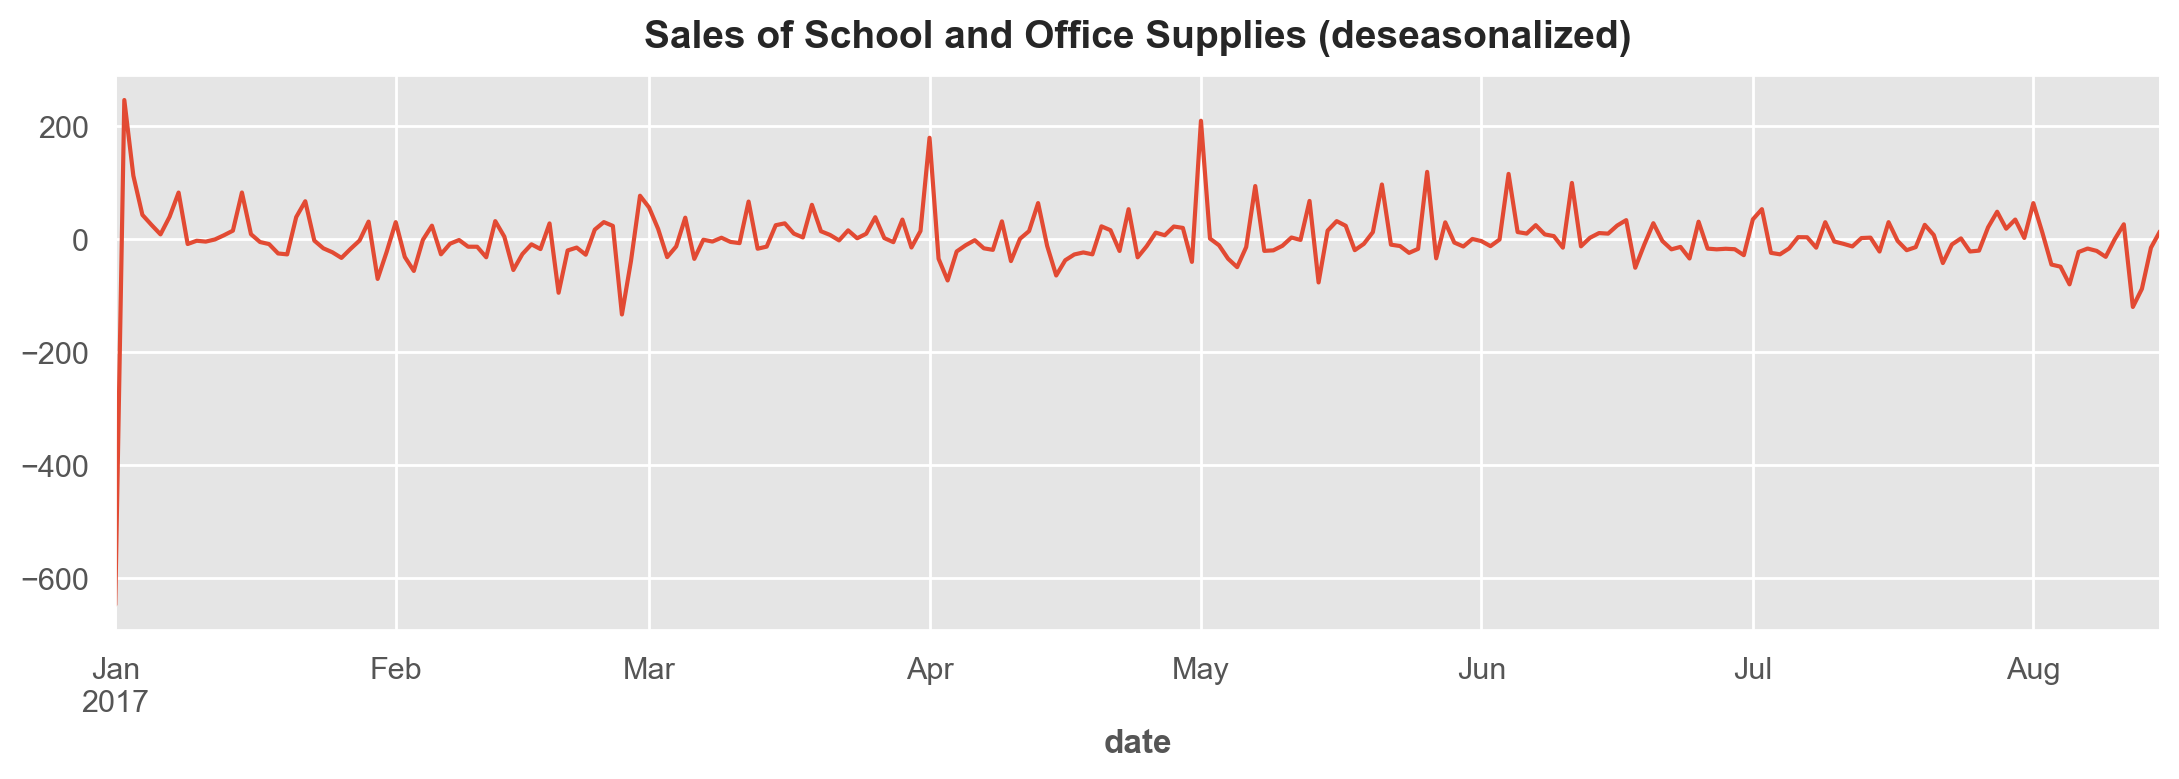

In [65]:
supply_sales = family_sales.loc(axis = 1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()
fourier = CalendarFourier(freq = 'M', order = 4)
dp = DeterministicProcess(
    constant = True,
    index = y.index,
    order = 1,
    seasonal = True,
    additional_terms = [fourier],
    drop = True)
X_time = dp.in_sample()
X_time['NewYearsDas'] = (X_time.index.dayofyear == 1)
model = LinearRegression(fit_intercept =False).fit(X_time,y)
y_deaseasons = y - model.predict(X_time)
ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

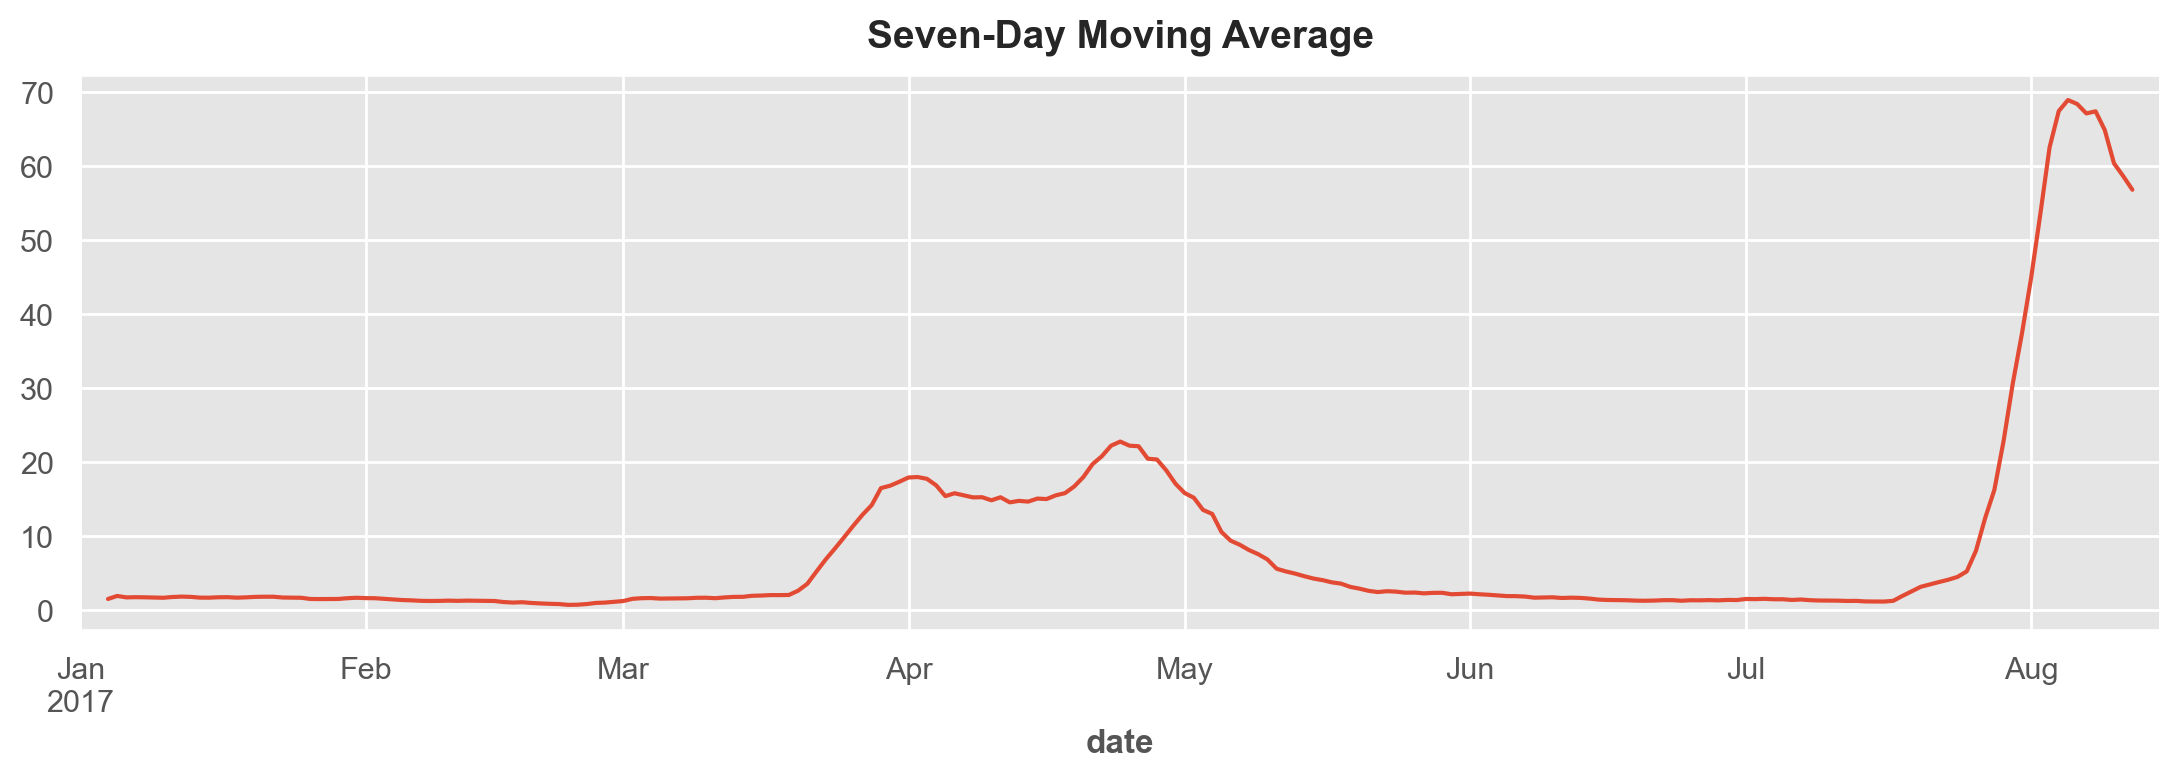

In [66]:
y_ma = y.rolling(window = 7,
                           center = True).mean()
# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

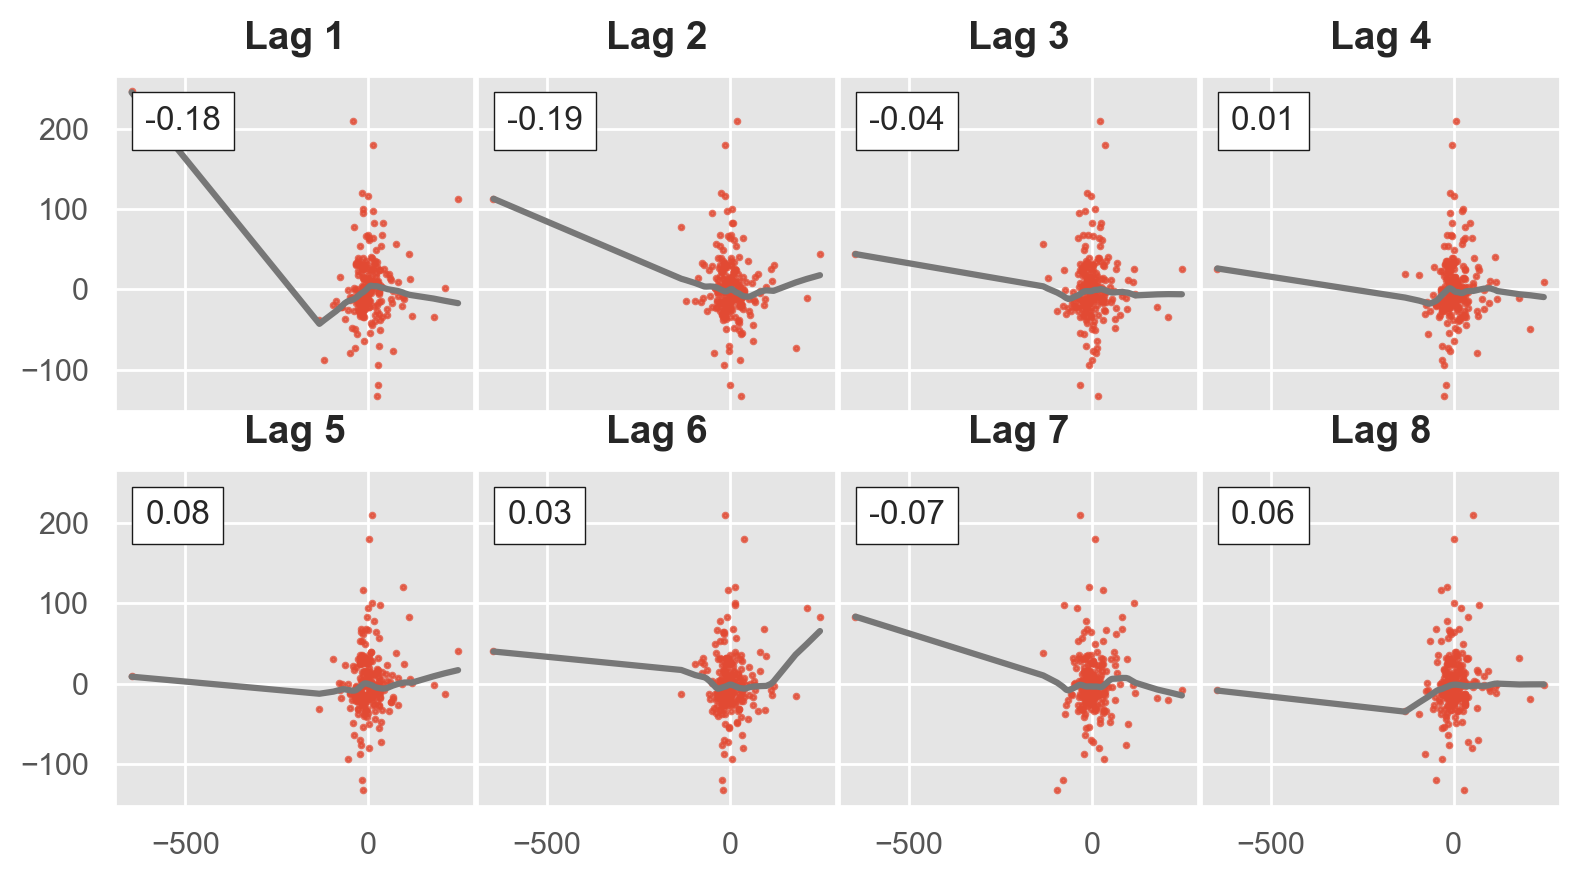

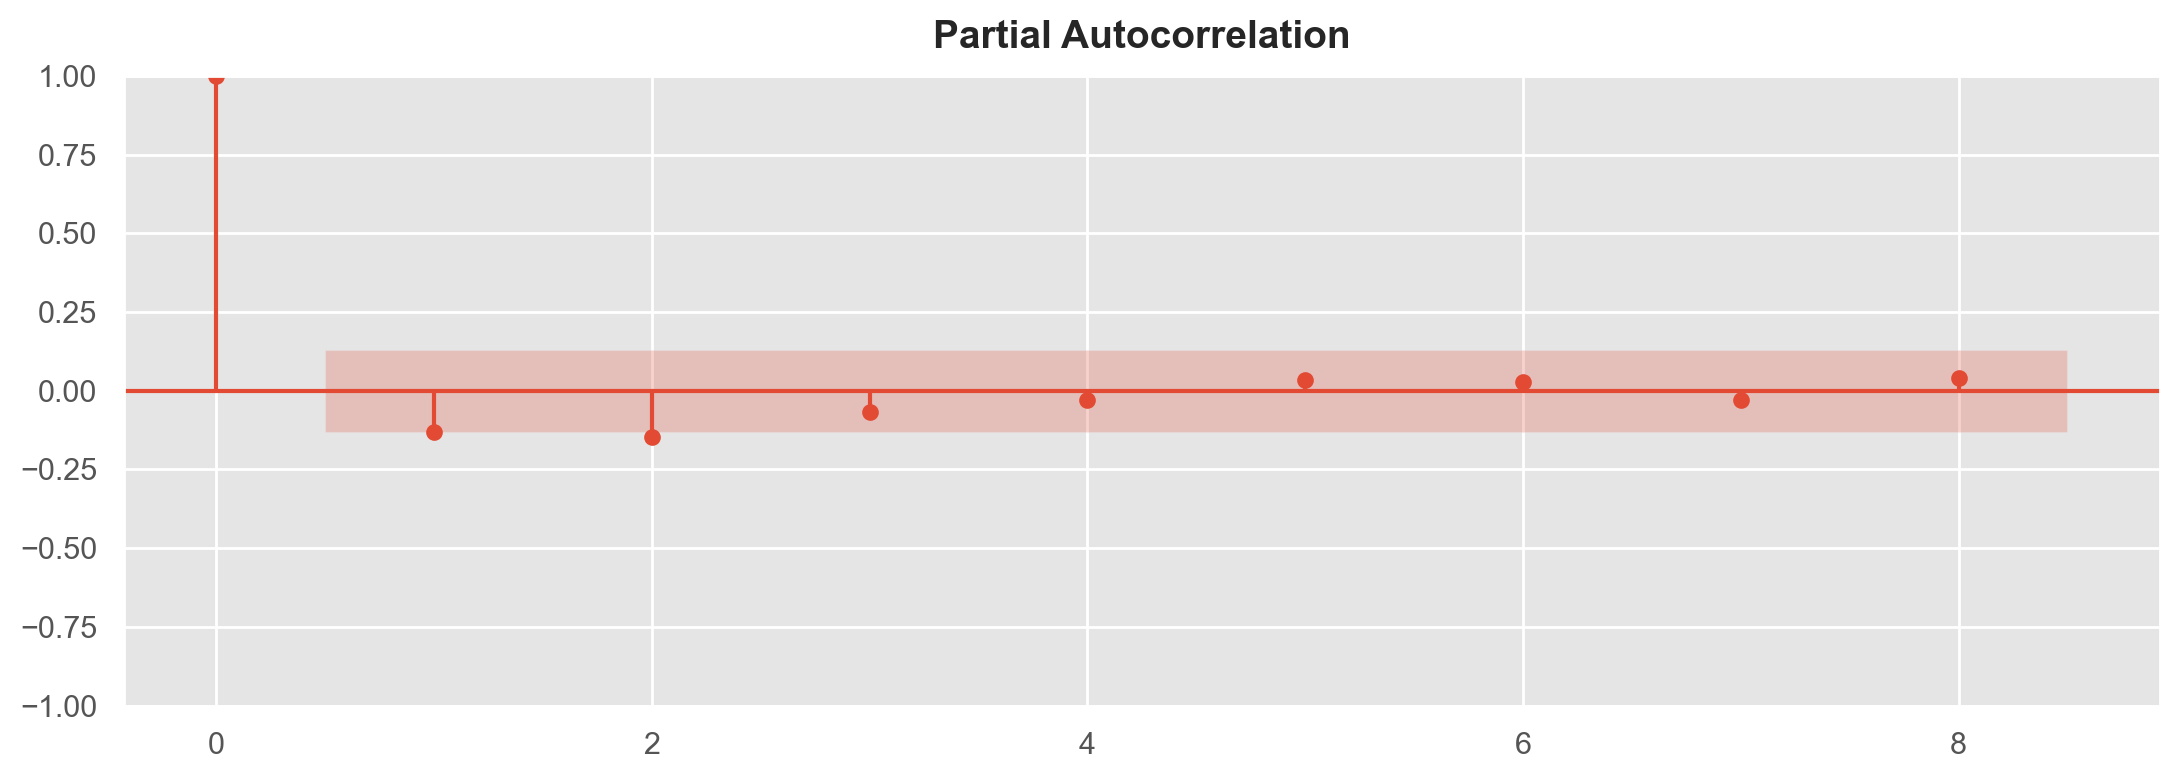

In [67]:
plot_lags(y_deseason, lags = 8, nrows = 2);
plot_pacf(y_deseason, lags = 8);

Опережающий индикатор - это ряд значений, которые могут быть использованы для прогнозирования целевого показателя в будущем. Опережающий индикатор обеспечивает "предварительное уведомление" об изменениях целевого показателя.

Набор данных о конкурсе включает в себя временные ряды, которые потенциально могут быть полезны в качестве опережающего показателя

In [68]:
def make_leads(ts, leads):
    return pd.concat({f'y_lead{i}': ts.shift(-i) for i in range(0, leads)}, axis = 1)

In [69]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

In [70]:
X_lags = make_lags(y_deseason, lags = 1)
X_promo = pd.concat([
    make_lags(onpromotion, lags = 1),
    onpromotion,
    make_leads(onpromotion, leads = 1)], axis= 1)

X = pd.concat([X_lags, X_promo], axis = 1).fillna(0.0)
y, X = y.align(X, join = 'inner')

Training RMSLE: 0.82613
Validation RMSLE: 1.17026


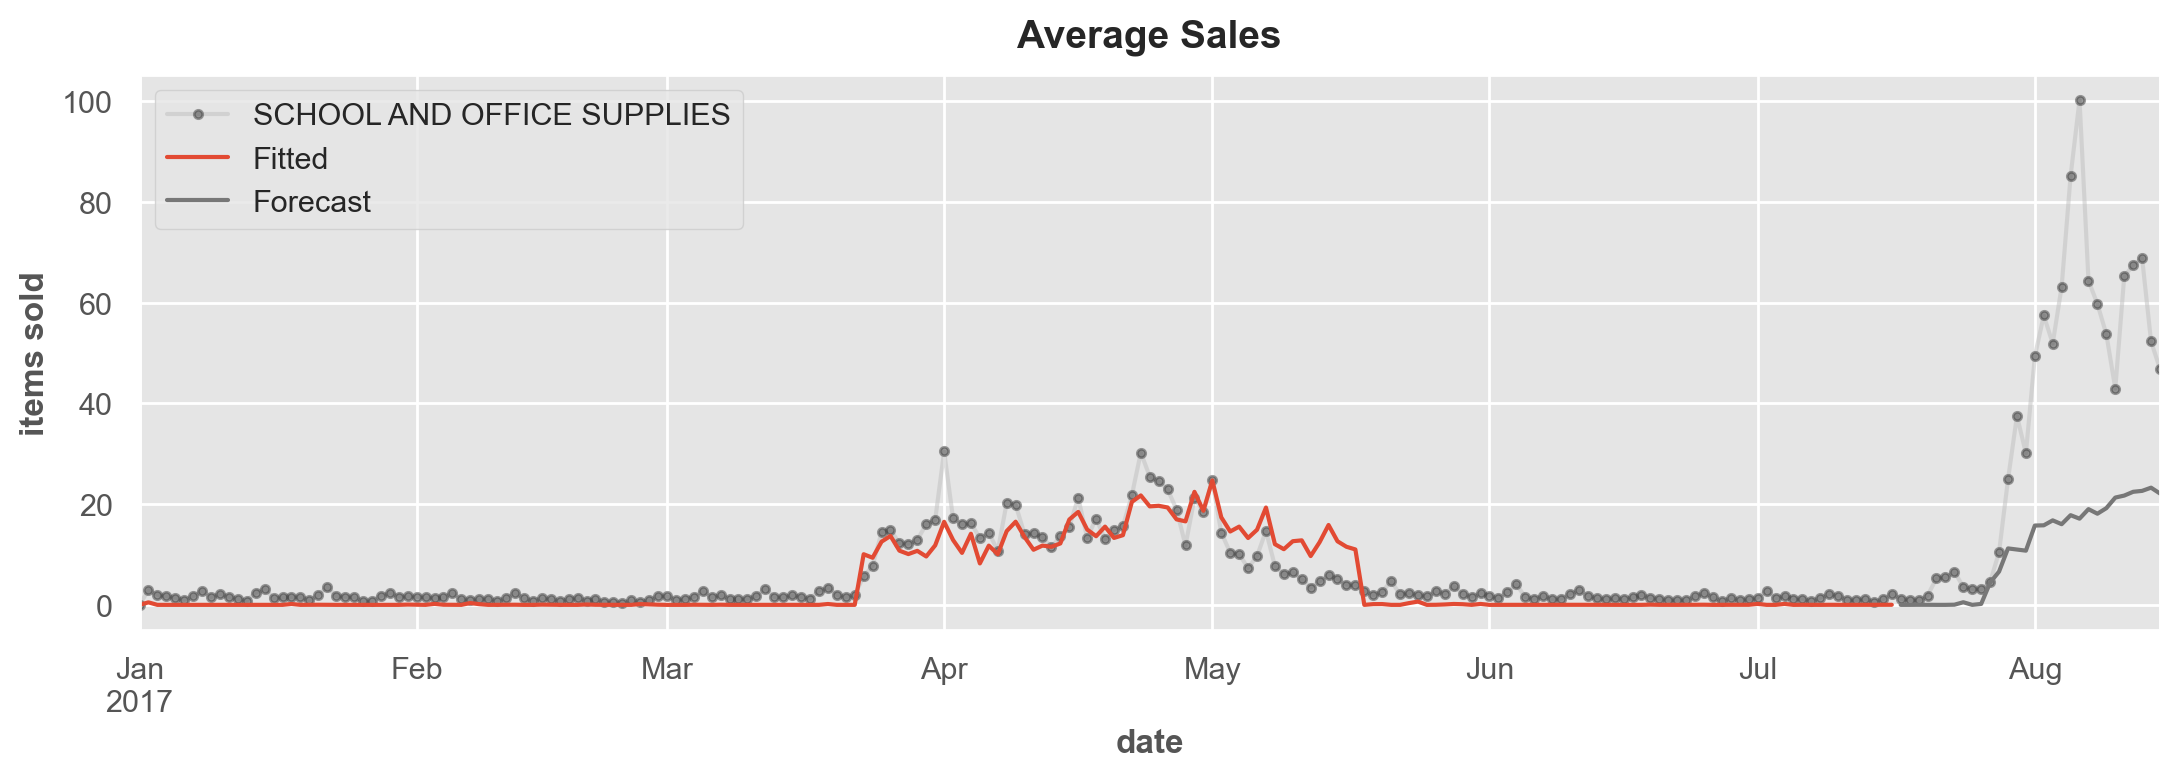

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 30, shuffle = False)
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

Победители конкурсов Kaggle по прогнозированию часто включают скользящие средние и другую скользящую статистику в свои наборы функций. Такие функции особенно полезны при использовании с алгоритмами GBDT, такими как XGBoost.

Вычисление скользящей статистики, которая будет использоваться в качестве функций, аналогично, за исключением того, что нам нужно позаботиться о том, чтобы избежать утечки информации заранее. Во-первых, результат должен быть установлен в правом конце окна, а не в центре, то есть мы должны использовать center=False (значение по умолчанию) в методе прокрутки. Во-вторых, цель должна быть на шаг отставлена.

In [72]:
supply_sales = family_sales.loc(axis = 1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
mean_7_gauss= y_lag.ewm(alpha = 0.5).mean()
# 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
std_7_gauss = y_lag.ewm(alpha = 0.5).std()
# 7-day sum of promotions with centered windowb
promo_7 = onpromo.rolling(7, center = True).std()

Попробовать "экспоненциально взвешенные" окна, используя ewma вместо rolling; экспоненциальный спад часто является более реалистичным представлением того, как эффекты распространяются с течением времени. pd.Window

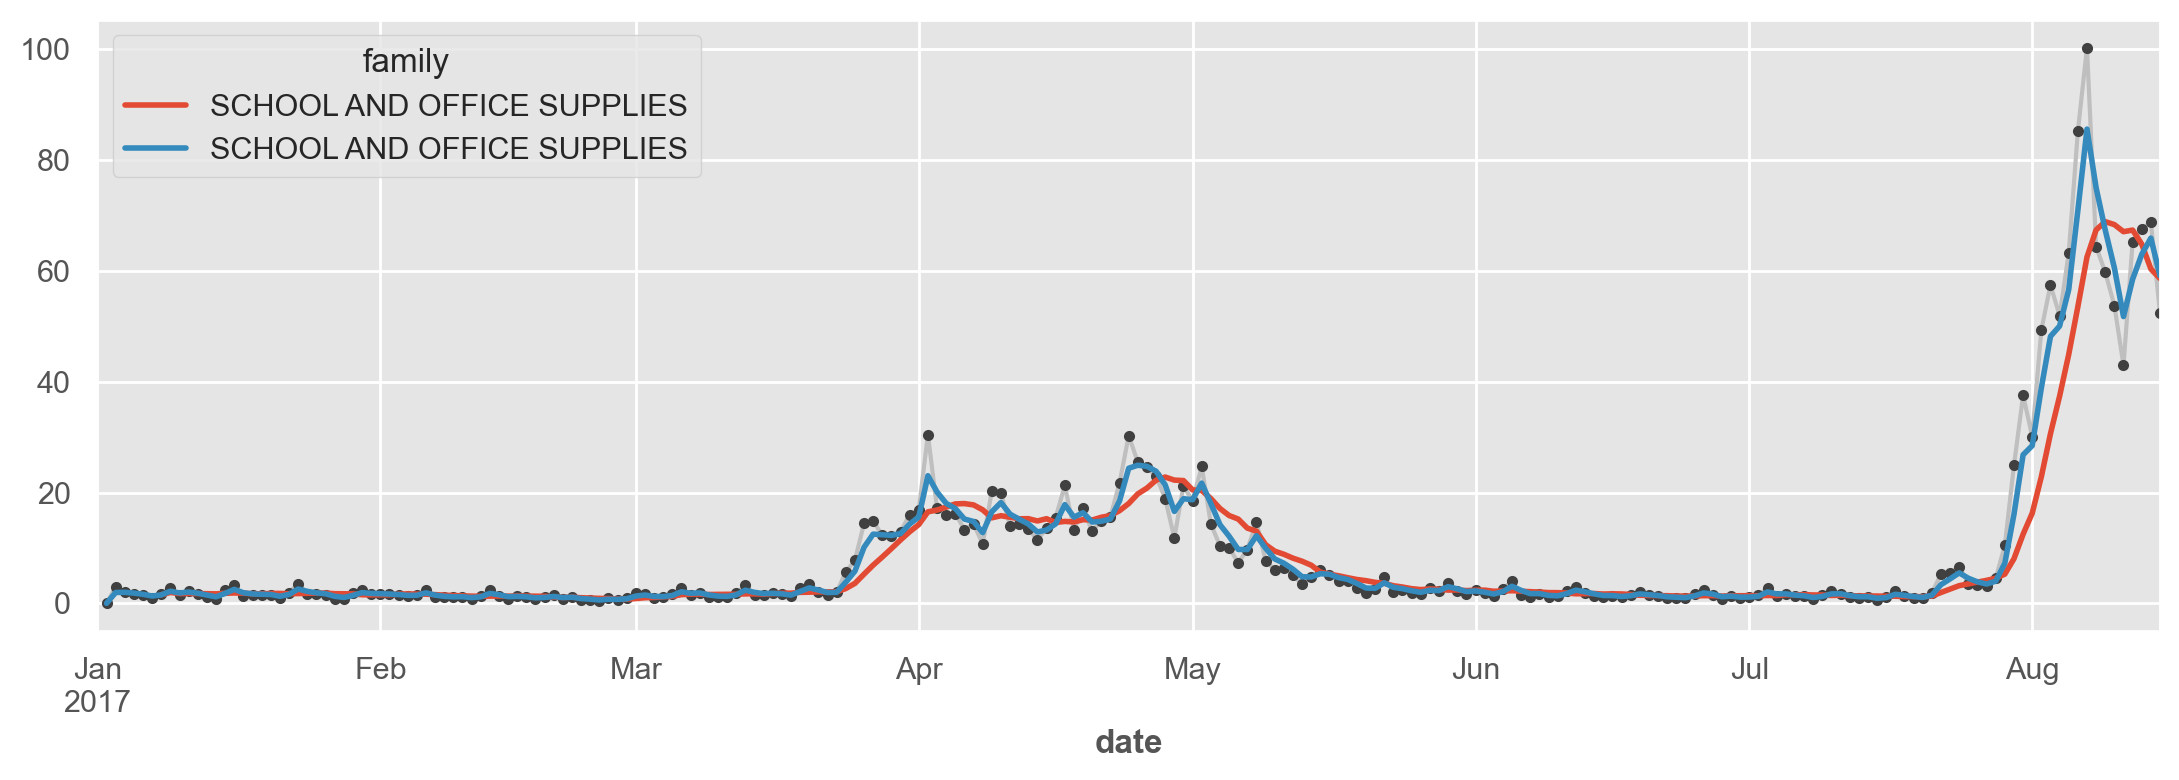

In [73]:
ax = y_lag.plot(**plot_params)
ax = mean_7.plot(ax = ax, linewidth = 2)
ax = mean_7_gauss.plot(ax = ax, linewidth = 2)

# Гибридные модели

Линейная регрессия отлично справляется с экстраполяцией тенденций, но не может изучать взаимодействия. XGBoost отлично справляется с изучением взаимодействий, но не может экстраполировать тенденции."**Гибридные**" модели-прогнозисты, которые сочетают в себе взаимодополняющие алгоритмы обучения и позволяют сильным сторонам одного компенсировать слабость другого

До сих пор мы изучали три модели зависимости: тренд, сезоны и циклы. Многие временные ряды могут быть точно описаны с помощью аддитивной модели, состоящей только из этих трех компонентов плюс некоторой, по сути, непредсказуемой, полностью случайной ошибки

Остаточные значения модели - это разница между целевым показателем, на котором была обучена модель, и прогнозами, которые она делает, другими словами, разница между фактической кривой и подогнанной кривой. Сопоставьте остатки с объектом, и вы получите "оставшуюся" часть объекта, или то, что модель не смогла узнать о объекте из этого объекта.

Мы могли бы представить изучение компонентов временного ряда как итеративный процесс: сначала изучаем тренд и вычтем его из ряда, затем изучаем сезонность по остаткам без тренда и вычтем сезоны, затем изучаем циклы и вычтем циклы, и, наконец, остается только непредсказуемая ошибка.

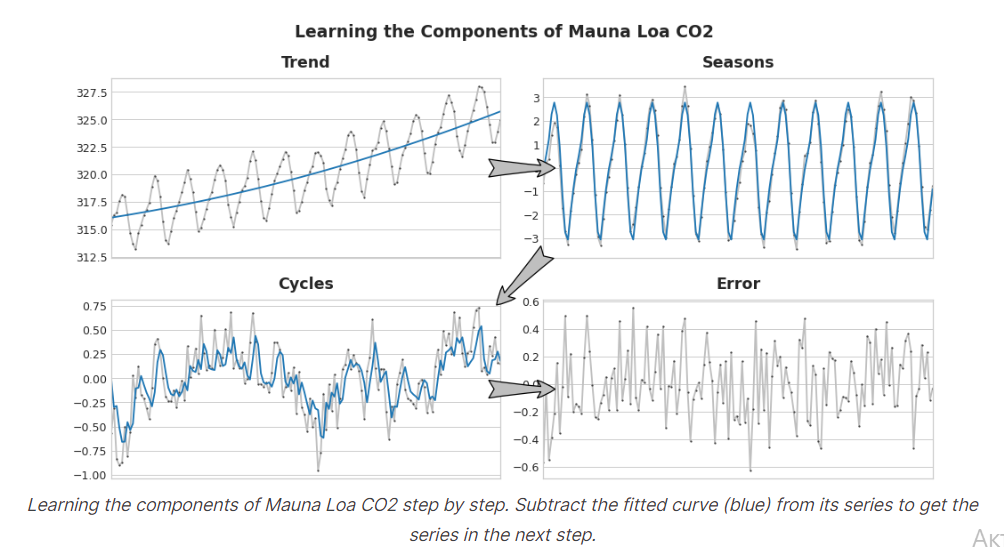

Сложите вместе все компоненты, которые мы изучили, и мы получим полную модель.

В предыдущих уроках мы использовали единый алгоритм (линейную регрессию), чтобы изучить все компоненты сразу. Но также возможно использовать один алгоритм для некоторых компонентов и другой алгоритм для остальных. Таким образом, мы всегда можем выбрать наилучший алгоритм для каждого компонента. Для этого мы используем один алгоритм для подбора исходного ряда, а затем второй алгоритм для подбора остаточного ряда

Наиболее распространенной стратегией создания гибридов является та, которую мы только что описали: простой (обычно линейный) алгоритм обучения, за которым следует сложный нелинейный обучающий модуль, такой как GBDTs или глубокая нейронная сеть. Простая модель, как правило, предназначена в качестве "помощника" для последующего мощного алгоритма.

Важно вот что: преобразователи признаков (линейная регрессия, нейронные сети), как правило, могут экстраполировать целевые значения за пределы обучающего набора, учитывая соответствующие характеристики в качестве входных данных, но прогнозы целевых преобразователей(Knn, деревья решений) всегда будут ограничены диапазоном обучающего набора. Если временная модель продолжает считать временные шаги, линейная регрессия продолжает рисовать линию тренда. При одинаковом временном интервале дерево решений будет предсказывать тренд, указанный на последнем шаге обучающих данных, на будущее навсегда. Деревья решений не могут экстраполировать тренды. Случайные леса и деревья решений с градиентным ускорением (например, XGBoost) представляют собой ансамбли деревьев решений, поэтому они также не могут экстраполировать тенденции.

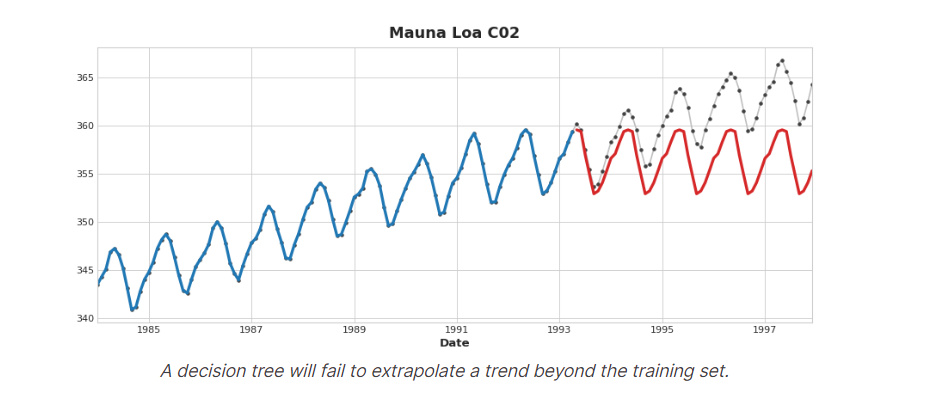

Используйте линейную регрессию для экстраполяции тренда, преобразуйте цель, чтобы устранить тренд, и примените XGBoost к остаткам, не связанным с трендом. 

Чтобы гибридизировать нейронную сеть (преобразователь признаков), вы могли бы вместо этого включить предсказания другой модели в качестве признака, который нейронная сеть затем включила бы в свои собственные предсказания. Метод подгонки к остаткам на самом деле является тем же методом, который использует алгоритм повышения градиента. Метод использования предсказаний в качестве признаков известен как "укладка", поэтому мы будем называть эти сложенные гибриды.

In [74]:
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols = ['Month'] + industries,
    parse_dates = ['Month'],
    index_col = 'Month').to_period('D').reindex(columns = industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis = 1) 

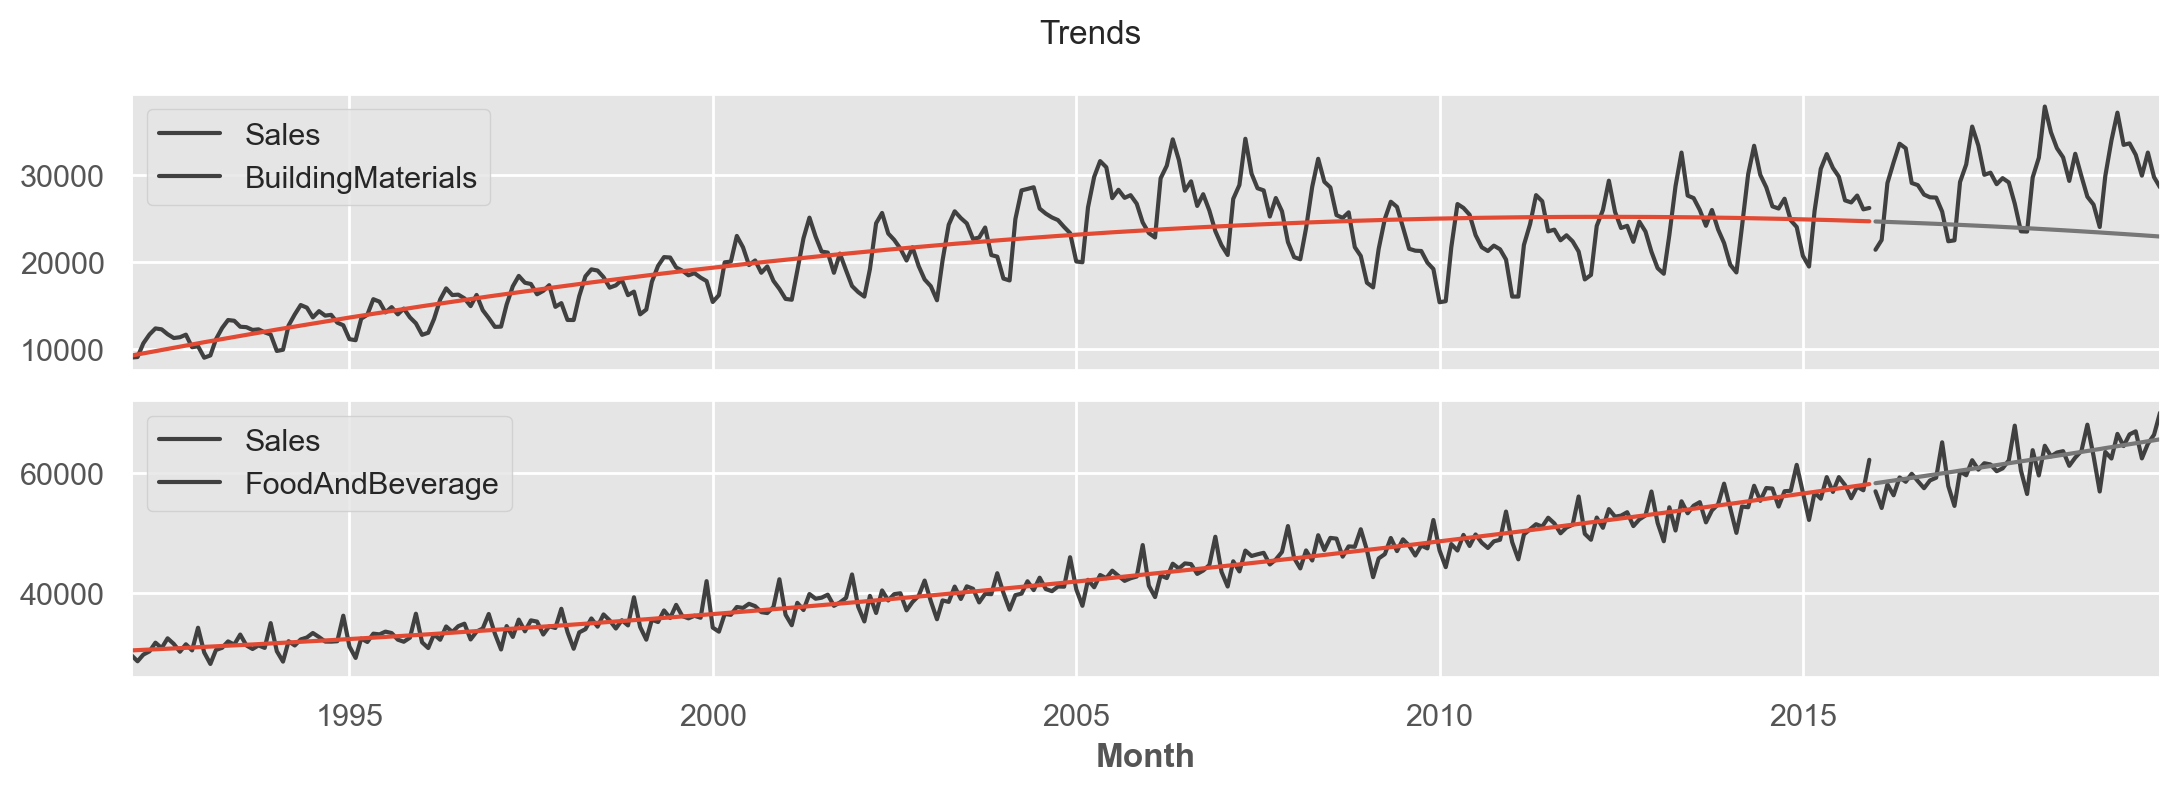

In [75]:
y = retail.copy()

dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order = 2,
    drop = True)

X = dp.in_sample()
# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False)

X_train, X_test = X.loc[idx_train,:] , X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

model = LinearRegression(fit_intercept = False).fit(X_train, y_train)
y_fit = pd.DataFrame(model.predict(X_train), index = y_train.index, columns = y_train.columns)
y_pred = pd.DataFrame(model.predict(X_test), index = y_test.index, columns= y_test.columns)

axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for i, ax in enumerate(axs): ax.legend(y.columns.values[i])
_ = plt.suptitle("Trends")

В то время как алгоритм линейной регрессии способен выполнять регрессию с несколькими выходными данными, алгоритм XGBoost - нет. Чтобы предсказать несколько рядов одновременно с помощью XGBoost, мы вместо этого преобразуем эти ряды из широкого формата, с одним временным рядом на столбец, в длинный формат, где ряды индексируются по категориям вдоль строк.

In [76]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

Чтобы XGBoost мог научиться различать два наших временных ряда, мы превратим метки строк для "отраслей" в категориальный элемент с кодировкой меток. Мы также создадим функцию для определения годовой сезонности, удалив номера месяцев из индекса времени.

In [77]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]
X_train

Industries  Month
Month                        
1992-01-01           0      1
1992-01-01           1      1
1992-02-01           0      2
1992-02-01           1      2
1992-03-01           0      3
...                ...    ...
2015-10-01           1     10
2015-11-01           0     11
2015-11-01           1     11
2015-12-01           0     12
2015-12-01           1     12

[576 rows x 2 columns]

Теперь мы преобразуем сделанные ранее прогнозы тренда в длинный формат, а затем вычтем их из исходного ряда. Это даст нам детерминированный (остаточный) ряд, который XGBoost может изучить.

In [78]:

# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)
# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

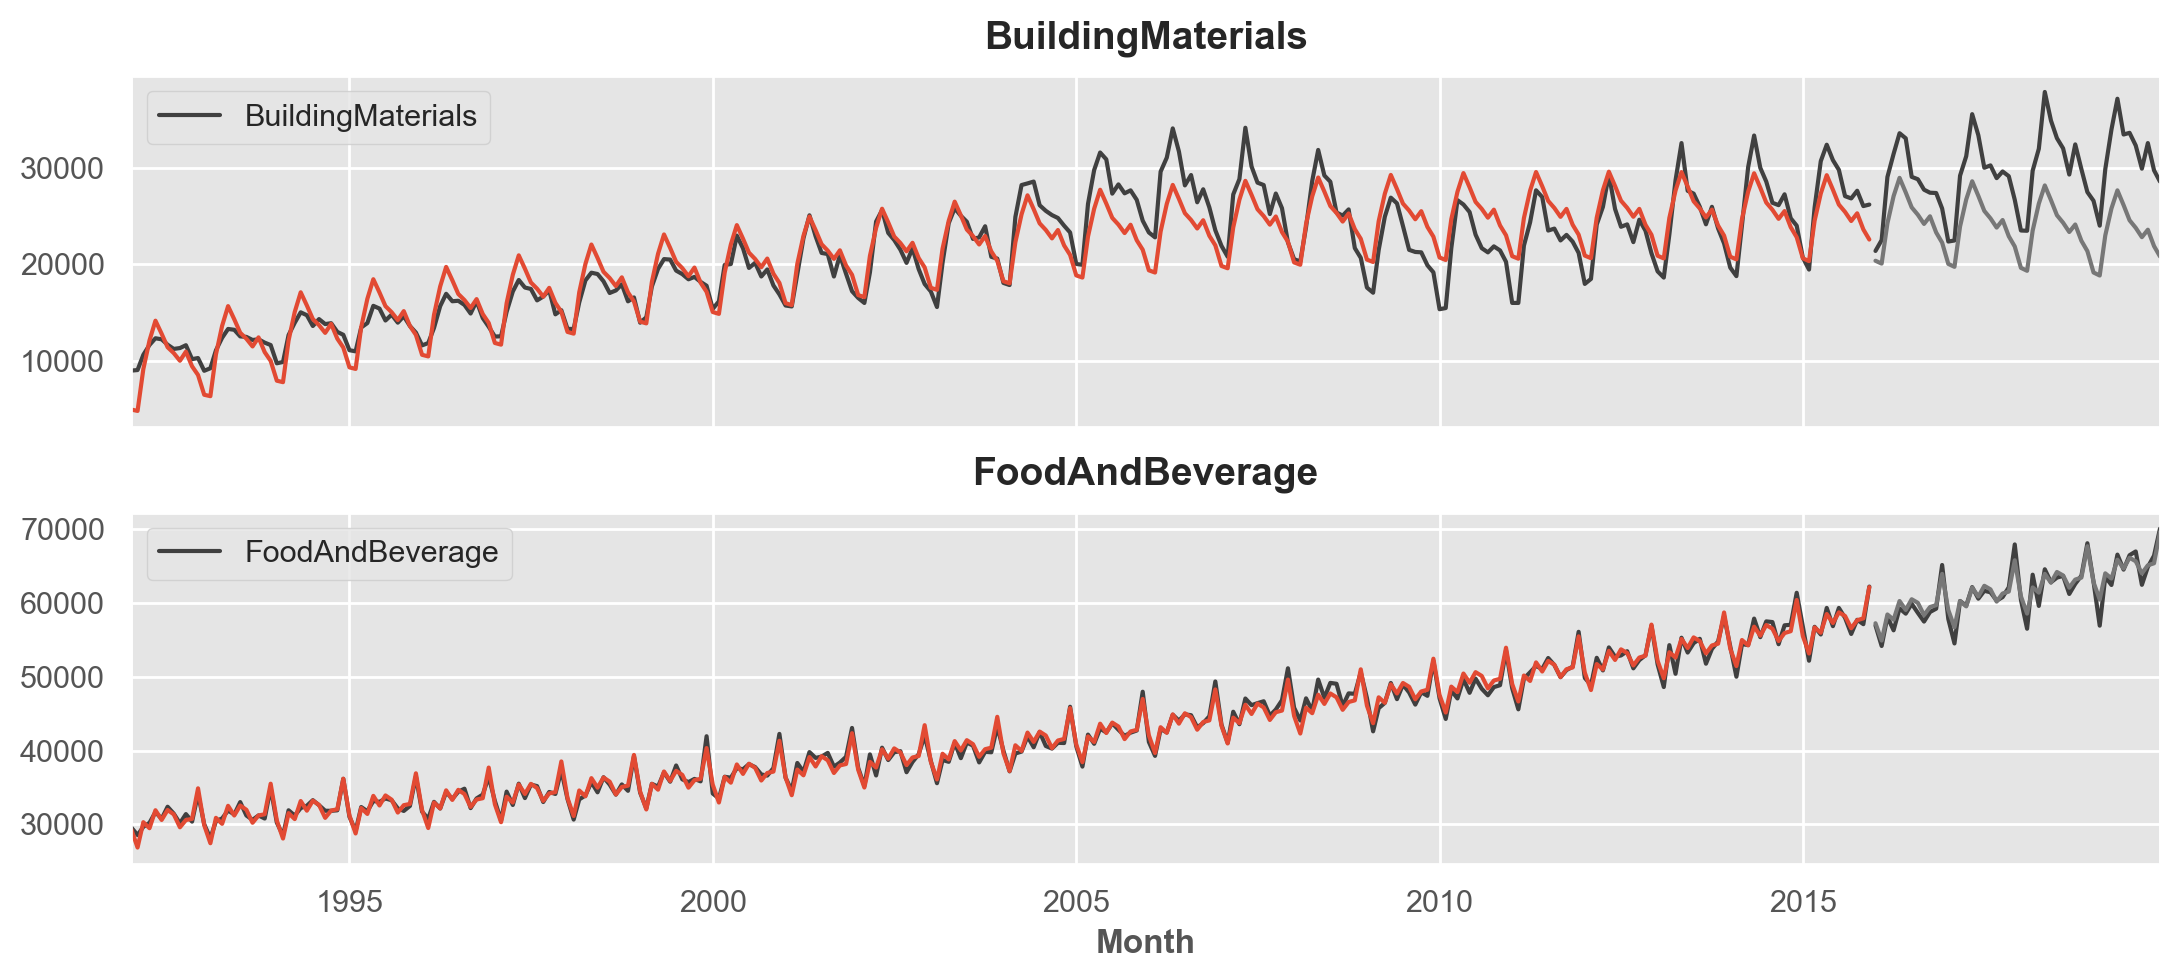

In [82]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for i, ax in enumerate(axs): ax.legend([y_train.unstack(['Industries']).columns.values[i]])

Задания

In [85]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [86]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [88]:
def fit(self, X_1, X_2, y):
    
    self.model_1.fit(X_1, y)
    
    y_fit = pd.DataFrame(
        
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    self.model_2.fit(X_2, y_resid)

    self.y_columns = y.columns
    self.y_fit = y_fit
    self.y_resid = y_resid
    
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add methods to class
BoostedHybrid.fit = fit
BoostedHybrid.predict = predict

In [97]:
y = family_sales.loc[:, 'sales']
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()
X_2 = family_sales.drop('sales', axis=1).stack()
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])
X_2['day'] = X_2.index.day

family  onpromotion  day
date                                
2017-01-01       0     0.000000    1
2017-01-01       1     0.000000    1
2017-01-01       2     0.000000    1
2017-01-01       3     0.703704    1
2017-01-01       4     0.000000    1
...            ...          ...  ...
2017-08-15      28     0.111111   15
2017-08-15      29     0.166667   15
2017-08-15      30    58.685185   15
2017-08-15      31     2.740741   15
2017-08-15      32     0.000000   15

[7491 rows x 3 columns]

In [103]:
model = BoostedHybrid(LinearRegression(), XGBRegressor())
model.fit(X_1,X_2, y)
y_pred = model.predict(X_1,X_2)
y_pred = y_pred.clip(0.0)

family      AUTOMOTIVE  BABY CARE     BEAUTY    BEVERAGES  BOOKS  \
date                                                               
2017-01-01    6.419259   0.000000   4.143753   940.137824    0.0   
2017-01-02    7.702520   1.565518   5.429598  6135.074263    0.0   
2017-01-03   10.172188   1.564878   5.175286  4473.362936    0.0   
2017-01-04   11.730478   3.875387   6.736161  3866.313077    0.0   
2017-01-05   11.166976   4.769982   6.738593  3397.637028    0.0   
...                ...        ...        ...          ...    ...   
2017-08-11    9.447692   2.192123   3.786349  3382.131574    0.0   
2017-08-12    9.447540   2.191483   3.788782  3366.181782    0.0   
2017-08-13    6.371780   0.000000   0.715608  3654.621539    0.0   
2017-08-14    6.371628   0.000000   0.718040  3236.672304    0.0   
2017-08-15    9.282808   2.025287  10.199929  3227.960428    0.0   

family      BREAD/BAKERY  CELEBRATION     CLEANING        DAIRY        DELI  \
date                                                                          
2017-01-01    242.474471     8.648161   406.454277   328.598697  107.306352   
2017-01-02    605.509721    11.672750  1829.468434  1369.872254  412.765677   
2017-01-03    605.413628    11.672065  1344.904641  1037.272941  367.197263   
2017-01-04    587.898303    13.229822  1583.415022  1087.579144  380.388766   
2017-01-05    565.761622    13.229137  1250.380101  1011.358417  317.259660   
...                  ...          ...          ...          ...         ...   
2017-08-11    539.264960    14.614328  1232.637498   859.014846  336.551260   
2017-08-12    539.168866    14.613643  1140.286749   875.127632  320.160044   
2017-08-13    643.167145    11.537349  1321.628644   813.296798  310.693214   
2017-08-14    517.950020    11.536664  1050.553329   701.209913  310.701841   
2017-08-15    523.856357    14.447312  1100.772641   726.297481  299.541475   

family      ...  MAGAZINES       MEATS  PERSONAL CARE  PET SUPPLIES  \
date        ...                                                       
2017-01-01  ...   0.000000  287.294662     203.746380      0.000000   
2017-01-02  ...   6.402037  367.599545     526.554908     10.849517   
2017-01-03  ...   6.405028  367.670840     412.518389     10.853372   
2017-01-04  ...   9.971845  367.742135     397.438004     10.857226   
2017-01-05  ...   9.974836  384.063858     387.959209     11.630651   
...         ...        ...         ...            ...           ...   
2017-08-11  ...   7.054935  603.860907     283.824870      7.616214   
2017-08-12  ...   7.057927  350.639057     283.612371      7.620069   
2017-08-13  ...   3.985310  347.634743     273.327687      4.548316   
2017-08-14  ...   3.988301  347.706038     273.115188      4.552170   
2017-08-15  ...   6.902624  350.688664     278.905119      8.201874   

family      PLAYERS AND ELECTRONICS     POULTRY  PREPARED FOODS      PRODUCE  \
date                                                                           
2017-01-01                 4.922324  305.642832       57.486953   789.826155   
2017-01-02                13.046549  424.093500      115.833787  2993.768097   
2017-01-03                13.046370  428.923000      130.215558  3122.897478   
2017-01-04                15.051574  413.926019      145.803745  3357.414921   
2017-01-05                15.051395  390.666567      123.978256  2448.346254   
...                             ...         ...             ...          ...   
2017-08-11                10.157617  559.276116       73.353308  2217.461574   
2017-08-12                10.157438  367.746016       73.194208  2217.181165   
2017-08-13                 7.081651  363.596827       69.959500  2289.270812   
2017-08-14                 7.081472  359.317365       69.800400  2288.990403   
2017-08-15                 8.808318  368.198457       73.287150  2436.580943   

family      SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                               
2017-01-01        

Training RMSLE: 0.42360
Validation RMSLE: 0.44321


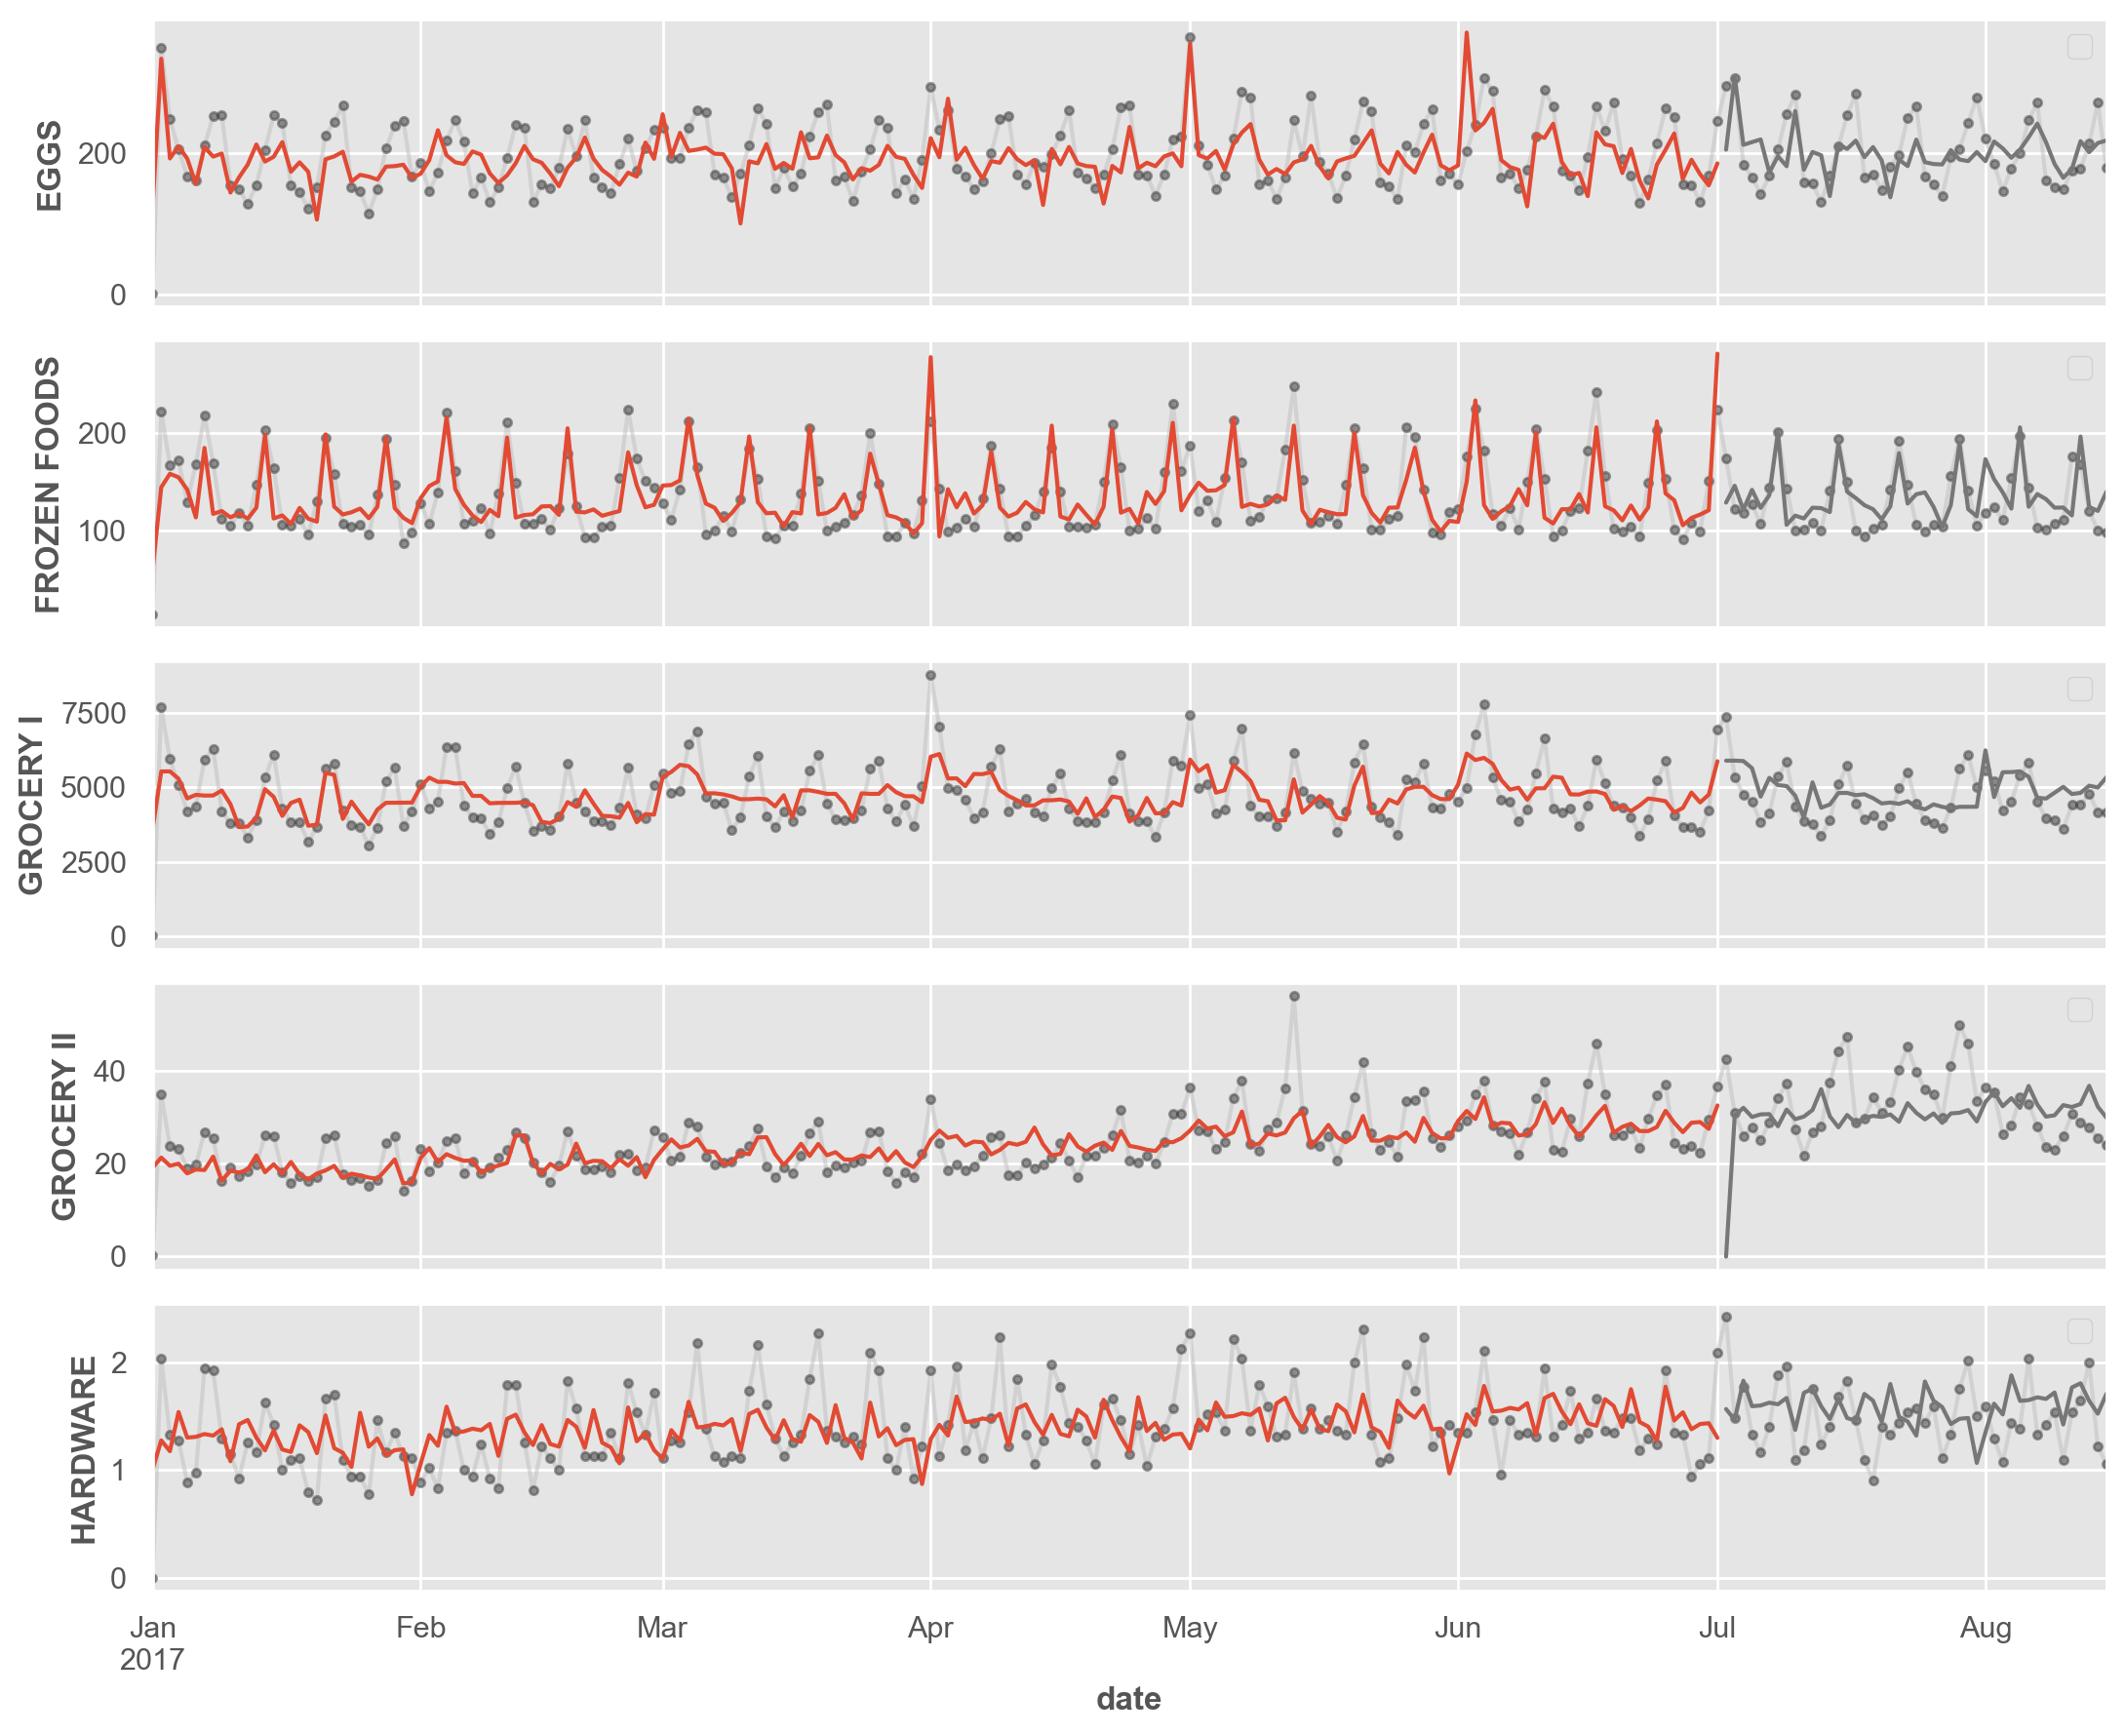

In [128]:
# Model
model = BoostedHybrid(
    model_1 = Lasso(),
    model_2 = KNeighborsRegressor()
)

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[10:15]
axs = y.loc(axis = 1)[families].plot(**plot_params, subplots = True, sharex=True, figsize=(11, 9), alpha = 0.5)
_ = y_fit.loc(axis = 1)[families].plot(ax = axs, subplots=True, sharex=True, color='C0')
_ = y_pred.loc(axis = 1)[families].plot(ax = axs, subplots=True, sharex=True, color='C3')

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

# Forecasting With Machine Learning

Мы могли бы легко создавать прогнозы на любое время в будущем, просто генерируя желаемые трендовые и сезонные характеристики.

Однако, когда мы добавили функции с запаздыванием в уроке **Временные ряды как признаки**, суть проблемы изменилась. Функции с запаздыванием требуют, чтобы на момент прогнозирования было известно целевое значение с запаздыванием. Функция запаздывания на 1 шаг сдвигает временной ряд вперед на 1 шаг, что означает, что вы могли бы предсказать будущее на 1 шаг, но не на 2 шага.

На уроке **Временные ряды как признаки** мы просто предположили, что всегда можем генерировать задержки вплоть до периода, который хотим спрогнозировать (другими словами, каждый прогноз был рассчитан всего на один шаг вперед). Для прогнозирования в реальном мире обычно требуется нечто большее, поэтому на этом уроке мы узнаем, как составлять прогнозы для различных ситуаций.

Перед разработкой модели прогнозирования необходимо определить две вещи:

- какая информация доступна на момент составления прогноза (**характеристики**)- и
период времени, в течение которого вам требуются прогнозируемые значения (**цель**).
- **Исходная точка прогноза** - это время, на которое вы делаете прогноз. На практике вы можете считать, что исходная точка прогноза - это последний раз, когда у вас есть данные для обучения на прогнозируемое время. Все, что указано в исходной точке, может быть использовано для создания объектов.

- **Горизонт прогноза** - это время, на которое вы строите прогноз. Мы часто описываем прогноз по количеству временных шагов в его горизонте: скажем, прогноз "на 1 шаг" или "на 5 шагов". Горизонт прогноза описывает цель

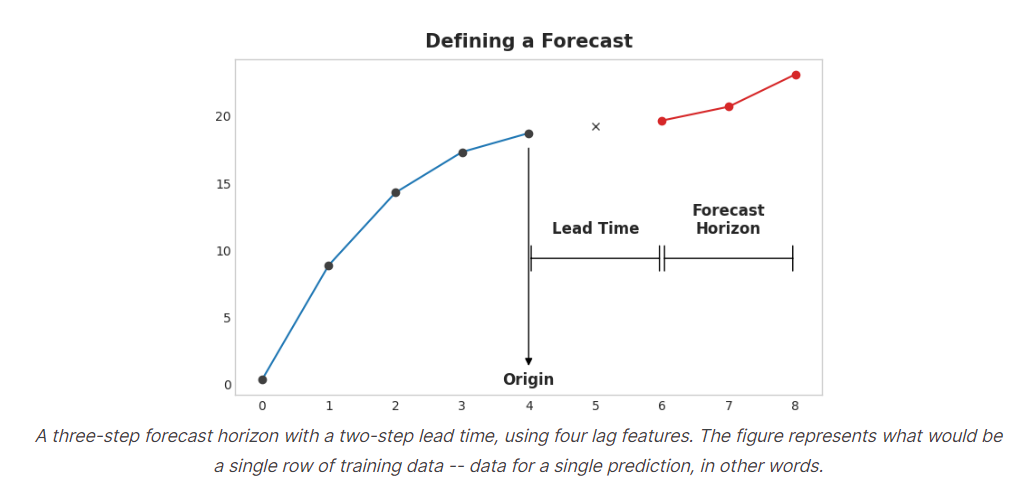

**Время между началом и горизонтом** - это время выполнения прогноза (или иногда задержка). Время выполнения прогноза определяется количеством шагов от начала до горизонта: например, прогноз "на 1 шаг вперед" или "на 3 шага вперед". На практике может возникнуть необходимость в том, чтобы прогноз начинался на несколько этапов раньше исходного из-за задержек в сборе или обработке данных

Чтобы спрогнозировать временные ряды с помощью алгоритмов ML, нам необходимо преобразовать ряд в структуру данных, которую мы можем использовать с помощью этих алгоритмов.

Каждая строка во фрейме данных представляет собой отдельный прогноз. Временной индекс строки отображается впервые на горизонте прогноза, но мы размещаем значения для всего горизонта в одной строке. Для многоступенчатых прогнозов это означает, что нам требуется, чтобы модель выдавала несколько выходных данных, по одному для каждого шага

In [154]:
N = 20
ts = pd.Series(
    np.arange(N),
    index = pd.period_range(start = '2010', freq = 'A', periods = N, name = 'Year'),
     dtype=pd.Int8Dtype)

X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})
# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})
data = pd.concat({'Targets': y, 'Features': X}, axis = 1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush', 'color': 'black'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender', 'color': 'black'})

**Стратегии многоступенчатого прогнозирования**
Существует несколько стратегий для получения нескольких целевых шагов, необходимых для прогноза. 

Четыре общие стратегии, каждая из которых имеет свои сильные и слабые стороны.

- **Модель с несколькими выходными данными**
Используйте модель, которая естественным образом дает несколько выходных данных. Линейная регрессия и нейронные сети могут давать несколько выходных данных. Эта стратегия проста и эффективна, но возможна не для каждого алгоритма, который вы, возможно, захотите использовать. Например, XGBoost не может этого сделать

- **Прямая стратегия**
  
    Разработайте отдельную модель для каждого шага на горизонте: одна модель прогнозирует на 1 шаг вперед, другая - на 2 шага вперед и так далее. Прогнозирование на 1 шаг вперед - это проблема, отличная от прогнозирования на 2 шага вперед (и так далее), поэтому для каждого шага может быть полезно использовать другую модель. Недостатком является то, что обучение большого количества моделей может потребовать больших вычислительных затрат.

- **Рекурсивная стратегия**
  
    Обучаем одну пошаговую модель и используем ее прогнозы для обновления характеристик запаздывания для следующего шага. С помощью рекурсивного метода мы возвращаем одношаговый прогноз модели обратно в ту же модель, чтобы использовать его в качестве функции запаздывания для следующего шага прогнозирования. Нам нужно обучить только одну модель, но поскольку ошибки будут распространяться от шага к шагу, прогнозы могут быть неточными на больших горизонтах.

- **Комбинация прямой и рекурсивной стратегий**.
  
  Обучайте модель для каждого шага и используйте прогнозы предыдущих шагов в качестве новых функций задержки. Шаг за шагом каждая модель получает дополнительные данные о задержке. Поскольку каждая модель всегда имеет актуальный набор функций запаздывания, стратегия DirRec может лучше отражать последовательную зависимость, чем прямую, но она также может страдать от распространения ошибок, как и рекурсивная.

In [156]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [167]:
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex( flu_trends.Week, freq = 'W'), inplace = True)
flu_trends.drop('Week', axis=1, inplace=True)

In [183]:
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags = 4).fillna(0.0)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
y = make_multistep_target(y, steps = 8).dropna()
y, X = y.align(X, join='inner', axis=0)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 389.12
Test RMSE: 582.33


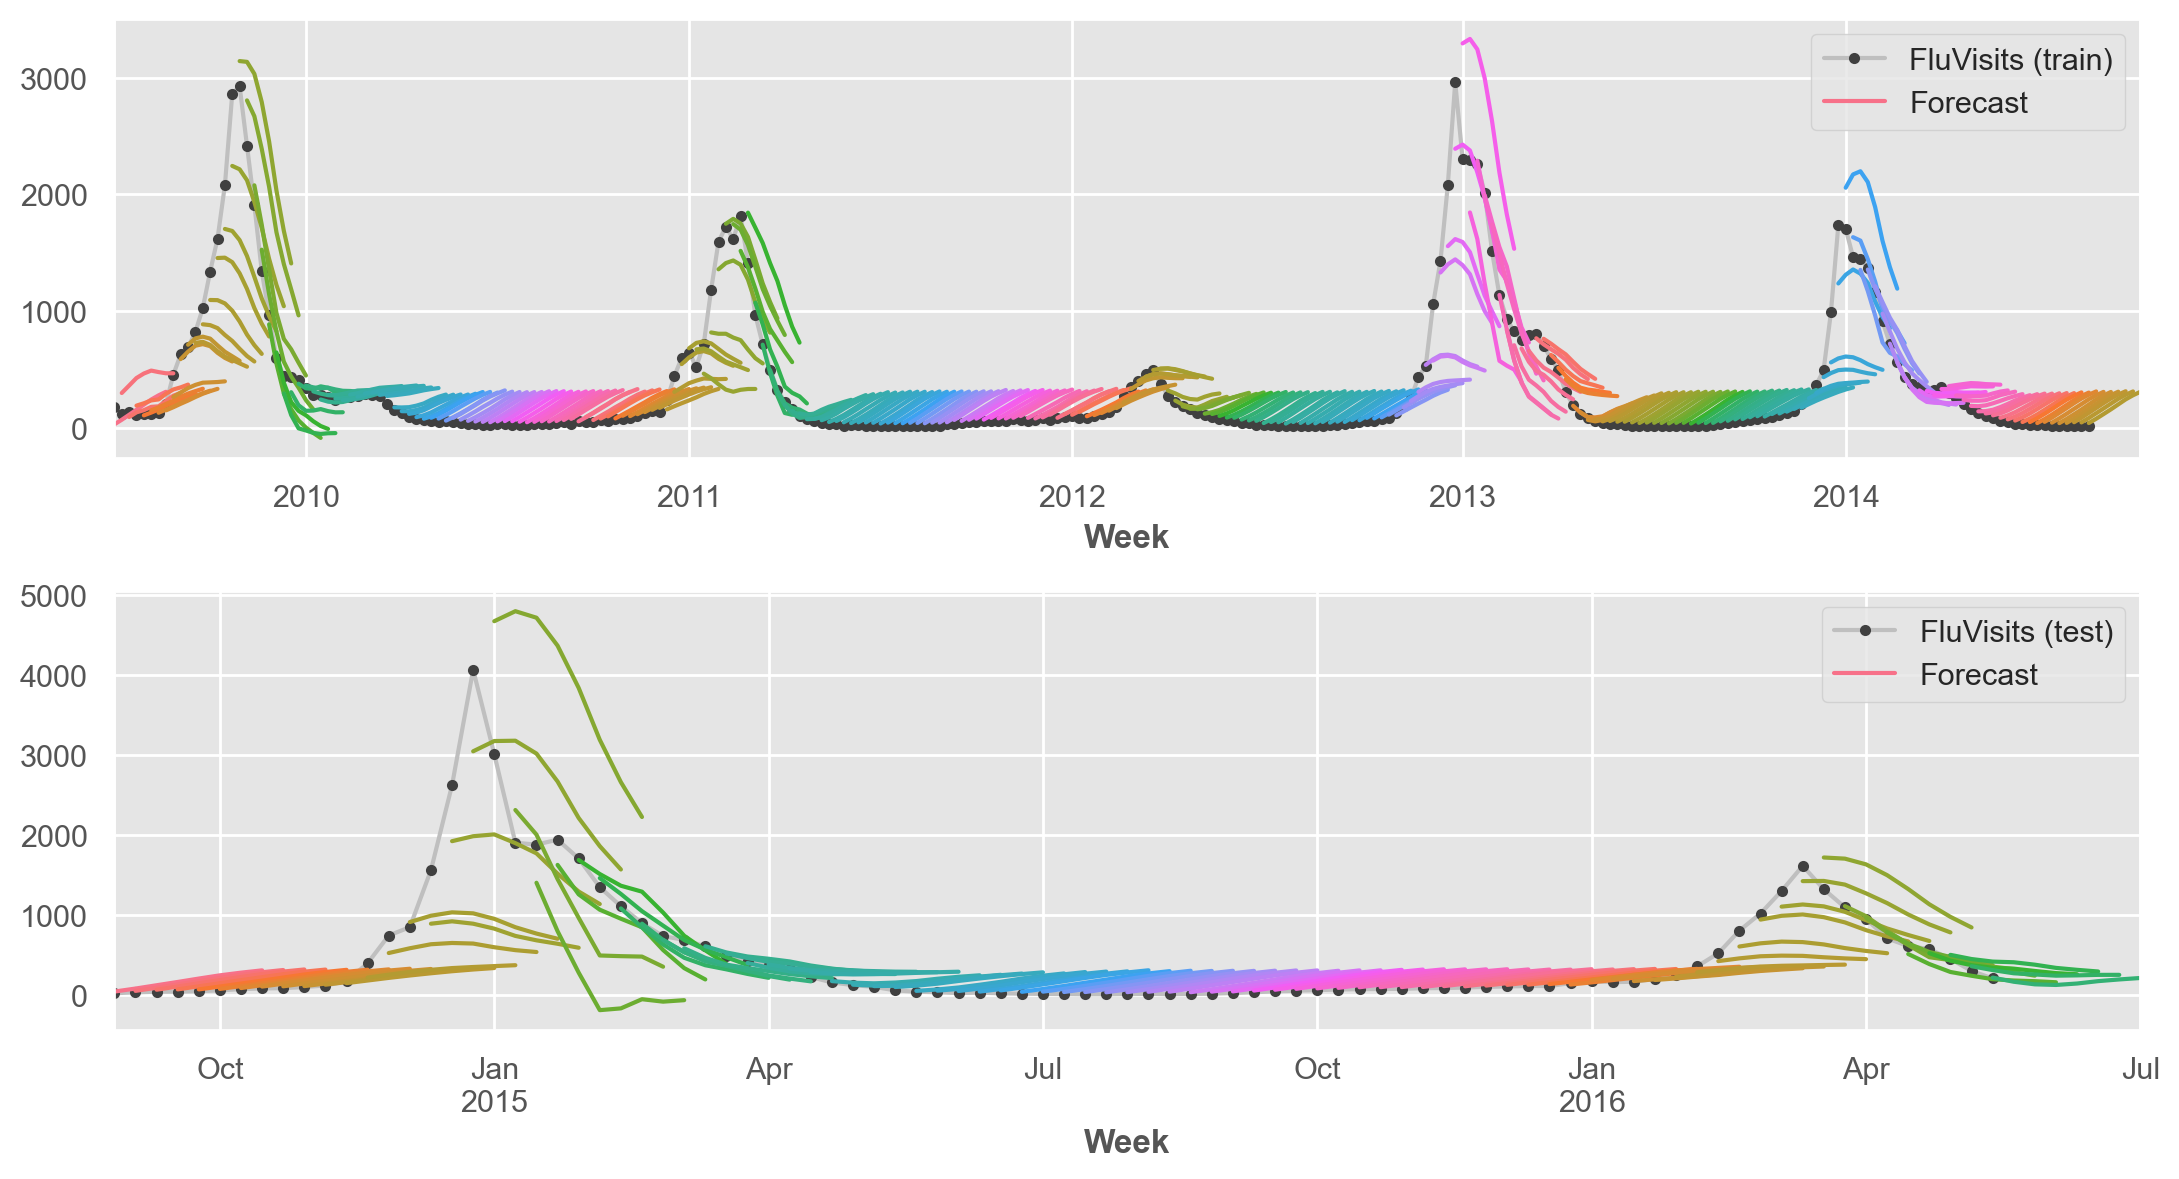

In [188]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

Прямая стратегия
XGBoost не может создавать множественные выходные данные для задач регрессии. Но, применяя стратегию прямого сокращения, мы все равно можем использовать ее для создания многоступенчатых прогнозов

In [190]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor()) # ????
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 1.22
Test RMSE: 526.45


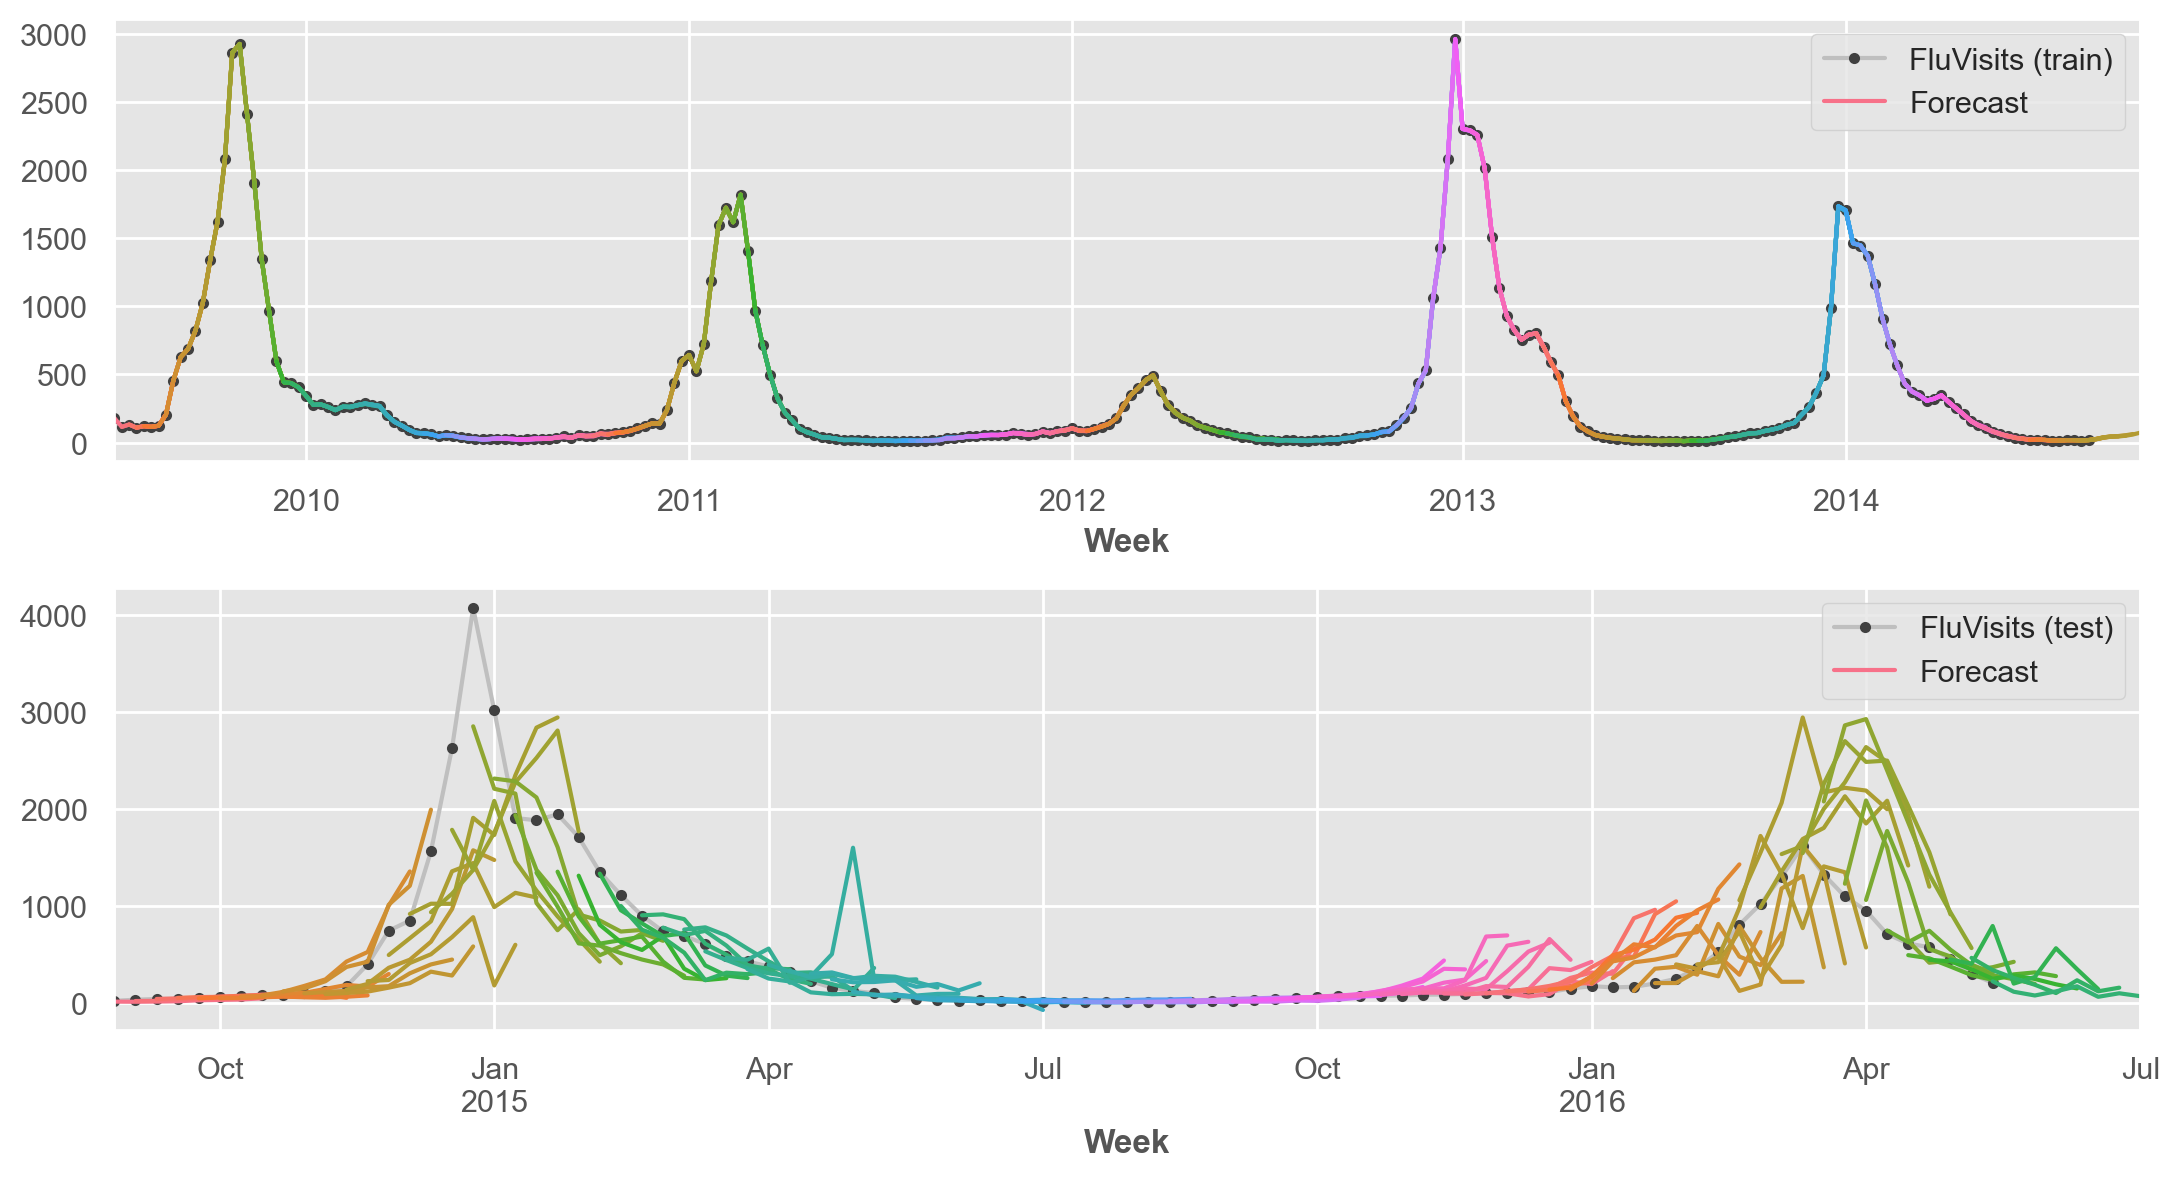

In [191]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])